In [1]:
import math
import os 
import warnings

import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

%matplotlib inline
sns.set_palette('muted')
sns.set_style('darkgrid')
pd.set_option('display.float_format',lambda x:'%.3f' % x)
pd.set_option("max_columns", 300)
warnings.filterwarnings('ignore')

print('导入及设置成功')

导入及设置成功


In [2]:
# 读取Master数据
df_dataset = pd.read_csv('data/Training/PPD_Training_Master_GBK_3_1_Training_Set.csv',encoding='gb18030')
print (df_dataset.shape)

(30000, 228)


In [3]:
# 展示记录
# 将max_columns设置为300，由于本次的数据集共有200多个特征，因此设为300后可以展示数据所有特征
pd.set_option("max_columns", 300)
# 展示数据
df_dataset.head()

Idx  UserInfo_1 UserInfo_2  UserInfo_3 UserInfo_4  WeblogInfo_1  \
0  10001       1.000         深圳       4.000         深圳           nan   
1  10002       1.000         温州       4.000         温州           nan   
2  10003       1.000         宜昌       3.000         宜昌           nan   
3  10006       4.000         南平       1.000         南平           nan   
4  10007       5.000         辽阳       1.000         辽阳           nan   

   WeblogInfo_2  WeblogInfo_3  WeblogInfo_4  WeblogInfo_5  WeblogInfo_6  \
0         1.000           nan         1.000         1.000         1.000   
1         0.000           nan         1.000         1.000         1.000   
2         0.000           nan         2.000         2.000         2.000   
3           nan           nan           nan           nan           nan   
4         0.000           nan         1.000         1.000         1.000   

   WeblogInfo_7  WeblogInfo_8  WeblogInfo_9  WeblogInfo_10  WeblogInfo_11  \
0            14             0             0              0              0   
1            14             0             0              0              0   
2             9             3             0              0              0   
3             2             0             0              0              0   
4             3             0             0              0              0   

   WeblogInfo_12  WeblogInfo_13  WeblogInfo_14  WeblogInfo_15  WeblogInfo_16  \
0              0              0              6              6              0   
1              0              0              0              0              7   
2              0              0              0              0              3   
3              0              0              0              0              0   
4              0              0              0              0              0   

   WeblogInfo_17  WeblogInfo_18  UserInfo_5  UserInfo_6 UserInfo_7 UserInfo_8  \
0              6              2           2           2         广东         深圳   
1              7              0           2           2         浙江         温州   
2              4              2           2           2         湖北         宜昌   
3              2              0           2           2         福建         南平   
4              3              0           2           2         辽宁         辽阳   

  UserInfo_9  UserInfo_10  UserInfo_11  UserInfo_12  UserInfo_13  UserInfo_14  \
0      中国移动             0          nan          nan          nan            2   
1      中国移动             1        0.000        0.000        1.000            3   
2      中国电信             0        0.000        0.000        1.000            4   
3      中国移动             0        0.000        0.000        1.000            2   
4      中国移动             0          nan          nan          nan            3   

   UserInfo_15  UserInfo_16  UserInfo_17  UserInfo_18 UserInfo_19 UserInfo_20  \
0            2            1            1           29         四川省         南充市   
1            3            2            2           28         福建省          不详   
2            4            2            1           32         湖北省         宜昌市   
3            2            1            1           33         江西省          不详   
4            3            1            1           43         辽宁省         锦州市   

   UserInfo_21 UserInfo_22 UserInfo_23 UserInfo_24  Education_Info1  \
0            0           D           D           D                0   
1            0           D           D           D                0   
2            0           D           D           D                0   
3            0           D           D           D                0   
4            0           D           D           D                0   

  Education_Info2 Education_Info3 Education_Info4  Education_Info5  \
0               E               E               E                0   
1               E               E               E                0   
2               E               E               E                0   
3        

In [4]:
# 正负样本的比例，查看样本比例是否不平衡
# 提取出标签中0和1的数量，其中0代表正常还款，为正样本，1代表逾期，为负样本
df_target = df_dataset['target'].value_counts()
# 打印结果
print(df_target)
# 计算正样本比例
pos_proportion = df_target[0] / (df_target[0] + df_target[1])
# 计算负样本比例
neg_proportion = df_target[1] / (df_target[0] + df_target[1])
# 打印正负样本比例结果
print('正样本（没有逾期）的比例为:%.2f' % (pos_proportion))
print('负样本（逾期）的比例为:%.2f' % (neg_proportion))
# 通过统计可知，正负样本比例已经超过10:1，样本很不平衡

0    27802
1     2198
Name: target, dtype: int64
正样本（没有逾期）的比例为:0.93
负样本（逾期）的比例为:0.07


> #### 1. 数据的预处理。 需要考虑以下几个方面：
- ```缺失值```。数据里有大量的缺失值，需要做一些处理。 
- ```字符串的清洗```。比如“北京市”和“北京”合并成“北京”， 统一转换成小写等
- ```二值化```。具体方法请参考课程里的介绍
- ```衍生特征```：比如户籍地和当前城市是否是同一个？ 
- ```特征的独热编码```：对于类别型特征使用独热编码形式
- ```连续性特征的处理```：根据情况来处理
- ```其他```: 根据情况，自行决定要不要做

1.0.1 1.1第一轮预处理：缺失值处理
- ```1、查看每个特征缺失值数量```
- ```2、可视化每个特征缺失值的数量```
- ```3、删除缺失值过多的特征```
- ```4、填充缺失值```
- ```5、重新查看缺失值是否为0```

In [5]:
'''
1、计算每个特征的缺失值比例
'''
# 使用pandas的isnull方法和sum方法，计算每个特征里的缺失值数量，并将结果存入dataset_info内
dataset_info = df_dataset.isnull().sum()
# 创建一个新DataFrame，命名为df_feature，其索引为每个特征的名称，值为每个特征的缺失值数量
df_feature = pd.DataFrame(data=dataset_info.values, index=dataset_info.index, columns=['缺失值数量'])
# 提取df_feature中所有具有缺失值的特征，并将结果存入df_feature_nan
df_feature_nan = df_feature[df_feature['缺失值数量']>0]
# df_feature_nan内新增加一列，该列信息为每个特征的缺失值数量占比
df_feature_nan['缺失值占比'] = df_feature_nan['缺失值数量'] / len(df_dataset)


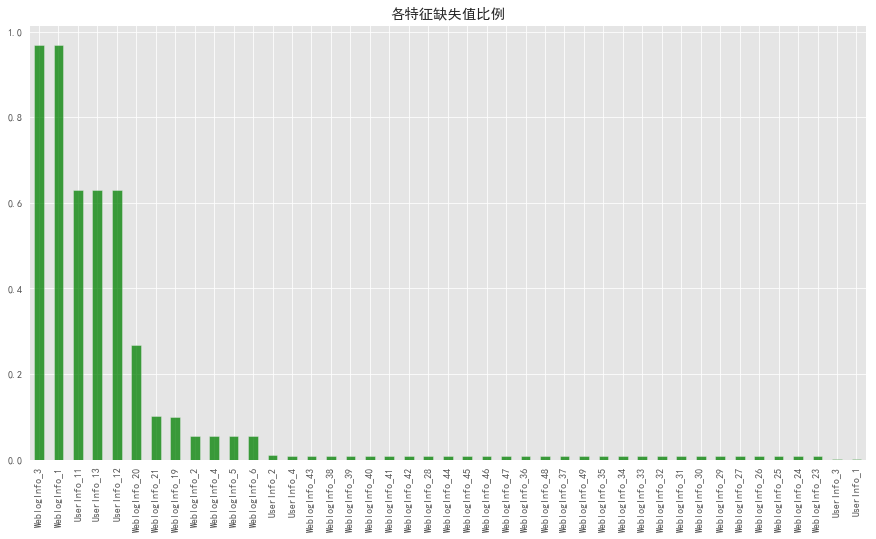

In [6]:
'''
2、可视化每个特征缺失值的比例：
'''
# 定义bar_figure函数
def bar_figure(plot_data, title, figsize):
    '''
    该函数功能是对数据降序排列后进行柱状图可视化
    plot_data:需要做可视化的数据
    title:图的标题
    figsize:图的大小
    '''
    # 设置画图样式
    matplotlib.style.use('ggplot')
    # 指定默认字体 SimHei为黑体
    matplotlib.rcParams['font.sans-serif'] = ['SimHei']
    # 正常显示负号
    matplotlib.rcParams['axes.unicode_minus'] = False 
    # 画图
    plt.figure()
    # 画柱状图，大小设置为（15,8），颜色为绿色，并带网格，透明度为0.75
    plot_data.plot(kind='bar', figsize=figsize, color='g', grid=True, alpha=0.75)
    # 添加图的标题
    plt.title(label=title)
    # 展示可视化结果
    return plt.show()

# 对df_feature_nan的‘缺失值占比’列进行降序排序（等同于对‘缺失值数量’降序排序）
df_feature_nan.sort_values(by='缺失值占比', axis=0, ascending=False, inplace=True)
# 通过bar_figure函数对df_feature_nan的‘缺失值占比’进行可视化
bar_figure(plot_data=df_feature_nan['缺失值占比'], title='各特征缺失值比例', figsize=(15,8))

In [7]:

'''
3、删除缺失值过多的特征:
通过1.0.1.1分析得知,WeblogInfo_1、WeblogInfo_3、UserInfo_11、UserInfo_12、UserInfo_13
以上5个特征缺失值都超过了60%，因此做删除处理
'''
# 通过drop方法将缺失值较多的特征删除
df_dataset.drop(['WeblogInfo_1', 'WeblogInfo_3', 'UserInfo_11', 'UserInfo_12', 'UserInfo_13'], 
                axis=1, inplace=True)


In [8]:
'''
4、填充缺失值:
对于缺失值不多的特征（相对于1.0.1.2里删除的那五个特征，其余有缺失值的特征，缺失数据占比都不超过30%），在做填充处理时：
4.1、对于数值型（int、float）特征，此类缺失值的特征有:UserInfo_1、UserInfo_3、WeblogInfo_2等33个特征，
通过检查这33个特征得到：float、int类型特征都是类似于1、2、3这类的整数，将这些数值型特征视为‘数值型类别特征’，对于
这些特征，缺失值做填充众数处理
4.2、对于类别型特征，填充众数，此类缺失值的特征有:UserInfo_2、UserInfo_4、WeblogInfo_19等5个特征
4.3、创建函数，fill_category_na，实现对类别型特征的缺失值填充众数的功能
4.4、创建两个list，分别存储具有缺失值的数值型特征和类别型特征:
(1) 数值型特征共有33个:
'UserInfo_1', 'UserInfo_3', 'WeblogInfo_2','WeblogInfo_4', 'WeblogInfo_5', 'WeblogInfo_6'，
‘WeblogInfo_23’ - ’WeblogInfo_49’这27个具有连续数字后缀的特征名称
(2) 类别型特征共有5个:
‘UserInfo_2’,‘UserInfo_4’,‘WeblogInfo_19’,‘WeblogInfo_20’,‘WeblogInfo_21’
(3) 考虑到‘WeblogInfo_23’-‘WeblogInfo_49’以及‘WeblogInfo_19’-‘WeblogInfo_21’的名称的连续性，实现这部分内容
创建函数，功能是生成一个列表，里面存储的是名字后缀是连续数字的特征名称
'''

# 定义fill_category_na函数
def fill_category_na(df, columns_list):
    '''
    该函数功能是将样本数据中所有类别型特征中的缺失数据填充为该特征的众数
    df:输入的数据集
    columns_list:为一个列表集合，里面的元素为每个具有缺失值的类别型特征
    最后函数返回值为将缺失值填充成相应特征平均值的样本数据
    '''
    # 遍历每一个具有缺失值的类别型特征
    for column in columns_list:
        # 对每一个类别型特征计算出每个类别的数量
        counts = df[column].value_counts()
        # 将该特征的众数作为填充值 
        df[column].fillna(np.argmax(counts), axis=0, inplace=True)
    # 函数返回值为填充好的样本数据
    return df


# 定义feature_list函数
def feature_list(feature_name, num1, num2):
    '''
    该函数的功能是创建一个列表，列表内的元素是名字后缀是连续数字的特征名称，例如WeblogInfo_23、WeblogInfo_24这些
    feature_name:特征名称，例如WeblogInfo_
    num1:特征名称后缀数字的起始值
    num2:特征名称后缀数字的终止值
    '''
    # 创建空列表，存储特征名称
    lst = []
    # 特征名称后缀数字范围
    for i in range(num1, num2+1):
        # 创建特征名称
        name = feature_name + str(i)
        # 将特征名称加入到列表里
        lst.append(name)
    # 函数返回值为存储了所有特征名称的列表lst
    return lst


# 创建columns_list_numeral，里面加入其它6个具有缺失值的连续型特征名
columns_list_numeral = ['UserInfo_1', 'UserInfo_3', 'WeblogInfo_2', 'WeblogInfo_4', 'WeblogInfo_5', 'WeblogInfo_6']
# 利用feature_list函数生成WeblogInfo_23-WeblogInfo_49这27个特征名称，合并入columns_list_numeral里，构成了具有缺失值的全部数值型特征名称列表
columns_list_numeral.extend(feature_list('WeblogInfo_', 23, 49))
# 创建columns_list_category，里面存入其它2个具有缺失值的类别型特征名
columns_list_category = ['UserInfo_2', 'UserInfo_4']
# 利用feature_list函数生成WeblogInfo_19-WeblogInfo_21这3个特征名称，并合并入columns_list_category里，构成了具有缺失值的全部类别型特征名称列表
columns_list_category.extend(feature_list('WeblogInfo_', 19, 21))
# 执行fill_category_na函数，填充样本数据中所有数值型特征中的缺失值，填充为各特征的众数
fill_category_na(df_dataset, columns_list_numeral)
# 执行fill_category_na函数，填充样本数据中所有类别型特征的缺失值，填充为各特征的众数
fill_category_na(df_dataset, columns_list_category)
# 结果展示
df_dataset.head()

Idx  UserInfo_1 UserInfo_2  UserInfo_3 UserInfo_4  WeblogInfo_2  \
0  10001       1.000         深圳       4.000         深圳         1.000   
1  10002       1.000         温州       4.000         温州         0.000   
2  10003       1.000         宜昌       3.000         宜昌         0.000   
3  10006       4.000         南平       1.000         南平         0.000   
4  10007       5.000         辽阳       1.000         辽阳         0.000   

   WeblogInfo_4  WeblogInfo_5  WeblogInfo_6  WeblogInfo_7  WeblogInfo_8  \
0         1.000         1.000         1.000            14             0   
1         1.000         1.000         1.000            14             0   
2         2.000         2.000         2.000             9             3   
3         1.000         1.000         1.000             2             0   
4         1.000         1.000         1.000             3             0   

   WeblogInfo_9  WeblogInfo_10  WeblogInfo_11  WeblogInfo_12  WeblogInfo_13  \
0             0              0              0              0              0   
1             0              0              0              0              0   
2             0              0              0              0              0   
3             0              0              0              0              0   
4             0              0              0              0              0   

   WeblogInfo_14  WeblogInfo_15  WeblogInfo_16  WeblogInfo_17  WeblogInfo_18  \
0              6              6              0              6              2   
1              0              0              7              7              0   
2              0              0              3              4              2   
3              0              0              0              2              0   
4              0              0              0              3              0   

   UserInfo_5  UserInfo_6 UserInfo_7 UserInfo_8 UserInfo_9  UserInfo_10  \
0           2           2         广东         深圳      中国移动             0   
1           2           2         浙江         温州      中国移动             1   
2           2           2         湖北         宜昌      中国电信             0   
3           2           2         福建         南平      中国移动             0   
4           2           2         辽宁         辽阳      中国移动             0   

   UserInfo_14  UserInfo_15  UserInfo_16  UserInfo_17  UserInfo_18  \
0            2            2            1            1           29   
1            3            3            2            2           28   
2            4            4            2            1           32   
3            2            2            1            1           33   
4            3            3            1            1           43   

  UserInfo_19 UserInfo_20  UserInfo_21 UserInfo_22 UserInfo_23 UserInfo_24  \
0         四川省         南充市            0           D           D           D   
1         福建省          不详            0           D           D           D   
2         湖北省         宜昌市            0           D           D           D   
3         江西省          不详            0           D           D           D   
4         辽宁省         锦州市            0           D           D           D   

   Education_Info1 Education_Info2 Education_Info3 Education_Info4  \
0                0               E               E               E   
1                0               E               E               E   
2                0               E               E               E   
3                0               E               E               E   
4                0               E               E               E   

   Education_Info5 Education_Info6 Education_Info7 Education_Info8  \
0                0               E               E               E   
1                0               E               E               E   
2                0               E               E               E   
3                0               E               E               E   
4                0               E               E   

In [9]:
'''
5、重新查看缺失值是否为0
填充完所有缺失值后，重新查看样本数据，所有特征都没有缺失值
第一轮数据预处理（填充缺失值）后，目前数据集里没有缺失值了，接下来第二轮预处理
'''
# 使用pandas的isnull方法和sum方法，计算填充处理之后的每个特征里的缺失值数量，并将结果存入dataset_new_info内
dataset_new_info = df_dataset.isnull().sum()
# 创建一个新DataFrame，命名为df_feature_new，其索引为每个特征的名称，值为每个特征的缺失值数量
df_feature_new = pd.DataFrame(data=dataset_new_info.values, index=dataset_new_info.index, columns=['缺失值数量'])
# 展示填充处理后的每个特征缺失值之和，若结果为0则说明目前数据集没有缺失值
print('填充缺失值后，数据集所有特征的缺失值之和是:{}'.format(df_feature_new['缺失值数量'].sum()))


填充缺失值后，数据集所有特征的缺失值之和是:0


1.0.1 1.2查看类别型和数值型特征的数量分布
- ```1、各类别型特征的类别数量分布```
- ```2、各数值型特征的数值数量分布```


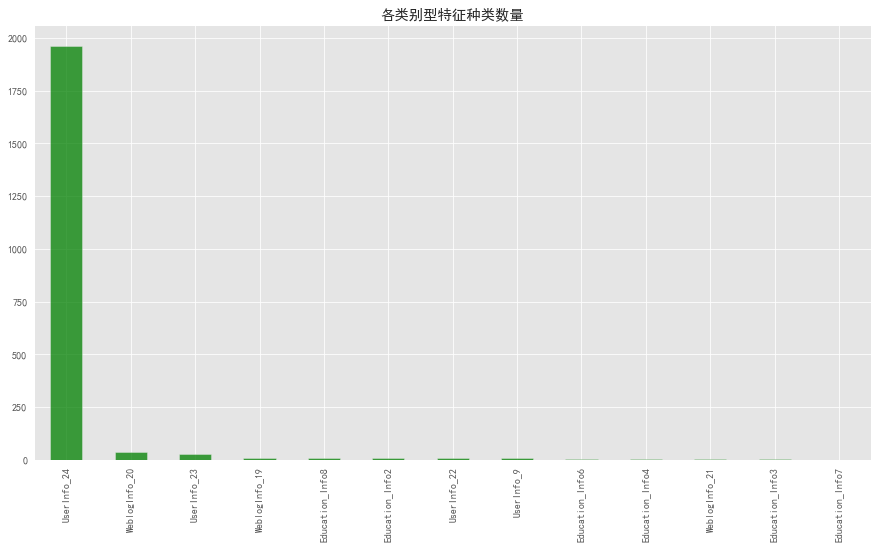

In [10]:
'''
1、各类别型特征的类别数量分布:
在数据集中:
UserInfo_2、UserInfo_4、UserInfo_7-9、UserInfo_19-20 UserInfo_22-24、Education_Info2-4、
Education_Info6-8、WeblogInfo_19-21、ListingInfo共20个类别型特征
其中:
(1) UserInfo_2、UserInfo_4、UserInfo_7、UserInfo_8、UserInfo_19、UserInfo_20为地理位置信息，分类较多，需要单独分析
(2) ListingInfo虽然也是类别型，但是该特征代表的是日期，需要单独分析

通过可视化结果得知：
其余类别型特征
(1) UserInfo_24特征中类别数量达到了1900+，数量过大
(2) UserInfo_22和23特征中类别数量在40个左右
(3) 在接下来分析UserInfo数据时需对以上3个特征做出相应分析及处理
(4) 其余类别型特征的类别数量都在10个左右及以下，可以做独热编码转换
'''
# 创建category_list列表，存储所有类别型特征名称
category_list = ['UserInfo_9']
# 利用feature_list函数创建UserInfo_22-24这3个特征名称，合并入category_list内
category_list.extend(feature_list('UserInfo_', 22, 24))
# 利用feature_list函数创建Education_Info2-4这3个特征名称，合并入category_list内
category_list.extend(feature_list('Education_Info', 2, 4))
# 利用feature_list函数创建Education_Info6-8这3个特征名称，合并入category_list内
category_list.extend(feature_list('Education_Info', 6, 8))
# 利用feature_list函数创建WeblogInfo_19-21这3个特征名称，合并入category_list内
category_list.extend(feature_list('WeblogInfo_', 19, 21))
# 创建空字典category_dic，用来存储每个特征的类别数量，键为特征名，值为特征数量
category_dic = {}
# 遍历category_list内的每个特征
for feature in category_list:
    # 使用unique方法统计出每个特征中的类别，再使用len函数计算出该特征中类别数量，存入category_dic
    category_dic[feature] = len(df_dataset[feature].unique())
# 创建Series，数据为category_dic内的每个特征的类别数量，索引为特征名称
df_category = pd.Series(category_dic, index=category_list)
# 对df_category进行降序排序
df_category.sort_values(axis=0, ascending=False, inplace=True)
# 通过bar_figure函数对ddf_category进行可视化
bar_figure(plot_data=df_category, title='各类别型特征种类数量', figsize=(15,8))


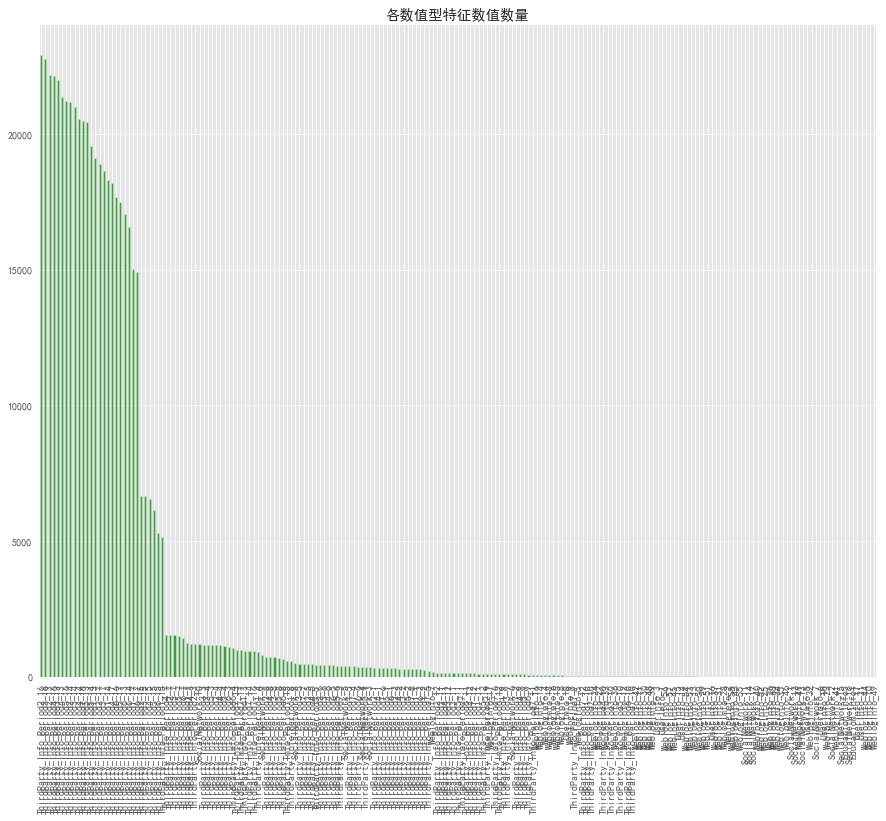

In [11]:
'''
2、各数值型特征中数值数量分布:
在数据集中:
Idx数据每个值都不同，没有作为特征的意义，target为数据标签
创建一个列表，该列表内元素为数据集所有特征名称，将Idx、target及所有类别型特征移除，列表内剩下的为全部数值型特征的名称

通过可视化结果得知：
数值型特征内有相当一部分的数值个数较少，数值类别在12个及以下的数值型特征转换为类别型
'''
# 创建category_list_other列表，里面存储的是Idx，target，ListingInfo及UserInfo的地理位置特征名称
category_list_other = ['Idx', 'UserInfo_2', 'UserInfo_4', 'UserInfo_7', 'UserInfo_8', 
                       'UserInfo_19', 'UserInfo_20', 'target', 'ListingInfo']
# 将category_list_other合并入category_list内
category_list.extend(category_list_other)
# 创建clolums_list列表，里面存储的是数据集内所有特征名称
clolums_list = list(df_dataset.columns)
# 遍历category_list内每个特征名称
for feature in category_list:
    # 使用remove函数将category_list内的每个特征名称在clolums_list内移除，保留的全部为数值型特征名称
    clolums_list.remove(feature)    
# 创建空字典numeral_dic，用来存储每个特征的数值数量，键为特征名，值为特征数量
numeral_dic = {}
# 遍历clolums_list(目前已经全部为数值型特征)内的每个特征
for feature in clolums_list:
    # 使用unique方法统计出每个特征中的类别，再使用len函数计算出该特征中类别数量，存入clolums_list
    numeral_dic[feature] = len(df_dataset[feature].unique())
# 创建Series，数据为numeral_dic内的每个特征的类别数量，索引为特征名称
df_numeral = pd.Series(numeral_dic, index=clolums_list)
# 对df_numeral进行降序排序
df_numeral.sort_values(axis=0, ascending=False, inplace=True)
# 通过bar_figure函数对df_numeral进行可视化
bar_figure(plot_data=df_numeral, title='各数值型特征数值数量', figsize=(15,12))

1.0.1 1.3第二轮预处理：按照特征名称的种类（Idx、UserInfo、WeblogInfo等）进行数据处理
- ```1、Idx数据处理```
- ```2、Target数据处理```
- ```3、UserInfo数据处理```
- ```4、WeblogInfo数据处理```
- ```5、Education数据处理```
- ```6、SocialNetwork数据处理```
- ```7、ListingInfo数据处理```
- ```8、ThirdParty_Info_Period数据处理```


In [12]:
'''
1、Idx数据处理：
1.1、首先查看Idx列数据中，所有不同元素的数量
1.2、若结果为30000，说明该列数据所有元素值全部不同，没有作为特征的价值
1.3、结合1.1和1.2，将Idx列作为数据集的Index
'''
# 使用unique方法，查看Idx字段不同数据的数量,再使用len函数计算长度，若长度为30000，说明该列数据所有元素值全部不同
print('Idx字段不同元素的数量为:{}'.format(len(df_dataset['Idx'].unique())))
'''
打印结果为30000，该列数据所有值全部不一样，Idx没有特征价值
'''
# 通过set_index方法，将Idx作为每个数据的Index处理
df_dataset = df_dataset.set_index('Idx')
# 打印结果
df_dataset.head()

Idx字段不同元素的数量为:30000


UserInfo_1 UserInfo_2  UserInfo_3 UserInfo_4  WeblogInfo_2  \
Idx                                                                 
10001       1.000         深圳       4.000         深圳         1.000   
10002       1.000         温州       4.000         温州         0.000   
10003       1.000         宜昌       3.000         宜昌         0.000   
10006       4.000         南平       1.000         南平         0.000   
10007       5.000         辽阳       1.000         辽阳         0.000   

       WeblogInfo_4  WeblogInfo_5  WeblogInfo_6  WeblogInfo_7  WeblogInfo_8  \
Idx                                                                           
10001         1.000         1.000         1.000            14             0   
10002         1.000         1.000         1.000            14             0   
10003         2.000         2.000         2.000             9             3   
10006         1.000         1.000         1.000             2             0   
10007         1.000         1.000         1.000             3             0   

       WeblogInfo_9  WeblogInfo_10  WeblogInfo_11  WeblogInfo_12  \
Idx                                                                
10001             0              0              0              0   
10002             0              0              0              0   
10003             0              0              0              0   
10006             0              0              0              0   
10007             0              0              0              0   

       WeblogInfo_13  WeblogInfo_14  WeblogInfo_15  WeblogInfo_16  \
Idx                                                                 
10001              0              6              6              0   
10002              0              0              0              7   
10003              0              0              0              3   
10006              0              0              0              0   
10007              0              0              0              0   

       WeblogInfo_17  WeblogInfo_18  UserInfo_5  UserInfo_6 UserInfo_7  \
Idx                                                                      
10001              6              2           2           2         广东   
10002              7              0           2           2         浙江   
10003              4              2           2           2         湖北   
10006              2              0           2           2         福建   
10007              3              0           2           2         辽宁   

      UserInfo_8 UserInfo_9  UserInfo_10  UserInfo_14  UserInfo_15  \
Idx                                                                  
10001         深圳      中国移动             0            2            2   
10002         温州      中国移动             1            3            3   
10003         宜昌      中国电信             0            4            4   
10006         南平      中国移动             0            2            2   
10007         辽阳      中国移动             0            3            3   

       UserInfo_16  UserInfo_17  UserInfo_18 UserInfo_19 UserInfo_20  \
Idx                                                                    
10001            1            1           29         四川省         南充市   
10002            2            2           28         福建省          不详   
10003            2            1           32         湖北省         宜昌市   
10006            1            1           33         江西省          不详   
10007            1            1           43         辽宁省         锦州市   

       UserInfo_21 UserInfo_22 UserInfo_23 UserInfo_24  Education_Info1  \
Idx                                                                       
10001            0           D           D           D                0   
10002            0           D           D           D                0   
10003            0           D           D           D                0   
10006            0           D           D           D                0   
10007            0           D           D 

In [13]:
'''
2、Target数据处理
target列作为数据集的标签，在原数据集中放在了最后，为了看数据更加方便，把target放在第一列
'''
# 将target列数据提取出来，并存入front
front = df_dataset['target']
# 删除数据集中target列数据
df_dataset.drop('target', axis=1, inplace=True)
# 使用insert方法，将target数据插入到数据集第一列
df_dataset.insert(0, 'target', front)
# 展示结果
df_dataset.head()

target  UserInfo_1 UserInfo_2  UserInfo_3 UserInfo_4  WeblogInfo_2  \
Idx                                                                         
10001       0       1.000         深圳       4.000         深圳         1.000   
10002       0       1.000         温州       4.000         温州         0.000   
10003       0       1.000         宜昌       3.000         宜昌         0.000   
10006       0       4.000         南平       1.000         南平         0.000   
10007       0       5.000         辽阳       1.000         辽阳         0.000   

       WeblogInfo_4  WeblogInfo_5  WeblogInfo_6  WeblogInfo_7  WeblogInfo_8  \
Idx                                                                           
10001         1.000         1.000         1.000            14             0   
10002         1.000         1.000         1.000            14             0   
10003         2.000         2.000         2.000             9             3   
10006         1.000         1.000         1.000             2             0   
10007         1.000         1.000         1.000             3             0   

       WeblogInfo_9  WeblogInfo_10  WeblogInfo_11  WeblogInfo_12  \
Idx                                                                
10001             0              0              0              0   
10002             0              0              0              0   
10003             0              0              0              0   
10006             0              0              0              0   
10007             0              0              0              0   

       WeblogInfo_13  WeblogInfo_14  WeblogInfo_15  WeblogInfo_16  \
Idx                                                                 
10001              0              6              6              0   
10002              0              0              0              7   
10003              0              0              0              3   
10006              0              0              0              0   
10007              0              0              0              0   

       WeblogInfo_17  WeblogInfo_18  UserInfo_5  UserInfo_6 UserInfo_7  \
Idx                                                                      
10001              6              2           2           2         广东   
10002              7              0           2           2         浙江   
10003              4              2           2           2         湖北   
10006              2              0           2           2         福建   
10007              3              0           2           2         辽宁   

      UserInfo_8 UserInfo_9  UserInfo_10  UserInfo_14  UserInfo_15  \
Idx                                                                  
10001         深圳      中国移动             0            2            2   
10002         温州      中国移动             1            3            3   
10003         宜昌      中国电信             0            4            4   
10006         南平      中国移动             0            2            2   
10007         辽阳      中国移动             0            3            3   

       UserInfo_16  UserInfo_17  UserInfo_18 UserInfo_19 UserInfo_20  \
Idx                                                                    
10001            1            1           29         四川省         南充市   
10002            2            2           28         福建省          不详   
10003            2            1           32         湖北省         宜昌市   
10006            1            1           33         江西省          不详   
10007            1            1           43         辽宁省         锦州市   

       UserInfo_21 UserInfo_22 UserInfo_23 UserInfo_24  Education_Info1  \
Idx                                                                       
10001            0           D           D           D                0   
10002            0           D           D           D                0   
10003            0           D           D           D                0   
10006            0           D           D           D        

In [14]:
'''
3、UserInfo数据处理:

3.1、查看UserInfo数据总体情况
在第一轮预处理中，由于UserInfo_11、UserInfo_12、UserInfo_13这三个特征缺失值过多，已经做删除处理
目前UserInfo特征共有UserInfo_1-10和UserInfo_14-24，共21个特征
首先，通过feature_list函数将所有的UserInfo特征合并到一个列表userinfo_feature_list内
其次，利用describe方法查看所有UserInfo特征的总体信息
'''
# 创建空列表，用来存储所有UserInfo特征名
userinfo_feature_list = []
# 利用feature_list生成UserInfo_1-UserInfo_10这10个特征名称，并合并入userinfo_feature_list内
userinfo_feature_list.extend(feature_list('UserInfo_', 1, 10))
# 利用feature_list生成UserInfo_14-UserInfo_24这11个特征名称，并合并入userinfo_feature_list内
userinfo_feature_list.extend(feature_list('UserInfo_', 14, 24))
# 通过pandas的describe方法，查看每个特征的信息
df_dataset[userinfo_feature_list].describe(include='all')

UserInfo_1 UserInfo_2  UserInfo_3 UserInfo_4  UserInfo_5  UserInfo_6  \
count    30000.000      30000   30000.000      30000   30000.000   30000.000   
unique         nan        327         nan        330         nan         nan   
top            nan         深圳         nan         深圳         nan         nan   
freq           nan       1048         nan       1112         nan         nan   
mean         3.219        NaN       4.694        NaN       1.654       1.654   
std          1.828        NaN       1.321        NaN       0.585       0.584   
min          0.000        NaN       0.000        NaN       1.000       1.000   
25%          1.000        NaN       4.000        NaN       1.000       1.000   
50%          3.000        NaN       5.000        NaN       2.000       2.000   
75%          5.000        NaN       5.000        NaN       2.000       2.000   
max          7.000        NaN       7.000        NaN       3.000       3.000   

       UserInfo_7 UserInfo_8 UserInfo_9  UserInfo_10  UserInfo_14  \
count       30000      30000      30000    30000.000    30000.000   
unique         32        655          7          nan          nan   
top            不详         不详      中国移动           nan          nan   
freq         4213       4213      15481          nan          nan   
mean          NaN        NaN        NaN        0.311        3.417   
std           NaN        NaN        NaN        0.604        1.171   
min           NaN        NaN        NaN        0.000        0.000   
25%           NaN        NaN        NaN        0.000        3.000   
50%           NaN        NaN        NaN        0.000        3.000   
75%           NaN        NaN        NaN        0.000        4.000   
max           NaN        NaN        NaN        2.000        6.000   

        UserInfo_15  UserInfo_16  UserInfo_17  UserInfo_18 UserInfo_19  \
count     30000.000    30000.000    30000.000    30000.000       30000   
unique          nan          nan          nan          nan          31   
top             nan          nan          nan          nan         广东省   
freq            nan          nan          nan          nan        2405   
mean          3.421        1.612        1.129       29.782         NaN   
std           1.168        1.060        0.336        6.421         NaN   
min           0.000        0.000        1.000        0.000         NaN   
25%           3.000        1.000        1.000       25.000         NaN   
50%           3.000        1.000        1.000       28.000         NaN   
75%           4.000        2.000        1.000       33.000         NaN   
max           6.000        6.000        2.000       55.000         NaN   

       UserInfo_20  UserInfo_21 UserInfo_22 UserInfo_23 UserInfo_24  
count        30000    30000.000       30000       30000       30000  
unique         297          nan           7          27        1963  
top             不详          nan           D           D           D  
freq          7173          nan       27867       27867       27867  
mean           NaN        0.071         NaN         NaN         NaN  
std            NaN        0.257         NaN         NaN         NaN  
min            NaN        0.000         NaN         NaN         NaN  
25%            NaN        0.000         NaN         NaN         NaN  
50%            NaN        0.000         NaN         NaN         NaN  
75%            NaN        0.000         NaN         NaN         NaN  
max            NaN        1.000         NaN         NaN         NaN

In [15]:
'''
3.2、UserInfo特征分类:
通过3.1查看每个UserInfo特征信息，可知：
UserInfo_2、UserInfo_4、UserInfo_7-9、UserInfo_19-20、UserInfo_22-24为类别型特征
UserInfo_1、UserInfo_3、UserInfo_5-6、UserInfo_10、UserInfo_14-18、UserInfo_21为数值型特征
'''
# 1、将所有类别型特征名称存入userinfo_category_list
# 创建userinfo_category_list列表，用来存储UserInfo的类别型特征
userinfo_category_list = ['UserInfo_2', 'UserInfo_4']
# 利用feature_list函数生成UserInfo_7-UserInfo_9这3个特征名称，并将结果合并入存入userinfo_category_list
userinfo_category_list.extend(feature_list('UserInfo_', 7, 9))
# 利用feature_list函数生成UserInfo_19-UserInfo_20这2个特征名称，并将结果合并入存入userinfo_category_list
userinfo_category_list.extend(feature_list('UserInfo_', 19, 20))
# 利用feature_list函数生成UserInfo_22-UserInfo_24这3个特征名称，并将结果合并入存入userinfo_category_list
userinfo_category_list.extend(feature_list('UserInfo_', 22, 24))

# 2、将所有数值型特征名称存入userinfo_numerical_list
# 创建userinfo_numerical_list列表，用来存储UserInfo的数值型特征
userinfo_numerical_list = ['UserInfo_1', 'UserInfo_3', 'UserInfo_10', 'UserInfo_21']
# 利用feature_list函数生成UserInfo_5-UserInfo_6这2个特征名称，并将结果合并入存入userinfo_numerical_list
userinfo_numerical_list.extend(feature_list('UserInfo_', 5, 6))
# 利用feature_list函数生成UserInfo_14-UserInfo_18这5个特征名称，并将结果合并入存入userinfo_numerical_list
userinfo_numerical_list.extend(feature_list('UserInfo_', 14, 18))


In [16]:
'''
3.3、UserInfo特征数据处理：
3.3.1、对于类别型特征:
3.3.1.1、UserInfo_9特征为通信运营商信息，需要对数据进行清洗，如:"中国移动"和“中国移动 ”（后面带个空格），需要清洗字符串
3.3.1.2、UserInfo_22、23、24，这3个特征里‘D’占比都非常大:
UserInfo_22有7个类别，UserInfo_23有23个类别，UserInfo_24类别超过了1900个，
3.3.1.3、UserInfo_2、4、7、8、19、20这6个特征与地理位置相关，需要深入分析并创建新特征
3.3.2、对于数值型特征:
3.3.2.1、其他数值型特征里的数值都是诸如0、1、2、3、4等，都不超过10个，因此考虑将这些数值型特征转换成类别型特征
3.3.2.2、UserInfo_18特征里数值较多，对该特征单独分析
3.3.3、做数据处理时，创建4个函数：
category_proportion_figure和target_proportion_figure可视化特征中每个类别/数值的数量比例及0和1标签的比例
figures_in_feature批量展示列表内特征数据数量比例及0和1标签的比例
figures_in_feature_clean批量展示列表内特征数据清洗后的数量比例及0和1标签的比例
'''

def category_proportion_figure(plot_data, figsize, title):
    '''
    该函数功能是统计数据集某一特征的所有类别/数值占该总数的比例，并按照0、1的数量进行堆叠柱状图展示
    plot_data:需要做可视化的数据
    title:图的标题
    figsize:图的大小
    '''
    # 设置画图样式
    matplotlib.style.use('ggplot')
    # 指定默认字体 SimHei为黑体
    matplotlib.rcParams['font.sans-serif'] = ['SimHei']
    # 正常显示负号
    matplotlib.rcParams['axes.unicode_minus'] = False 
    # 使用pyplot的figure方法画图
    plt.figure()
    # 计算该特征里标签0所包含的所有类别占总数据量的占比
    plot_data[0] = plot_data[0] / len(df_dataset)
    # 计算该特征里标签1所包含的所有类别占总数据量的占比
    plot_data[1] = plot_data[1] / len(df_dataset)
    # 画堆叠柱状图，颜色为绿色，并带网格，透明度为0.75
    plot_data.plot(kind='bar', figsize=figsize, width = 0.25, colormap='summer', grid=True, stacked=True, alpha=1)
    # 添加图的标题
    plt.title(label=title)
    # 展示结果
    return plt.show()


def target_proportion_figure(plot_data, figsize, title):
    '''
    该函数功能是对数据集某一特征的所有类别/数值按照0、1的比例进行堆叠柱状图展示
    plot_data:需要做可视化的数据
    title:图的标题
    figsize:图的大小
    '''
    # 设置画图样式
    matplotlib.style.use('ggplot')
    # 指定默认字体 SimHei为黑体
    matplotlib.rcParams['font.sans-serif'] = ['SimHei']
    # 正常显示负号
    matplotlib.rcParams['axes.unicode_minus'] = False 
    # 使用pyplot的figure方法画图
    plt.figure()
    # 由于输入数据可能会存在nan，利用fillna方法将nan填充为0
    plot_data[0].fillna(0, axis=0, inplace=True)
    plot_data[1].fillna(0, axis=0, inplace=True)
    # 计算0和1的总和
    plot_data['sum'] = plot_data[0] + plot_data[1]
    # 计算0的比例,并重新传给plot_data[0]
    plot_data[0] = plot_data[0] / plot_data['sum']
    # 计算1的比例,并重新传给plot_data[1]
    plot_data[1] = plot_data[1] / plot_data['sum']
    #删除sum列
    plot_data.drop('sum', axis=1, inplace=True)
    # 画堆叠柱状图，颜色为绿色，并带网格，透明度为0.75
    plot_data.plot(kind='bar', figsize=figsize, width = 0.25, colormap='summer', grid=True, stacked=True, alpha=1)
    # 添加图的标题
    plt.title(label=title)
    # 展示结果
    return plt.show()


def figures_in_featurelist(featurelist, name):
    '''
    该函数功能是对列表内所有特征名称所对应的数据进行批量可视化展示，展示每个特征内各个类别的占比
    featurelist:特征名称列表
    name:特征名称
    '''   
    # 遍历列表内每个类别型特征名
    for i in featurelist:
        # 使用split函数提取特征名称的后缀数字
        number = i.split('_')[1]
        # 定义feature_name，为name加上拆分出的后缀数字，例如‘webloginfo_19’
        feature_name = name + number
        # 利用groupby方法将处理后的特征按照类别进行分组，value_counts方法分别统计每个类别中0和1的数量,将结果存入feature_name    
        feature_name = df_dataset.groupby(by=i)['target'].value_counts().unstack()
        # 利用category_proportion_figure函数可视化结果
        category_proportion_figure(plot_data=feature_name, figsize=(12,6), title=i+'各类别数量占比')
        # 利用target_proportion_figure函数，重新对处理后的特征各类别中0和1的比例进行可视化
        target_proportion_figure(plot_data=feature_name, figsize=(12,6), title=i+'各类别中0和1标签占比')    

        
def figures_in_featurelist_clean(featurelist, name):
    '''
    该函数功能是对列表内所有特征名称所对应的清洗后的数据进行批量可视化展示，展示每个特征内各个类别的占比和各个类别0、1标签的比例
    featurelist:特征名称列表
    name:特征名称
    '''               
    # 遍历列表内每个类别型特征名
    for i in featurelist:
        # 使用split函数提取特征名称的后缀数字
        number = i.split('_')[1]
        # 定义feature_name，为name加上拆分出的后缀数字，例如‘webloginfo_19’
        feature_name = name + number
        # 利用groupby方法将处理后的特征按照类别进行分组，value_counts方法分别统计每个类别中0和1的数量,将结果存入feature_name    
        feature_name = df_dataset.groupby(by=i)['target'].value_counts().unstack()
        # 利用category_proportion_figure函数，重新对处理后的特征各类别比例可视化结果
        category_proportion_figure(plot_data=feature_name, figsize=(12,6), title='特征处理后'+i+'各类别数量占比')                
        # 利用target_proportion_figure函数，重新对处理后的特征各类别中0和1的比例进行可视化
        target_proportion_figure(plot_data=feature_name, figsize=(12,6), title='特征处理后'+i+'各类别中0和1标签占比')    

<Figure size 432x288 with 0 Axes>

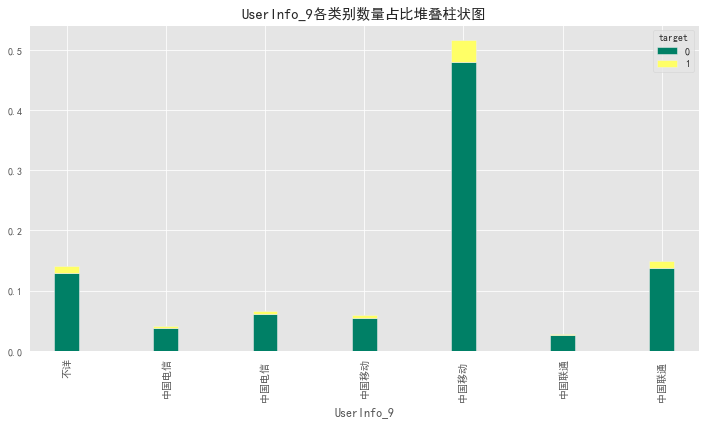

In [17]:
'''
3.3.1.1、UserInfo_9特征处理：
'''
# 利用groupby方法将UserInfo_9特征按照类别（移动、联通等）进行分组
# 利用value_counts方法分别统计每个类别中0和1的数量，将结果存入userinfo_9内
userinfo_9 = df_dataset.groupby(by='UserInfo_9')['target'].value_counts().unstack()
# 利用category_proportion_figure函数对UserInfo_9特征各类别中0和1的数量进行可视化
category_proportion_figure(plot_data=userinfo_9, figsize=(12,6), title='UserInfo_9各类别数量占比堆叠柱状图')


<Figure size 432x288 with 0 Axes>

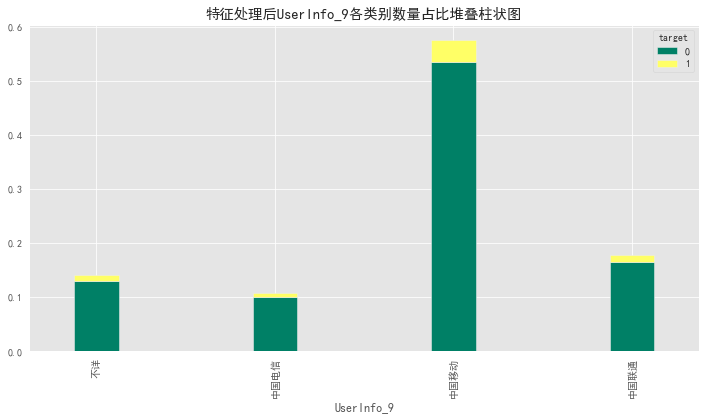

<Figure size 432x288 with 0 Axes>

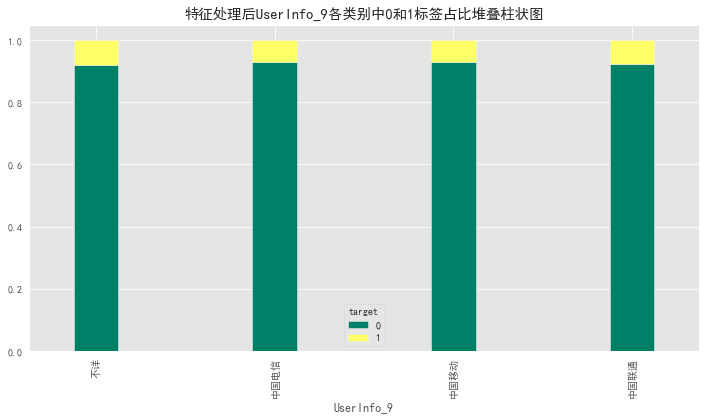

In [18]:
'''
3.3.1.1 通过分析可知:
1、UserInfo9特征里的类别，例如‘中国移动’、‘中国移动 ’，这两个其实属于同一类别，需要对特征名称清洗，去掉空格
2、对于‘不详’，将该类别数据视为缺失数据，同样将其视为一个类别
3、接下来需要对特征数据进行清洗，并重新可视化结果

清洗后的UserInfo9可视化结果：
1、中国移动占比最多，超过55%，中国联通、中国电信的占比都在20%以下
2、3个类别中0和1的占比与项目开头计算的样本0和1的总体占比保持一致
'''
# 利用replace方法去除UserInfo_9内所有数据的空格
df_dataset['UserInfo_9'] = df_dataset['UserInfo_9'].str.replace(' ', '')
# 重新对UserInfo_9内每个类别中0和1的数量进行统计，并将结果重新存入userinfo_9
userinfo_9 = df_dataset.groupby(by='UserInfo_9')['target'].value_counts().unstack()
# 利用category_proportion_figure函数，重新对清洗后的UserInfo_9特征各类别中0和1的数量进行可视化
category_proportion_figure(plot_data=userinfo_9, figsize=(12,6), title='特征处理后UserInfo_9各类别数量占比堆叠柱状图')
# 利用target_proportion_figure函数，重新对清洗后的UserInfo_9特征各类别中0和1的比例进行可视化
target_proportion_figure(plot_data=userinfo_9, figsize=(12,6), title='特征处理后UserInfo_9各类别中0和1标签占比堆叠柱状图')

<Figure size 432x288 with 0 Axes>

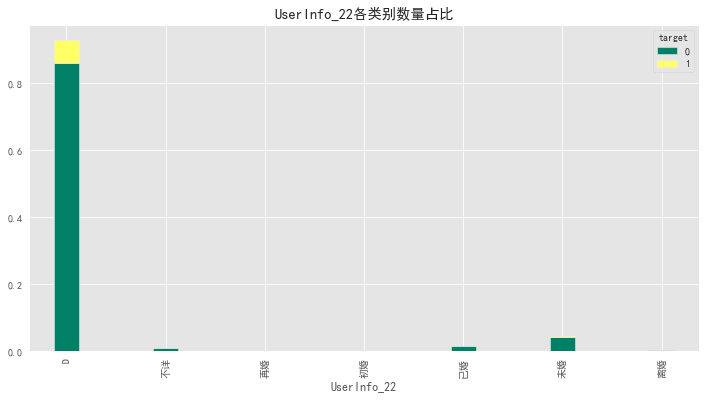

<Figure size 432x288 with 0 Axes>

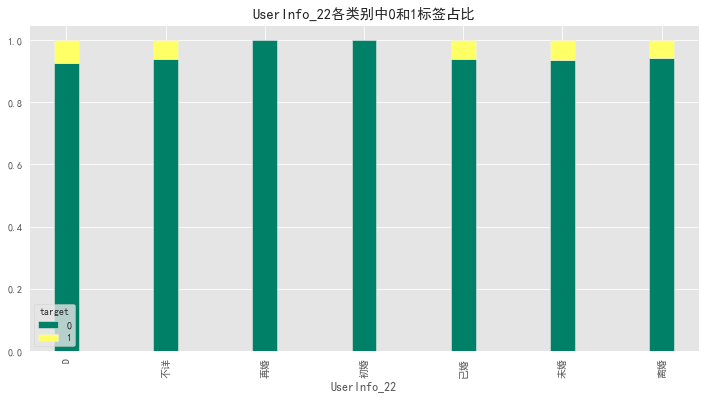

<Figure size 432x288 with 0 Axes>

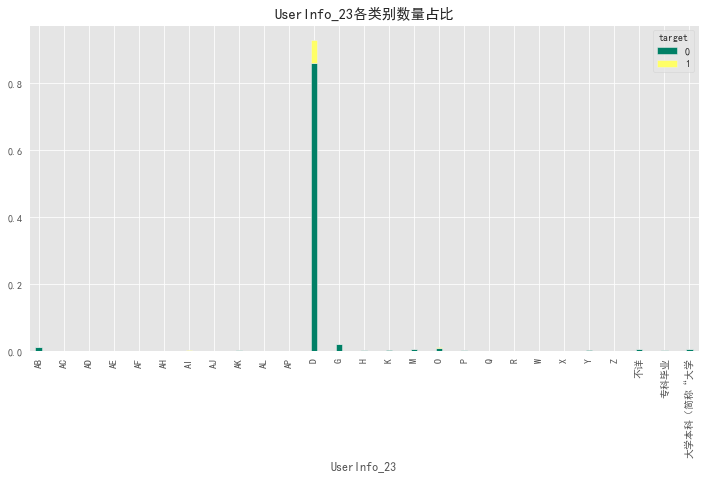

<Figure size 432x288 with 0 Axes>

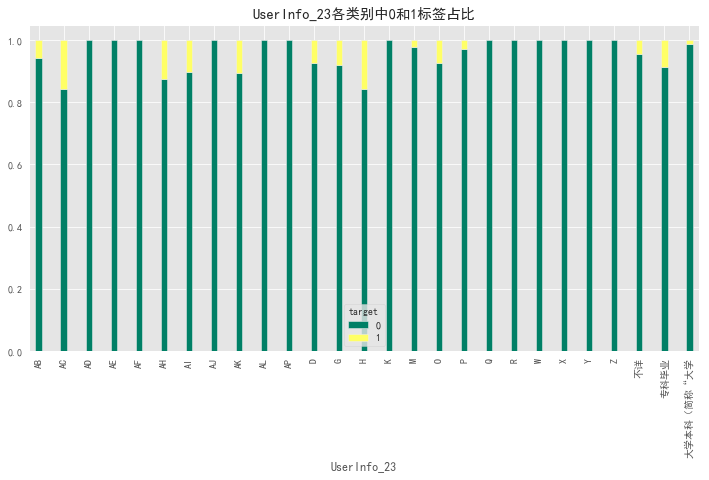

In [19]:

'''
3.3.1.2 UserInfo22、23特征分析:
通过可视化展示可知:
这两个特征中，‘D’占比都非常高，超过90%
'''
# 创建列表userlist，存储UserInfo_22、23两个特征名称
userlist = ['UserInfo_22', 'UserInfo_23']
# 利用figures_in_featurelist函数可视化UserInfo_22、23两个特征的类别分布
figures_in_featurelist(featurelist=userlist, name='userinfo_')


In [20]:
'''
3.3.1.2 UserInfo24特征分析:
通过对UserInfo_24特征按照类别进行分组，使用value_counts方法分别统计每个类别中0和1的数量,统计结果:

'''
# 利用groupby方法将UserInfo_24特征按照类别进行分组，value_counts方法分别统计每个类别中0和1的数量，将结果存入userinfo_24内
userinfo_24 = df_dataset.groupby(by='UserInfo_24')['target'].value_counts().unstack()
# 展示UserInfo_24内类别数量
print('UserInfo_24特征的类别数量是:{}'.format(len(df_dataset['UserInfo_24'].unique())))
# 展示结果
userinfo_24.head(20)


UserInfo_24特征的类别数量是:1963


target              0        1
UserInfo_24                   
D           25802.000 2065.000
万福镇象山村          1.000      nan
万通城5幢401        1.000      nan
上海市嘉定区嘉定镇       1.000      nan
上海市奉贤区四团镇       1.000      nan
上海市奉贤区庄行镇       1.000      nan
上海市宝山区          1.000      nan
上海市徐汇区          1.000      nan
上海市普陀区          1.000      nan
上海市普陀区大渡河路      1.000      nan
上海市杨浦区          1.000      nan
上海市杨浦区开鲁一村        nan    1.000
上海市浦东新区         4.000      nan
上海市金山区          2.000      nan
上海市长宁区古北路       1.000      nan
上海市长宁区镇宁路       1.000      nan
上海市闸北区芷江西路        nan    1.000
上海市青浦区          1.000      nan
上海市青浦区外青松公路     1.000      nan
上海市黄浦区瑞金二路      1.000      nan

<Figure size 432x288 with 0 Axes>

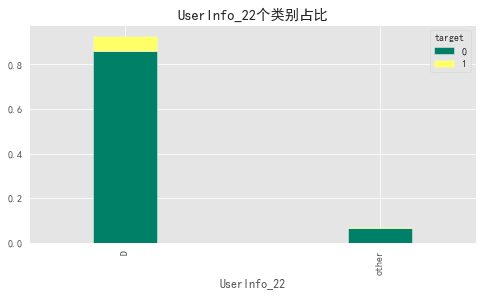

<Figure size 432x288 with 0 Axes>

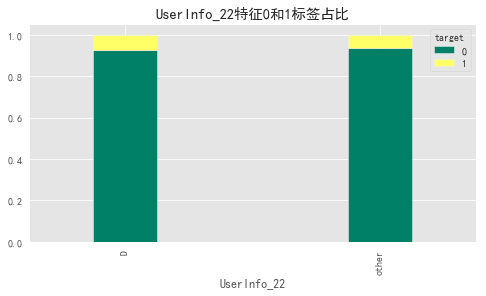

<Figure size 432x288 with 0 Axes>

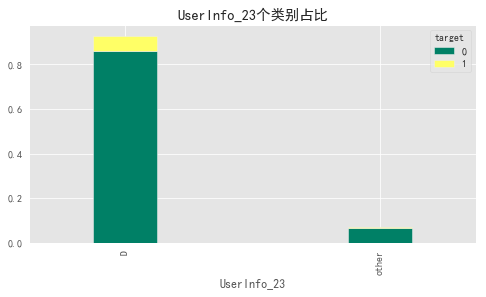

<Figure size 432x288 with 0 Axes>

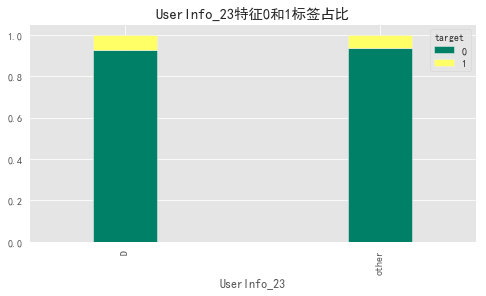

<Figure size 432x288 with 0 Axes>

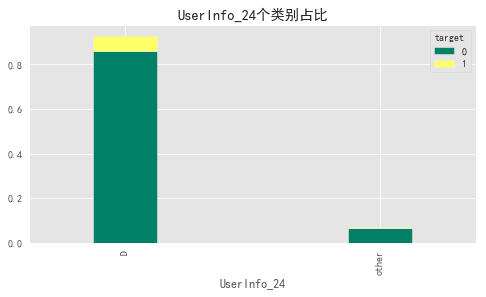

<Figure size 432x288 with 0 Axes>

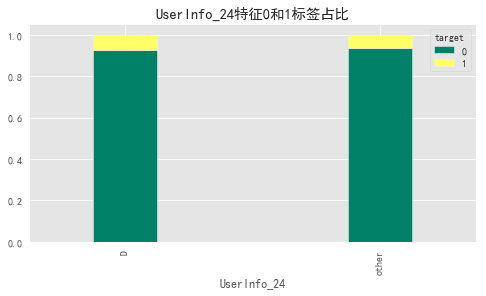

In [21]:
'''
3.3.1.2 统计结果:
UserInfo_24:
(1) 特征共有1963个类别
(2) D类别总数超过27000+，占比超过90%，占比过大
(3) 除去D类别，其余的1962个类别的数量只有不超过3000个，平均每个类别的数量不超过2个
(4) 考虑到该特征中类别过多(一个特征有1900+个类别)，某一个类别的数量占比过大(超过90%)，并且其他类别数量少，类别多，因此
    做合并处理，D视为一类，其他所有类别视为另外一类
UserInfo_22、23:
由于UserInfo_22、23同样存在D类别占比超过90%，其余特征占比过低的情况，同样对这两个特征进行转换
    
特征处理结果:
特征处理后的UserInfo_24可视化结果:‘D’中0的比例略低于other
'''
# 利用numpy的where方法，处理UserInfo_22数据：‘D’类别保持不变，其他类别全部设为‘other’
df_dataset['UserInfo_22'] = np.where(df_dataset['UserInfo_22']=='D', 'D', 'other')
# 对处理后的UserInfo_22特征进行分类统计0和1的标签，并将数据存入userinfo_22
userinfo_22 = df_dataset.groupby(by='UserInfo_22')['target'].value_counts().unstack()
# 使用category_proportion_figure函数对处理后的特征可视化
category_proportion_figure(plot_data=userinfo_22, figsize=(8,4), title='UserInfo_22个类别占比')
# 使用target_proportion_figure函数对处理后的特征可视化
target_proportion_figure(plot_data=userinfo_22, figsize=(8,4), title='UserInfo_22特征0和1标签占比')

# 利用numpy的where方法，处理UserInfo_23数据：‘D’类别保持不变，其他类别全部设为‘other’
df_dataset['UserInfo_23'] = np.where(df_dataset['UserInfo_23']=='D', 'D', 'other')
# 对处理后的UserInfo_23特征进行分类统计0和1的标签，并将数据存入userinfo_23
userinfo_23= df_dataset.groupby(by='UserInfo_23')['target'].value_counts().unstack()
# 使用category_proportion_figure函数对处理后的特征可视化
category_proportion_figure(plot_data=userinfo_23, figsize=(8,4), title='UserInfo_23个类别占比')
# 使用target_proportion_figure函数对处理后的特征可视化
target_proportion_figure(plot_data=userinfo_23, figsize=(8,4), title='UserInfo_23特征0和1标签占比')

# 利用numpy的where方法，处理UserInfo_24数据：‘D’类别保持不变，其他类别全部设为‘other’
df_dataset['UserInfo_24'] = np.where(df_dataset['UserInfo_24']=='D', 'D', 'other')
# 对处理后的UserInfo_24特征进行分类统计0和1的标签，并将数据存入userinfo_24
userinfo_24 = df_dataset.groupby(by='UserInfo_24')['target'].value_counts().unstack()
# 使用category_proportion_figure函数对处理后的特征可视化
category_proportion_figure(plot_data=userinfo_24, figsize=(8,4), title='UserInfo_24个类别占比')
# 使用target_proportion_figure函数对处理后的特征可视化
target_proportion_figure(plot_data=userinfo_24, figsize=(8,4), title='UserInfo_24特征0和1标签占比')

In [22]:
'''
3.3.1.3 UserInfo_2、4、7、8、19、20特征分析:
1、以上6个特征全部为地理位置信息
2、UserInfo_2、4、8、20为城市信息，7、19为省份信息
3、数据内‘广东’、‘广东省’和‘北京’、‘北京市’含义相同，需要做数据处理
4、对于城市信息:
4.1、对一些‘奇怪的城市’修正为标准名称(绝大多数都是少数民族地区)
4.2、添加城市等级分类(1线、2线等)特征
4.3、添加每个城市的经纬度信息特征，实现把城市信息从300+类别型特征转换为连续型数值特征
4.4、添加城市之间距离特征
5、对于省份信息:
5.1、添加新特征，对两个省份特征比较，类别为‘相同’和‘不同’
5.2、对各省份按照地区(东北、华北、西北等)分类,将30+的类别信息转换成8个类别的信息
'''

'''
3.3.1.3.1:数据清洗:
清洗UserInfo_8内特殊符号(‘、’、‘-’、‘ ’等)
UserInfo_2、4、8、20特征内的'省'、'市'等去掉，并将一些‘奇怪的’城市名称转换为网上(国家统计局)发布的标准名称
'''
# 使用split方法进行字符串处理，分别按照‘、’、‘-’和‘ ’将字符串拆分，并保留第1个城市名称
df_dataset['UserInfo_8'] = df_dataset['UserInfo_8'].str.split('、').str[0]
df_dataset['UserInfo_8'] = df_dataset['UserInfo_8'].str.split('-').str[0]
df_dataset['UserInfo_8'] = df_dataset['UserInfo_8'].str.split(' ').str[0]
# 创建列表user_city_list，存储城市特征
user_city_list = ['UserInfo_2', 'UserInfo_4', 'UserInfo_8', 'UserInfo_20']
# 创建strange_city_dic，存储‘奇怪的城市’(基本全部是少数民族地区)
strange_city_dic = {'襄樊':'襄阳', '黔南':'黔南布依族苗族自治州', '黔西南':'黔西南布依族苗族自治州', 
                    '黔东南':'黔东南苗族侗族自治州', '恩施':'恩施土家族苗族自治州', '凉山':'凉山彝族自治州',
                    '乌兰察布盟':'乌兰察布', '巴彦淖尔盟':'巴彦淖尔', '临夏':'临夏回族自治州', '临河':'巴彦淖尔', 
                    '伊犁':'伊犁哈萨克自治州', '克州':'克孜勒苏柯尔克孜自治州', '兴义':'黔西南布依族苗族自治州', 
                    '凯里':'黔东南苗族侗族自治州', '博乐':'博尔塔拉蒙古自治州', '古乌海':'乌海', '古包头':'包头',
                    '古兴安盟':'兴安盟', '古赤峰':'赤峰', '吉首':'湘西土家族苗族自治州', '大理':'大理白族自治州', 
                    '奎屯':'伊犁哈萨克自治州', '巴音郭楞':'巴音郭楞蒙古自治州', '库尔勒':'巴音郭楞蒙古自治州', 
                    '延吉':'延边朝鲜族自治州', '延边':'延边朝鲜族自治州', '德宏':'德宏傣族景颇族自治州', '思茅':'普洱',
                    '怒江':'怒江傈僳族自治州', '楚雄':'楚雄彝族自治州', '江汉':'武汉', '海北':'海北藏族自治州', 
                    '海拉尔':'呼伦贝尔', '海西':'海西蒙古族藏族自治州', '涪陵':'重庆', '万州':'重庆', '潢川':'信阳', 
                    '甘南':'甘南藏族自治州', '甘孜':'甘孜藏族自治州', '红河':'红河哈尼族彝族自治州', '西双版纳':'西双版纳傣族自治州',
                    '西昌':'凉山彝族自治州', '迪庆':'迪庆藏族自治州', '都匀':'黔南布依族苗族自治州', '锡林浩特':'锡林郭勒盟', 
                    '阿坝':'阿坝藏族羌族自治州', '集宁':'乌兰察布', '黔江':'重庆', '文山':'文山壮族苗族自治州', 
                    '昌吉':'昌吉回族自治州', '果洛':'果洛藏族自治州', '格尔木':'海西蒙古族藏族自治州', 
                    '尔塔拉蒙古自治州':'博尔塔拉蒙古自治州', '犁哈萨克自治州':'伊犁哈萨克自治州'}
# 遍历user_city_list内每个特征名称
for i in user_city_list:
    # 使用replace方法去掉‘市’和‘地区’
    df_dataset[i] = df_dataset[i].str.replace('市', '')
    df_dataset[i] = df_dataset[i].str.replace('地区', '')
    # 遍历strange_city_dic内每个键
    for city in strange_city_dic.keys():
        # 使用numpy的where方法，修正各‘奇怪的’城市名称
        df_dataset[i] = np.where(df_dataset[i]==city, strange_city_dic[city], df_dataset[i])        
# 利用replace方法进行字符串处理，去除UserInfo_7、19内所有省份的‘省’和直辖市的‘市’
df_dataset['UserInfo_7'] = df_dataset['UserInfo_7'].str.replace('省', '')
df_dataset['UserInfo_7'] = df_dataset['UserInfo_7'].str.replace('市', '')
df_dataset['UserInfo_19'] = df_dataset['UserInfo_19'].str.replace('省', '')
df_dataset['UserInfo_19'] = df_dataset['UserInfo_19'].str.replace('市', '')
# 利用replace方法进行字符串处理，将UserInfo_19内的‘西藏自治区’、‘广西壮族自治区’等少数民族省份转换为‘西藏’、‘广西’
df_dataset['UserInfo_19'] = df_dataset['UserInfo_19'].str.replace('广西壮族自治区', '广西')
df_dataset['UserInfo_19'] = df_dataset['UserInfo_19'].str.replace('西藏自治区', '西藏')
df_dataset['UserInfo_19'] = df_dataset['UserInfo_19'].str.replace('内蒙古自治区', '内蒙古')
df_dataset['UserInfo_19'] = df_dataset['UserInfo_19'].str.replace('宁夏回族自治区', '宁夏')
df_dataset['UserInfo_19'] = df_dataset['UserInfo_19'].str.replace('新疆维吾尔自治区', '新疆')
# 创建列表userinfo_location_list，存储地理位置信息特征的名称
userinfo_location_list = ['UserInfo_2', 'UserInfo_4', 'UserInfo_7',
                          'UserInfo_8', 'UserInfo_19', 'UserInfo_20']
# 查看所有地理位置特征的总体数据信息
df_dataset[userinfo_location_list].describe()


UserInfo_2 UserInfo_4 UserInfo_7 UserInfo_8 UserInfo_19 UserInfo_20
count       30000      30000      30000      30000       30000       30000
unique        326        329         32        334          31         297
top            深圳         深圳         不详         不详          广东          不详
freq         1048       1112       4213       4213        2405        7173

<Figure size 432x288 with 0 Axes>

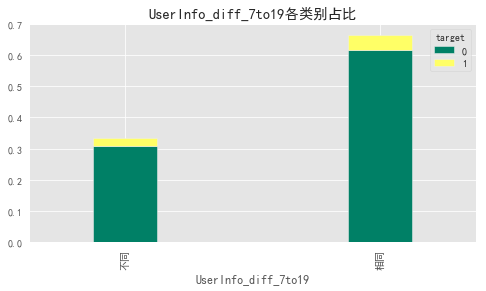

<Figure size 432x288 with 0 Axes>

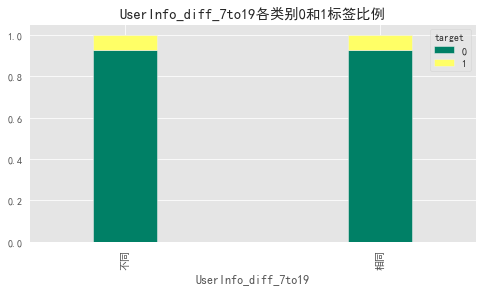

In [23]:
'''
3.3.1.3.2:地理位置特征比较(省份信息)
创建userinfo_diff函数，比较两个地理位置特征，并将比较结果存入新生成的特征内，最后可视化结果

通过比较UserInfo_7和UserInfo_19两个省份特征:
(1) 省份相同占比将近70%，UserInfo_7内有4000+‘不详’数据(占比达到17%左右)，在比较时这些不详数据比较结果都是‘不同’，实际的相同省份比例会更高
(2) '相同'与'不同'两个类别内0和1标签比例大致相同，与总体样本的标签比例一致
'''
# 创建userinfo_diff函数，比较两个地理位置特征，并将比较结果存入新特征内，最后可视化结果
def userinfo_diff(new_feature, userinfo_name1, userinfo_name2):
    '''
    该函数功能是对比两个地理位置特征，将对比结果存入新生成的特征内，并可视化对比结果
    new_feature:新生成的特征名称
    userinfo_name1、userinfo_name2:分别为两个需要比较的地理位置特征名称
    '''
    # 创建新特征new_feature，将userinfo_name1和userinfo_name2这两个信息对比，若相同则为‘相同’，不同为‘不同’
    df_dataset[new_feature] = np.where(df_dataset[userinfo_name1]==df_dataset[userinfo_name2], '相同', '不同')
    # 使用groupby方法对UserInfo_diff特征按照target分组，并通过value_counts方法统计每个组数量，将数据存入df_dffier
    df_dffier = df_dataset.groupby(by=new_feature)['target'].value_counts().unstack()
    # 使用category_proportion_figure函数可视化df_dffier每个分组数量占比
    category_proportion_figure(df_dffier, (8,4), new_feature+'各类别占比')
    # 使用target_proportion_figure函数可视化df_dffier内每个分组的0和1标签比例
    target_proportion_figure(df_dffier, (8,4), new_feature+'各类别0和1标签比例')

# 使用userinfo_diff函数对比UserInfo_7和UserInfo_9这两个省份特征，并生成新特征UserInfo_diff_7to19，最后可视化结果
userinfo_diff('UserInfo_diff_7to19', 'UserInfo_7', 'UserInfo_19')


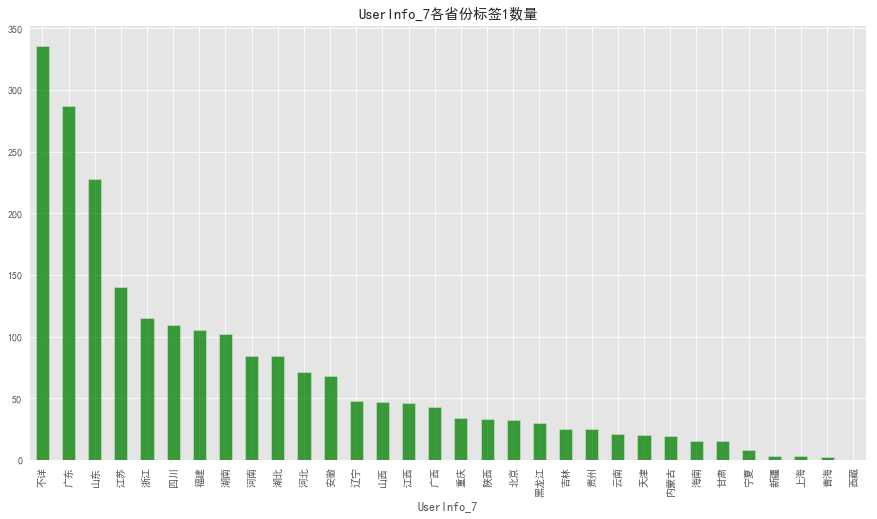

In [24]:
'''
3.3.1.3.2:省份信息分析-UserInfo_7

可视化UserInfo_7省份特征中标签1(逾期)的各省份数量:
(1) 不详(这里把不详也视为一个‘省份’)、广东、山东、江苏、浙江、四川、福建、湖南这8个省份中标签1的数量高于100
(2) 将以上8个类别做二值化处理，并创建新特征(是否广东、是否山东)
'''
# 使用groupby方法对userinfo_7特征内每个类别按照标签进行分组，并使用value_counts方法统计数量，将结果存入userinfo_7
userinfo_7 = df_dataset.groupby(by='UserInfo_7')['target'].value_counts().unstack()
# 使用sort_values函数对userinfo_7中标签1进行排序，参数scending设为False，代表降序排列，结果存入userinfo_7_sort
userinfo_7_sort = userinfo_7[1].sort_values(ascending=False)
# 使用bar_figure函数对userinfo_7_sort可视化
bar_figure(plot_data=userinfo_7_sort, title='UserInfo_7各省份标签1数量', figsize=(15,8))
# 使用where方法对标签1的数量较多的省份(数量高于100)进行二值化处理，‘是’为1，‘不是’为0，并相应地创建新特征
df_dataset['userinfo_7_不详'] = np.where(df_dataset['UserInfo_7']=='不详', 1, 0)
df_dataset['userinfo_7_广东'] = np.where(df_dataset['UserInfo_7']=='广东', 1, 0)
df_dataset['userinfo_7_山东'] = np.where(df_dataset['UserInfo_7']=='山东', 1, 0)
df_dataset['userinfo_7_江苏'] = np.where(df_dataset['UserInfo_7']=='江苏', 1, 0)
df_dataset['userinfo_7_浙江'] = np.where(df_dataset['UserInfo_7']=='浙江', 1, 0)
df_dataset['userinfo_7_四川'] = np.where(df_dataset['UserInfo_7']=='四川', 1, 0)
df_dataset['userinfo_7_福建'] = np.where(df_dataset['UserInfo_7']=='福建', 1, 0)
df_dataset['userinfo_7_湖南'] = np.where(df_dataset['UserInfo_7']=='湖南', 1, 0)

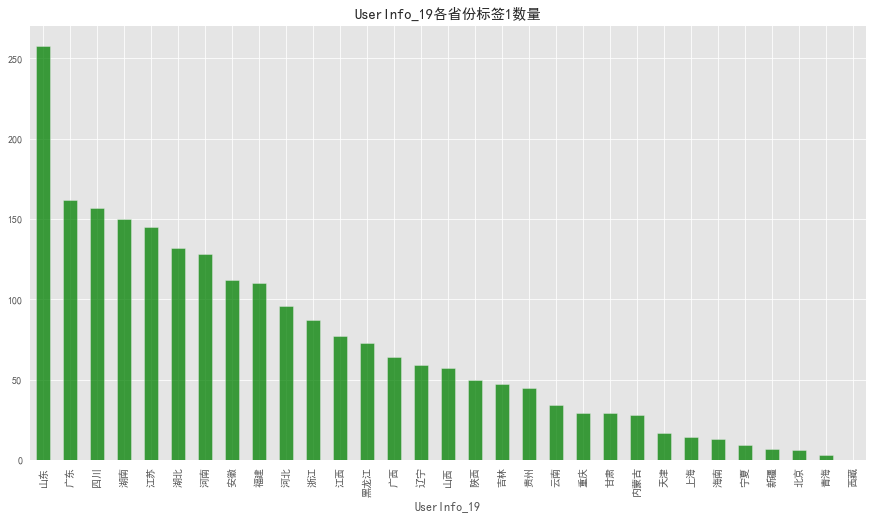

In [25]:
'''
3.3.1.3.2:省份信息分析-UserInfo_19

可视化UserInfo_19省份特征中标签1(逾期)的各省份数量:
(1) 山东、广东、四川、湖南、江苏、湖北、河南、安徽、福建这9个省份中标签1的数量高于100
(2) 将以上8个类别做二值化处理，并创建新特征(是否广东、是否山东)
'''
# 使用groupby方法对userinfo_19特征内每个类别按照标签进行分组，并使用value_counts方法统计数量，将结果存入userinfo_19
userinfo_19 = df_dataset.groupby(by='UserInfo_19')['target'].value_counts().unstack()
# 使用sort_values函数对userinfo_19中标签1进行排序，参数scending设为False，代表降序排列，结果存入userinfo_19_sort
userinfo_19_sort = userinfo_19[1].sort_values(ascending=False)
# 使用bar_figure函数对userinfo_7_sort可视化
bar_figure(plot_data=userinfo_19_sort, title='UserInfo_19各省份标签1数量', figsize=(15,8))
# 使用where方法对标签1的数量较多的省份(数量高于100)进行二值化处理，'是'为1，‘不是’为0，并相应地创建新特征
df_dataset['userinfo_19_山东'] = np.where(df_dataset['UserInfo_19']=='山东', 1, 0)
df_dataset['userinfo_19_广东'] = np.where(df_dataset['UserInfo_19']=='广东', 1, 0)
df_dataset['userinfo_19_四川'] = np.where(df_dataset['UserInfo_19']=='四川', 1, 0)
df_dataset['userinfo_19_湖南'] = np.where(df_dataset['UserInfo_19']=='湖南', 1, 0)
df_dataset['userinfo_19_江苏'] = np.where(df_dataset['UserInfo_19']=='江苏', 1, 0)
df_dataset['userinfo_19_湖北'] = np.where(df_dataset['UserInfo_19']=='湖北', 1, 0)
df_dataset['userinfo_19_河南'] = np.where(df_dataset['UserInfo_19']=='河南', 1, 0)
df_dataset['userinfo_19_安徽'] = np.where(df_dataset['UserInfo_19']=='安徽', 1, 0)
df_dataset['userinfo_19_福建'] = np.where(df_dataset['UserInfo_19']=='福建', 1, 0)

<Figure size 432x288 with 0 Axes>

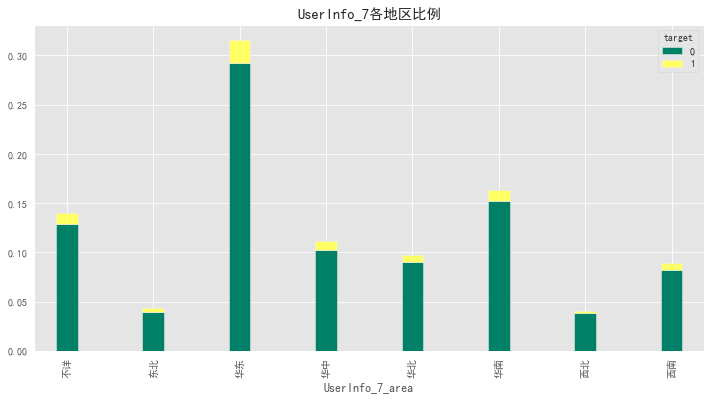

<Figure size 432x288 with 0 Axes>

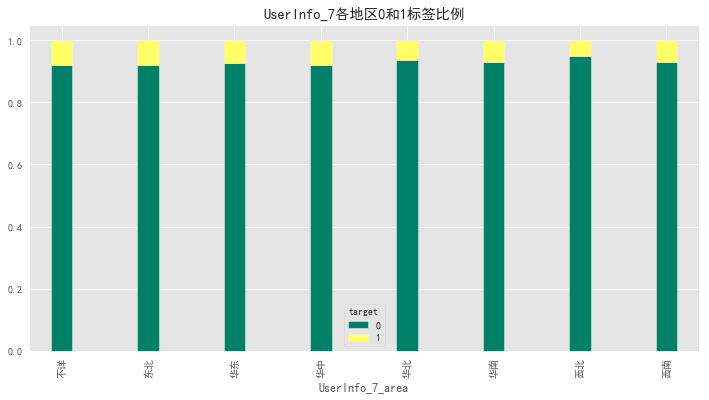

<Figure size 432x288 with 0 Axes>

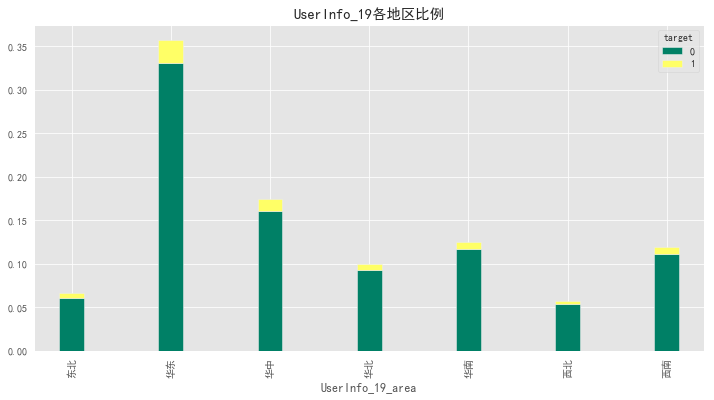

<Figure size 432x288 with 0 Axes>

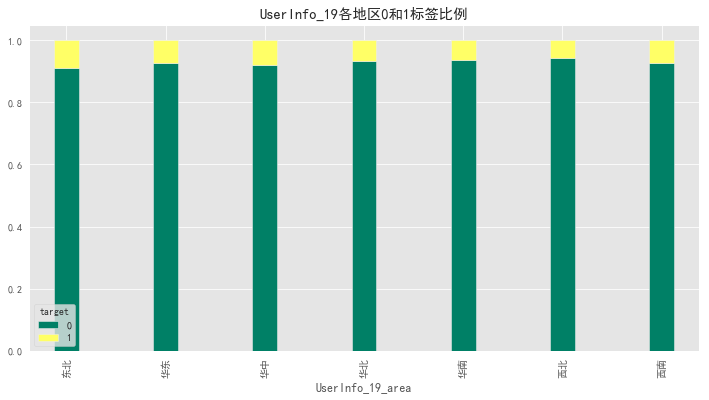

In [26]:
'''
3.3.1.3.3:新增加省份地区特征
将省份按照地区(东北、华北、西北等)分类，将30+类别降低到8个(共7各地区，加上不详后一共8个类别)
进行地区分类后，华中地区占比最多
'''
area_dic = {'广东':'华南', '广西':'华南', '海南':'华南', '辽宁':'东北', '吉林':'东北', '黑龙江':'东北',
            '河北':'华北', '山西':'华北', '内蒙古':'华北', '北京':'华北', '天津':'华北', '山东':'华东',
            '福建':'华东', '江苏':'华东', '浙江':'华东', '山东':'华东', '安徽':'华东', '江西':'华东',
            '上海':'华东', '河南':'华中', '湖南':'华中', '湖北':'华中', '陕西':'西北', '甘肃':'西北', 
            '宁夏':'西北', '新疆':'西北', '青海':'西北', '云南':'西南', '贵州':'西南', '四川':'西南', 
            '重庆':'西南', '西藏':'西南', '不详':'不详'}
# 使用map方法匹配UserInfo_7内省份地区信息，并存入UserInfo_7_area内
df_dataset['UserInfo_7_area'] = df_dataset['UserInfo_7'].map(area_dic)
# 使用map方法匹配UserInfo_19内省份地区信息，并存入UserInfo_19_area内
df_dataset['UserInfo_19_area'] = df_dataset['UserInfo_19'].map(area_dic)
# 统计UserInfo_7_area内每个类别数量，存入area_proportion_7内
area_proportion_7 = df_dataset.groupby(by='UserInfo_7_area')['target'].value_counts().unstack()
# 使用category_proportion_figure函数可视化每个类别的比例
category_proportion_figure(area_proportion_7, (12,6), 'UserInfo_7各地区比例')
# 使用target_proportion_figure函数可视化每个类别内0和1标签的比例
target_proportion_figure(area_proportion_7, (12,6), 'UserInfo_7各地区0和1标签比例')
# 统计UserInfo_19_area内每个类别数量，存入area_proportion_19内
area_proportion_19 = df_dataset.groupby(by='UserInfo_19_area')['target'].value_counts().unstack()
# 使用category_proportion_figure函数可视化每个类别的比例
category_proportion_figure(area_proportion_19, (12,6), 'UserInfo_19各地区比例')
# 使用target_proportion_figure函数可视化每个类别内0和1标签的比例
target_proportion_figure(area_proportion_19, (12,6), 'UserInfo_19各地区0和1标签比例')

<Figure size 432x288 with 0 Axes>

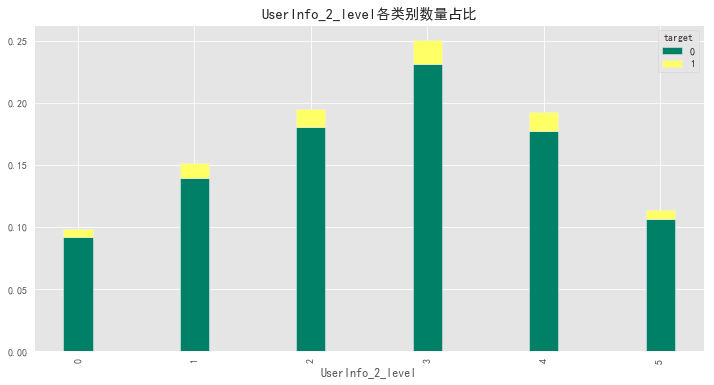

<Figure size 432x288 with 0 Axes>

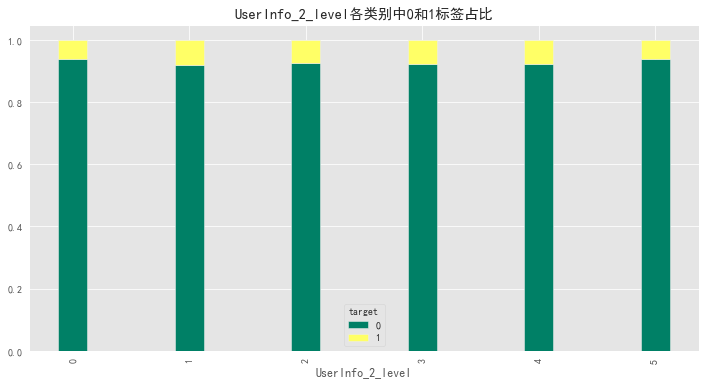

<Figure size 432x288 with 0 Axes>

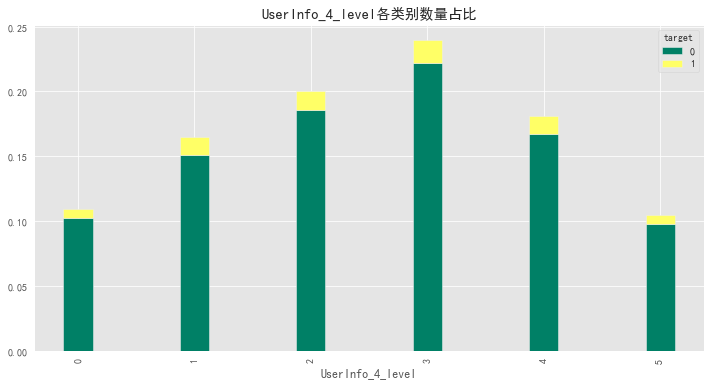

<Figure size 432x288 with 0 Axes>

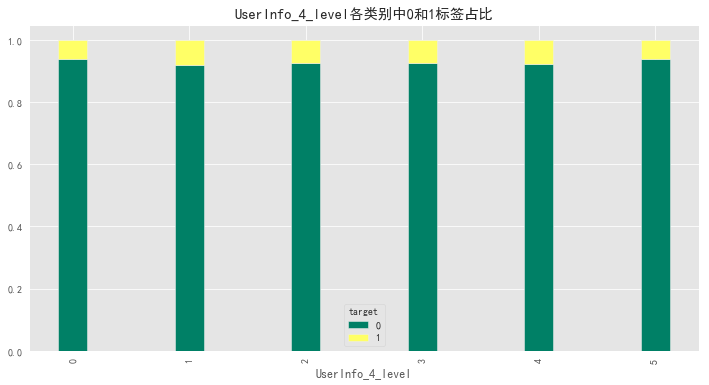

<Figure size 432x288 with 0 Axes>

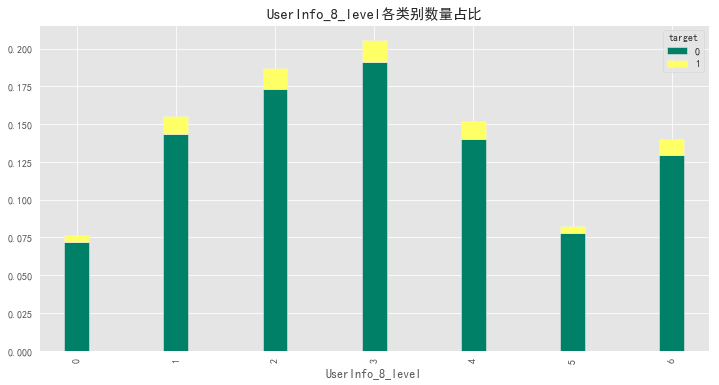

<Figure size 432x288 with 0 Axes>

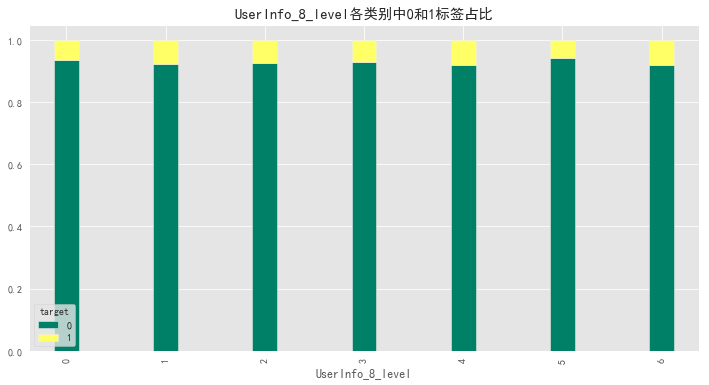

<Figure size 432x288 with 0 Axes>

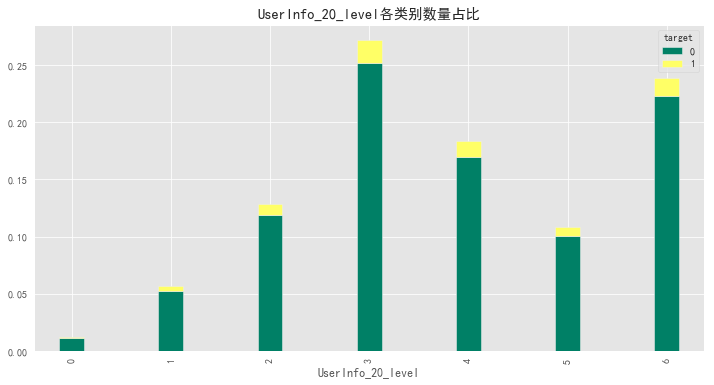

<Figure size 432x288 with 0 Axes>

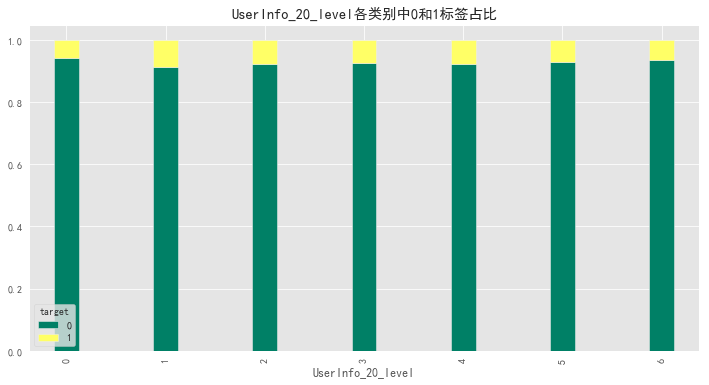

In [27]:
'''
3.3.1.3.4:增加城市等级信息:
通过describe方法查看地理位置信息可知，UserInfo_2、4、7、8这4个特征内城市种类过多，对这四个特征按照城市等级(1、2、3线城市)分类
ps:需要读取‘中国城市等级’文档(该文档是在百度上爬取的城市等级信息，存储成txt文件，爬虫具体代码没在作业里面写，直接引用的最终结果)
等级信息:一线城市为0，新一线为1，以此类推，考虑到userinfo_8和20两个特征内‘不详’较多，在文件内增加‘不详’，值为6

通过对城市等级信息可视化后可知，3线城市占比最多
'''
# 创建字典city_level_dic，存储城市等级信息，键为城市名，值为等级
city_level_dic = {}
# 读取文件
file_city_level = open('data/中国城市等级.txt', encoding='utf-8')
# 从第二行开始，遍历文件中每一行(第一行是表头)
for line in file_city_level.readlines()[1:]:
    # 使用strip函数去掉换行符\n
    line = line.strip('\n')
    # 使用split函数提取城市名称，使用replace函数去除‘市’和‘地区’
    city = line.split('\t')[0].replace('市', '')
    city = city.replace('地区', '')
    # 提取城市等级信息
    level = line.split('\t')[1]
    # 将信息存入city_level_dic内
    city_level_dic[city] = level
# 创建user_city_list，存储新生成的城市等级特征
new_feature_list = []
# 遍历user_city_list内每个特征名称
for feature in user_city_list:
    # 构建新生成的特征名称
    new_feature = feature + '_level'
    # 使用map方法对城市信息与city_level_dic内的城市等级匹配，将结果存入新生成的特征内
    df_dataset[new_feature] = df_dataset[feature].map(city_level_dic)
    # 将匹配不上的城市(通过查看结果，全部都是偏僻的5线城市)替换为‘5’
    df_dataset[new_feature] = np.where(df_dataset[new_feature].isnull(), '5', df_dataset[new_feature])
    # 将新特征名存入new_feature_list   
    new_feature_list.append(new_feature)
# 使用figures_in_featurelist函数对new_feature_list内特征可视化结果
figures_in_featurelist(new_feature_list, 'userinfolevel')

In [28]:
'''
3.3.1.3.5:增加城市经纬度信息:
对由于UserInfo_2、4、8、20这4个特征内城市种类过多，加入城市经纬度信息，取代原来城市名称，实现将城市类别信息转换成数值信息
ps:需要读取‘中国城市经纬度’文档(该文档同样是在网上爬取的城市经纬度信息，存储成txt文件，直接引用最终结果)
对于UserInfo_8和UserInfo_20，由于有‘不详’存在，在创建新特征后，无法匹配到经纬度信息，在新特征内都是空值,将空值设为0
'''
# 读取文件
file_city_location = open('data/中国城市经纬度.txt', encoding='utf-8')
# 创建dic_city_log字典，存储每个城市的经度，键为城市名，值为经度值
dic_city_log = {}
# 创建dic_city_lat字典，存储每个城市的维度，键为城市名，值为纬度值
dic_city_lat = {}
# 遍历每个城市信息
for line in file_city_location.readlines()[1:]:
    # 使用strip函数去掉每行的换行符
    line = line.strip('\n')
    # 使用split函数拆分数据，提取城市名称，存入city
    city = line.split('\t')[0]
    # 使用split函数拆分数据，提取经度数据，转换为float类型后存入log
    log = float(line.split('\t')[1])
    # 使用split函数拆分数据，提取纬度数据，转换为float类型后存入lat
    lat = float(line.split('\t')[-1])
    # 将log存入dic_city_log,键为城市名，值为经度值
    dic_city_log[city] = log
    # 将lat存入dic_city_lat,键为城市名，值为纬度值
    dic_city_lat[city] = lat
# 遍历user_city_list内每个特征名称
for feature in user_city_list:
    # 创建新特征，代表原特征内城市的经度值，特征名为原来的特征名后加'_log' 
    new_feature_log = feature + '_log'
    # 创建新特征，代表原特征内城市的纬度值，特征名为原来的特征名后加'_lat'
    new_feature_lat = feature + '_lat'
    # 使用map方法匹配城市经度信息，并存入新特征内
    df_dataset[new_feature_log] = df_dataset[feature].map(dic_city_log)
    # 使用map方法匹配城市纬度信息，并存入新特征内
    df_dataset[new_feature_lat] = df_dataset[feature].map(dic_city_lat)
# 使用numpy的where方法将UserInfo_8创建出的两个新特征内的空值替换为0
df_dataset['UserInfo_8_log'] = np.where(df_dataset['UserInfo_8_log'].isnull(), 0, df_dataset['UserInfo_8_log'])
df_dataset['UserInfo_8_lat'] = np.where(df_dataset['UserInfo_8_lat'].isnull(), 0, df_dataset['UserInfo_8_lat'])
# 使用numpy的where方法将UserInfo_20创建出的两个新特征内的空值替换为0
df_dataset['UserInfo_20_log'] = np.where(df_dataset['UserInfo_20_log'].isnull(), 0, df_dataset['UserInfo_20_log'])
df_dataset['UserInfo_20_lat'] = np.where(df_dataset['UserInfo_20_lat'].isnull(), 0, df_dataset['UserInfo_20_lat'])


In [29]:
'''
3.3.1.3.6:增加两个城市特征之间距离:
通过创建新特征后，将城市特征由类别型(仅有城市名称)转换为数值型(加入城市经纬度信息)，计算两个特征之间距离，
若两个特征之间距离为0，说明这两个特征的城市信息相同，反之为不同
'''
# 计算UserInfo_2和UserInfo_4之间距离
df_dataset['UserInfo_2to4_dis'] = np.sqrt((df_dataset['UserInfo_2_lat']-df_dataset['UserInfo_4_lat'])**2 
                                  + (df_dataset['UserInfo_2_log']-df_dataset['UserInfo_4_log'])**2)
# 计算UserInfo_2和UserInfo_8之间距离
df_dataset['UserInfo_2to8_dis'] = np.sqrt((df_dataset['UserInfo_2_lat']-df_dataset['UserInfo_8_lat'])**2 
                                  + (df_dataset['UserInfo_2_log']-df_dataset['UserInfo_8_log'])**2)
# 计算UserInfo_2和UserInfo_20之间距离
df_dataset['UserInfo_2to20_dis'] = np.sqrt((df_dataset['UserInfo_2_lat']-df_dataset['UserInfo_20_lat'])**2 
                                   + (df_dataset['UserInfo_2_log']-df_dataset['UserInfo_20_log'])**2)
# 计算UserInfo_4和UserInfo_8之间距离
df_dataset['UserInfo_4to8_dis'] = np.sqrt((df_dataset['UserInfo_4_lat']-df_dataset['UserInfo_8_lat'])**2 
                                  + (df_dataset['UserInfo_4_log']-df_dataset['UserInfo_8_log'])**2)
# 计算UserInfo_4和UserInfo_20之间距离
df_dataset['UserInfo_4to20_dis'] = np.sqrt((df_dataset['UserInfo_4_lat']-df_dataset['UserInfo_20_lat'])**2 
                                   + (df_dataset['UserInfo_4_log']-df_dataset['UserInfo_20_log'])**2)
# 计算UserInfo_8和UserInfo_20之间距离
df_dataset['UserInfo_8to20_dis'] = np.sqrt((df_dataset['UserInfo_8_lat']-df_dataset['UserInfo_20_lat'])**2 
                                   + (df_dataset['UserInfo_8_log']-df_dataset['UserInfo_20_log'])**2)


<Figure size 432x288 with 0 Axes>

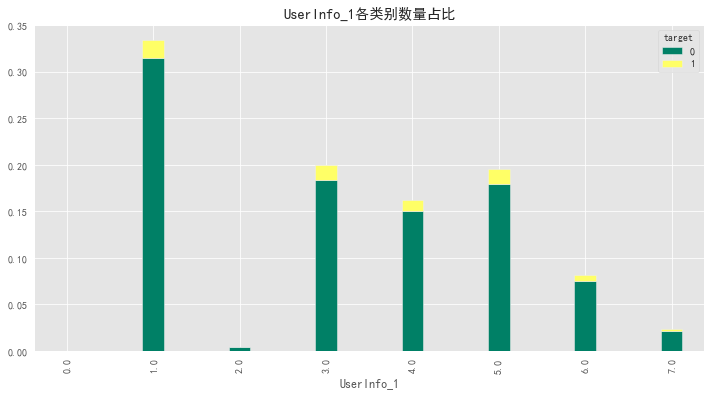

<Figure size 432x288 with 0 Axes>

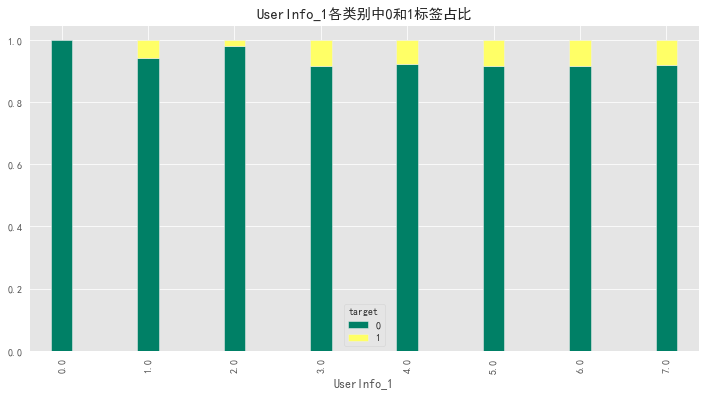

<Figure size 432x288 with 0 Axes>

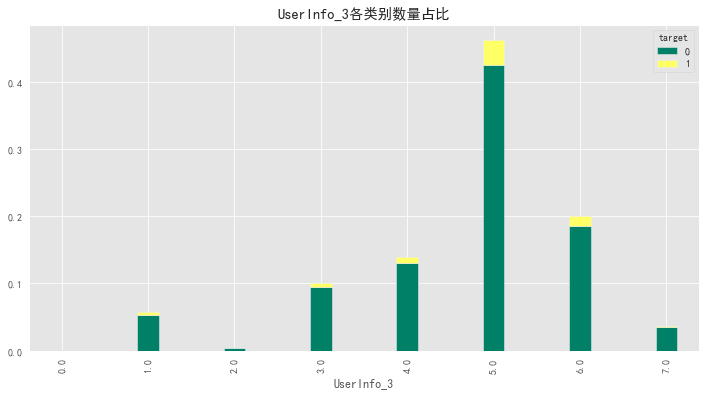

<Figure size 432x288 with 0 Axes>

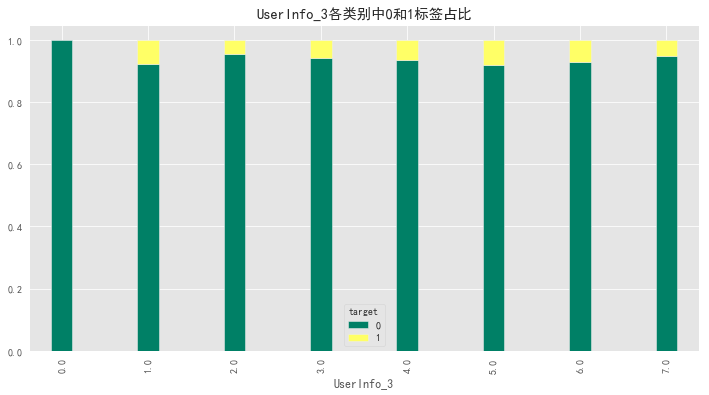

<Figure size 432x288 with 0 Axes>

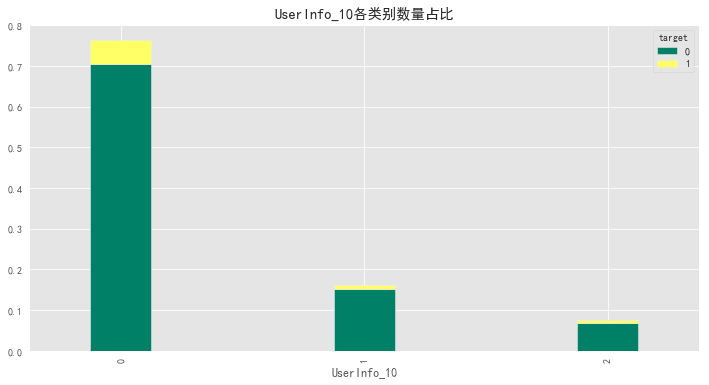

<Figure size 432x288 with 0 Axes>

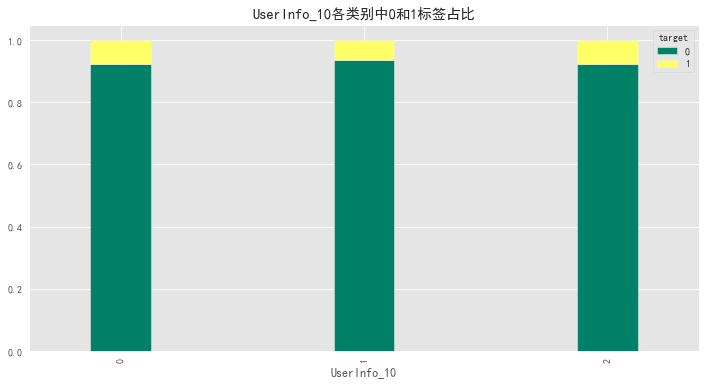

<Figure size 432x288 with 0 Axes>

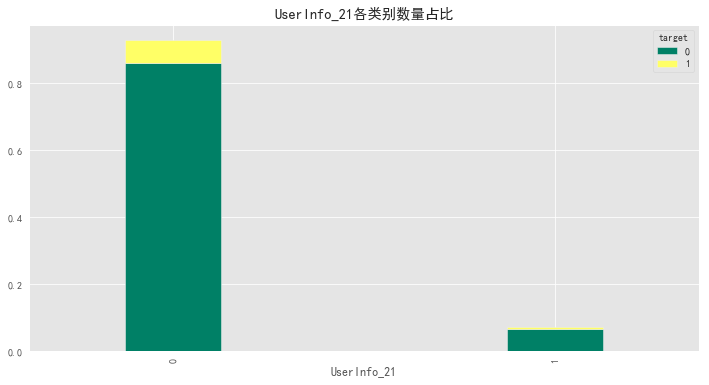

<Figure size 432x288 with 0 Axes>

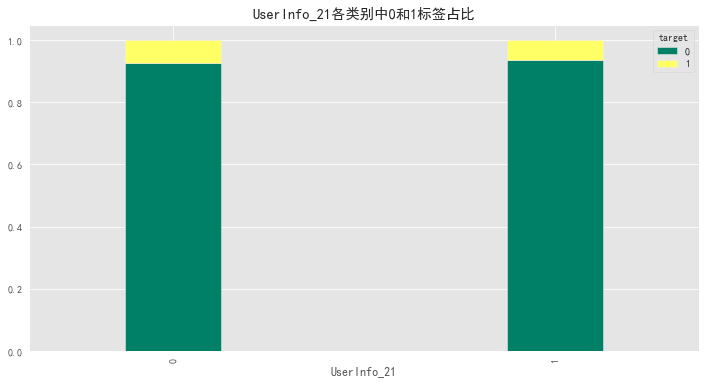

<Figure size 432x288 with 0 Axes>

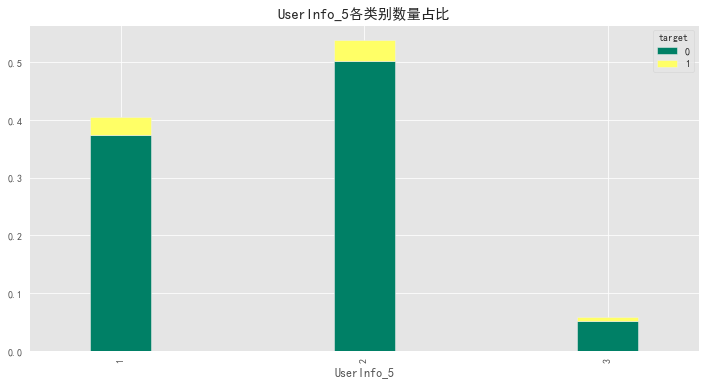

<Figure size 432x288 with 0 Axes>

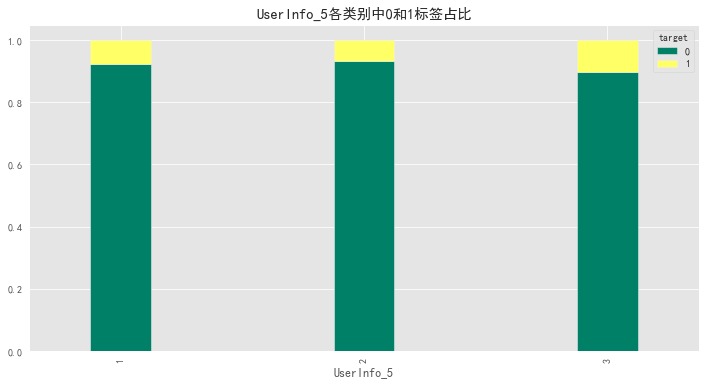

<Figure size 432x288 with 0 Axes>

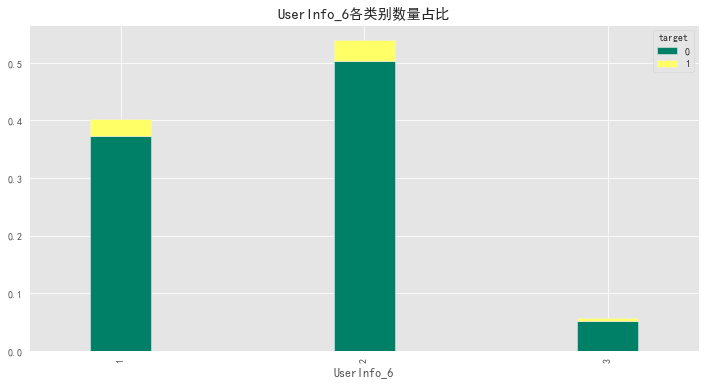

<Figure size 432x288 with 0 Axes>

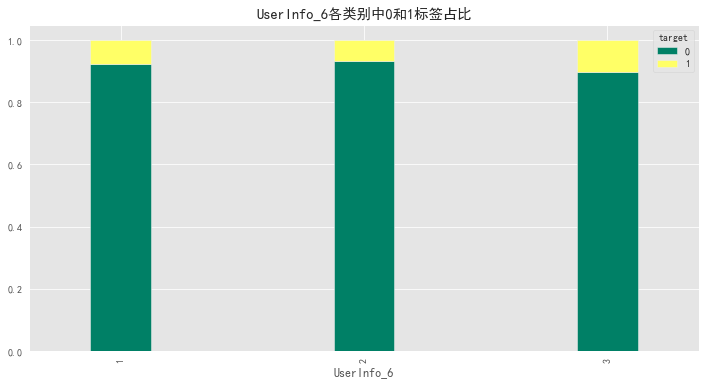

<Figure size 432x288 with 0 Axes>

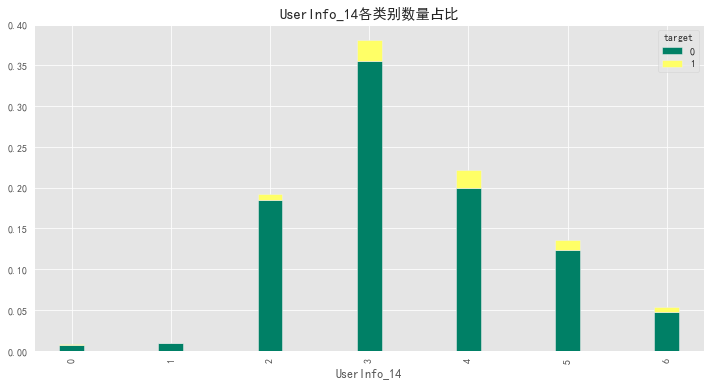

<Figure size 432x288 with 0 Axes>

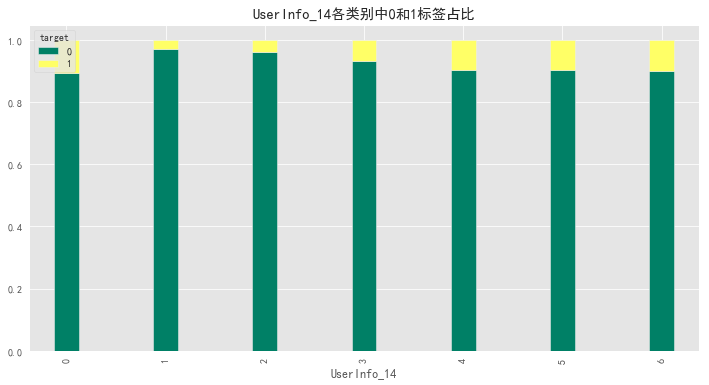

<Figure size 432x288 with 0 Axes>

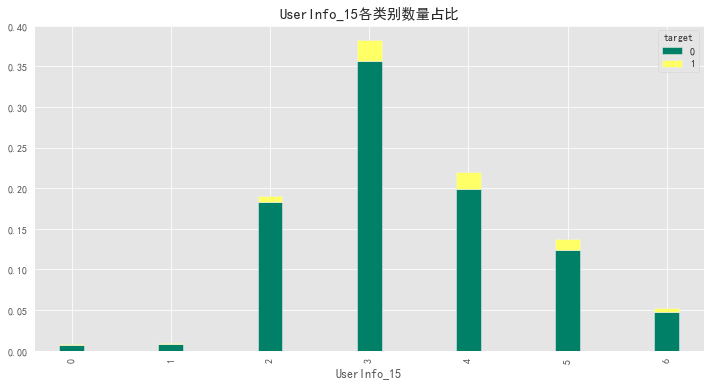

<Figure size 432x288 with 0 Axes>

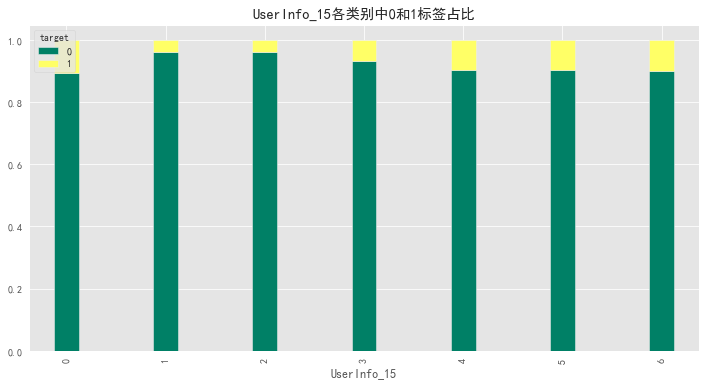

<Figure size 432x288 with 0 Axes>

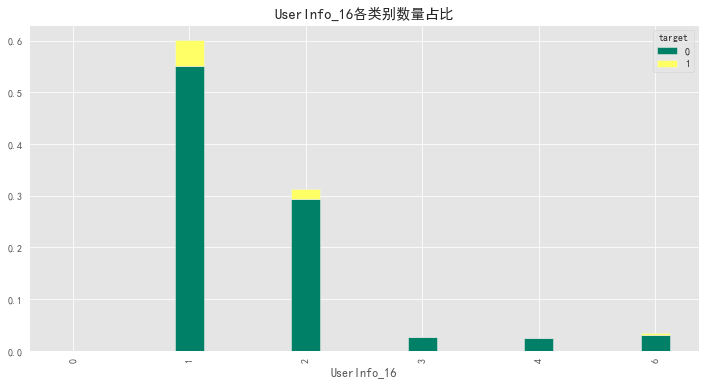

<Figure size 432x288 with 0 Axes>

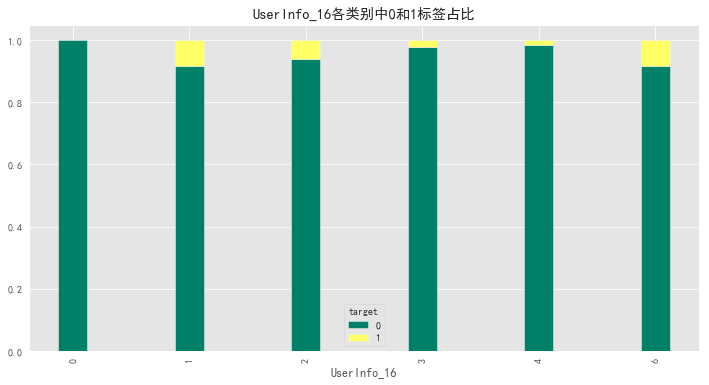

<Figure size 432x288 with 0 Axes>

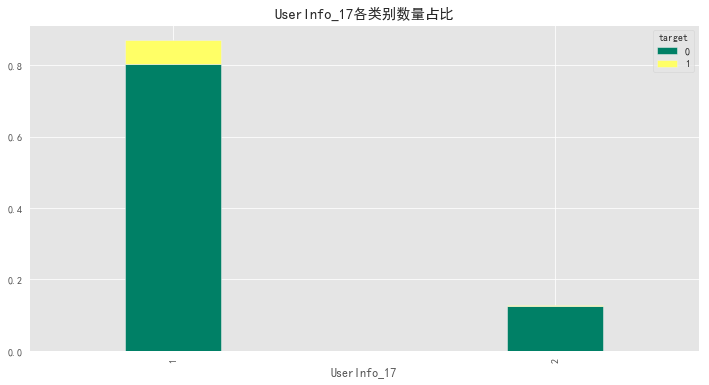

<Figure size 432x288 with 0 Axes>

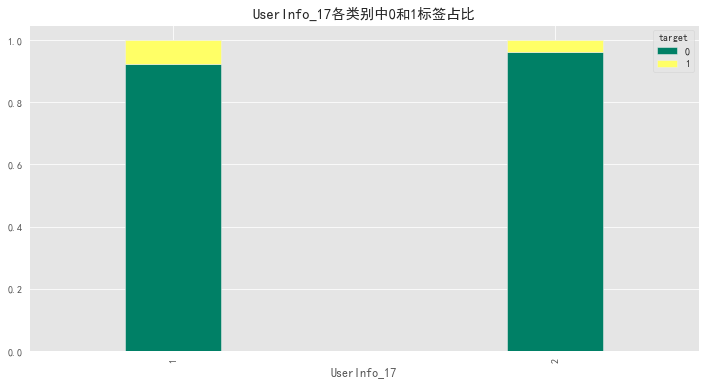

<Figure size 432x288 with 0 Axes>

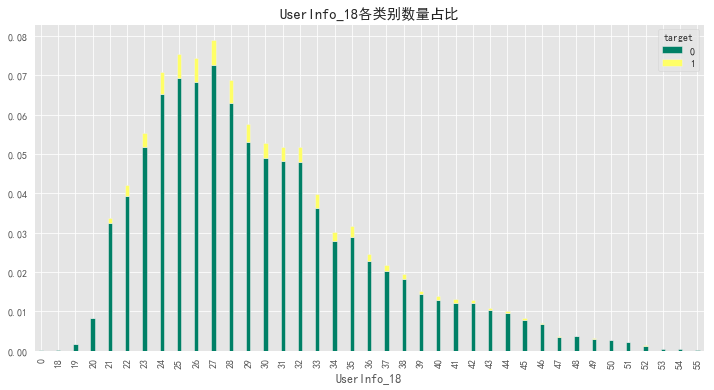

<Figure size 432x288 with 0 Axes>

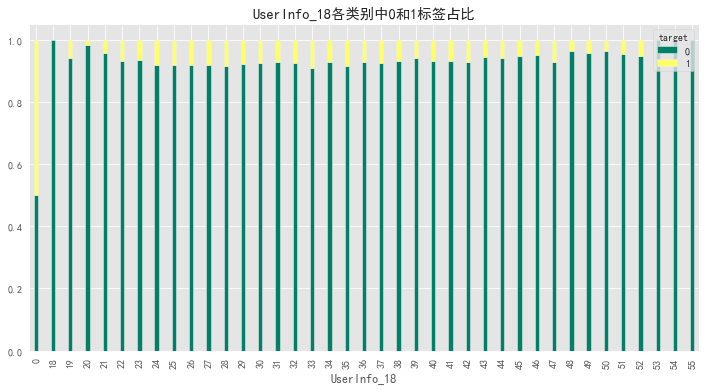

In [30]:
'''
3.3.2.1 
对于数值型特征，首先对每个特征的数值分布进行可视化展示：
'''
# 使用figures_in_featurelist函数对userinfo_numerical_list内每个数值型特征可视化处理
figures_in_featurelist(featurelist=userinfo_numerical_list, name='userinfo_')


In [31]:
'''
3.3.2.1 
通过展示结果可知:
1、UserInfo_17、UserInfo_21两个特征中分别只有2个数值，分别为0、1和1、2
2、UserInfo_5、6、10这3个特征分别有3个数值，为0、1、2和1、2、3
3、UserInfo1、3、14、15、16这5个特征中分别有6和7个数值(例如0、1、2、3、4、5、6)
4、综合1、2、3，以上的数值型特征内，每个特征中数值都不超过10个，因此将以上特征转换成类别型
5、UserInfo18特征的数值较多，共有38个数值，分布趋势明显
'''
# 由于userinfo_numerical_list内除了UserInfo_18外，剩下所有特征都需要转换成类别型，因此先在列表内去除UserInfo18
del userinfo_numerical_list[-1]
# 遍历userinfo_numerical_list每个特征名称
for i in userinfo_numerical_list:
    # 使用astype方法把特征类型转换为str
    df_dataset[i] = df_dataset[i].astype(str)


In [32]:
'''
3.4 特征处理
(1) 将UserInfo特征内，所有类别型特征进行独热编码转换
(2) 删除原有的地理位置特征
'''
# 使用drop方法删除地理位置信息的原始特征
df_dataset.drop(userinfo_location_list, axis=1, inplace=True)
# 创建user_dummies_list，存储需要进行独热编码转换的特征名
user_dummies_list = ['UserInfo_1', 'UserInfo_10', 'UserInfo_14', 'UserInfo_15', 'UserInfo_16', 'UserInfo_17', 
                    'UserInfo_19_area', 'UserInfo_2_level', 'UserInfo_20_level', 'UserInfo_21', 'UserInfo_22', 
                    'UserInfo_23', 'UserInfo_24', 'UserInfo_3', 'UserInfo_4_level', 'UserInfo_5', 'UserInfo_6', 
                    'UserInfo_7_area', 'UserInfo_8_level', 'UserInfo_9', 'UserInfo_diff_7to19']
# 使用get_dummies进行独热编码转换
df_dataset = pd.get_dummies(df_dataset, columns=user_dummies_list)
# 展示结果
df_dataset.head()

target  WeblogInfo_2  WeblogInfo_4  WeblogInfo_5  WeblogInfo_6  \
Idx                                                                     
10001       0         1.000         1.000         1.000         1.000   
10002       0         0.000         1.000         1.000         1.000   
10003       0         0.000         2.000         2.000         2.000   
10006       0         0.000         1.000         1.000         1.000   
10007       0         0.000         1.000         1.000         1.000   

       WeblogInfo_7  WeblogInfo_8  WeblogInfo_9  WeblogInfo_10  WeblogInfo_11  \
Idx                                                                             
10001            14             0             0              0              0   
10002            14             0             0              0              0   
10003             9             3             0              0              0   
10006             2             0             0              0              0   
10007             3             0             0              0              0   

       WeblogInfo_12  WeblogInfo_13  WeblogInfo_14  WeblogInfo_15  \
Idx                                                                 
10001              0              0              6              6   
10002              0              0              0              0   
10003              0              0              0              0   
10006              0              0              0              0   
10007              0              0              0              0   

       WeblogInfo_16  WeblogInfo_17  WeblogInfo_18  UserInfo_18  \
Idx                                                               
10001              0              6              2           29   
10002              7              7              0           28   
10003              3              4              2           32   
10006              0              2              0           33   
10007              0              3              0           43   

       Education_Info1 Education_Info2 Education_Info3 Education_Info4  \
Idx                                                                      
10001                0               E               E               E   
10002                0               E               E               E   
10003                0               E               E               E   
10006                0               E               E               E   
10007                0               E               E               E   

       Education_Info5 Education_Info6 Education_Info7 Education_Info8  \
Idx                                                                      
10001                0               E               E               E   
10002                0               E               E               E   
10003                0               E               E               E   
10006                0               E               E               E   
10007                0               E               E               E   

      WeblogInfo_19 WeblogInfo_20 WeblogInfo_21  WeblogInfo_23  WeblogInfo_24  \
Idx                                                                             
10001             I            I5             D          0.000          0.000   
10002             I            I5             D          0.000          0.000   
10003             I            I5             D          0.000          0.000   
10006             I            I5             D          0.000          0.000   
10007             I            I5             D          0.000          0.000   

       WeblogInfo_25  WeblogInfo_26  WeblogInfo_27  WeblogInfo_28  \
Idx                                                                 
10001          0.000          0.000          0.000          0.000   
10002          0.000          0.000          0.000          0.000   
10003          0.000          0.000          0.000          0.000   
10006          0.000  

In [33]:
'''
4、WeblogInfo特征数据处理:

4.1、查看WeblogInfo数据总体情况
在第一轮预处理中，由于WeblogInfo_1、WeblogInfo_3这2个特征缺失值过多，已经做删除处理
目前WeblogInfo特征共有WeblogInfo_2、WeblogInfo_4、WeblogInfo_5-21、WeblogInfo_23-58，共55个特征
与UserInfo特征类似:
首先，通过feature_list函数将所有的WeblogInfo特征合并到一个列表webloginfo_feature_list内
其次，利用describe方法查看所有UserInfo特征的总体信息
'''

# 创建列表，用来存储所有WeblogInfo特征名
webloginfo_feature_list = ['WeblogInfo_2', 'WeblogInfo_4']
# 利用feature_list生成WeblogInfo_5-WeblogInfo_21这17个特征名称，并合并入webloginfo_feature_list内
webloginfo_feature_list.extend(feature_list('WeblogInfo_', 5, 21))
# 利用feature_list生成WeblogInfo_23-WeblogInfo_58这36个特征名称，并合并入webloginfo_feature_list内
webloginfo_feature_list.extend(feature_list('WeblogInfo_', 23, 58))
# 通过pandas的describe方法，查看每个特征的信息
df_dataset[webloginfo_feature_list].describe(include='all')

WeblogInfo_2  WeblogInfo_4  WeblogInfo_5  WeblogInfo_6  WeblogInfo_7  \
count      30000.000     30000.000     30000.000     30000.000     30000.000   
unique           nan           nan           nan           nan           nan   
top              nan           nan           nan           nan           nan   
freq             nan           nan           nan           nan           nan   
mean           0.124         2.914         1.772         2.841        10.633   
std            0.350         3.696         1.664         3.692        16.098   
min            0.000         1.000         1.000         1.000         0.000   
25%            0.000         1.000         1.000         1.000         2.000   
50%            0.000         2.000         1.000         2.000         6.000   
75%            0.000         3.000         2.000         3.000        13.000   
max            4.000       165.000        73.000       165.000       722.000   

        WeblogInfo_8  WeblogInfo_9  WeblogInfo_10  WeblogInfo_11  \
count      30000.000     30000.000      30000.000      30000.000   
unique           nan           nan            nan            nan   
top              nan           nan            nan            nan   
freq             nan           nan            nan            nan   
mean           0.658         0.121          0.000          0.003   
std            2.622         1.338          0.000          0.185   
min            0.000         0.000          0.000          0.000   
25%            0.000         0.000          0.000          0.000   
50%            0.000         0.000          0.000          0.000   
75%            0.000         0.000          0.000          0.000   
max           81.000        46.000          0.000         18.000   

        WeblogInfo_12  WeblogInfo_13  WeblogInfo_14  WeblogInfo_15  \
count       30000.000      30000.000      30000.000      30000.000   
unique            nan            nan            nan            nan   
top               nan            nan            nan            nan   
freq              nan            nan            nan            nan   
mean            0.012          0.002          0.762          1.020   
std             0.414          0.180          4.292          2.846   
min             0.000          0.000          0.000          0.000   
25%             0.000          0.000          0.000          0.000   
50%             0.000          0.000          0.000          0.000   
75%             0.000          0.000          0.000          1.000   
max            27.000         29.000        335.000        134.000   

        WeblogInfo_16  WeblogInfo_17  WeblogInfo_18 WeblogInfo_19  \
count       30000.000      30000.000      30000.000         30000   
unique            nan            nan            nan             7   
top               nan            nan            nan             I   
freq              nan            nan            nan         24940   
mean            2.622          5.346          1.645           NaN   
std             4.749          8.221          3.552           NaN   
min             0.000          0.000          0.000           NaN   
25%             0.000          1.000          0.000           NaN   
50%             1.000          3.000          0.000           NaN   
75%             3.000          7.000          2.000           NaN   
max           182.000        356.000        136.000           NaN   

       WeblogInfo_20 WeblogInfo_21  WeblogInfo_23  WeblogInfo_24  \
count          30000         30000      30000.000      30000.000   
unique            36             4            nan            nan   
top               I5             D            nan            nan   
freq           19192         24752            nan            nan   
mean             NaN           NaN          0.007          0.353   
std              NaN           NaN          0.087          1.309   
min              NaN           NaN          0.000          0.000   
25%             

In [34]:
'''
4.2、WeblogInfo特征分类:
通过4.1查看每个WeblogInfo特征信息，可知：
WeblogInfo_19、WeblogInfo_20、WeblogInfo_21为类别型特征
WeblogInfo_2、WeblogInfo_4、WeblogInfo_5-18、WeblogInfo_23-58为数值型(int和float)特征
'''
# 1、将所有类别型特征名称存入userinfo_category_list
# 创建webloginfo_category_list列表，用来存储WeblogInfo的类别型特征
webloginfo_category_list = []
# 利用feature_list函数生成WeblogInfo_19-WeblogInfo_21这3个特征名称，并将结果合并入存入webloginfo_category_list
webloginfo_category_list.extend(feature_list('WeblogInfo_', 19, 21))

# 2、将所有数值型特征名称存入webloginfo_numerical_list
# 创建webloginfo_numerical_list列表，用来存储WeblogInfo的数值型特征
webloginfo_numerical_list = ['WeblogInfo_2', 'WeblogInfo_4']
# 利用feature_list函数生成WeblogInfo_5-WeblogInfo_18这14个特征名称，并将结果合并入存入webloginfo_numerical_list
webloginfo_numerical_list.extend(feature_list('WeblogInfo_', 5, 18))
# 利用feature_list函数生成WeblogInfo_23-WeblogInfo_58这36个特征名称，并将结果合并入存入webloginfo_numerical_list
webloginfo_numerical_list.extend(feature_list('WeblogInfo_', 23, 58))


<Figure size 432x288 with 0 Axes>

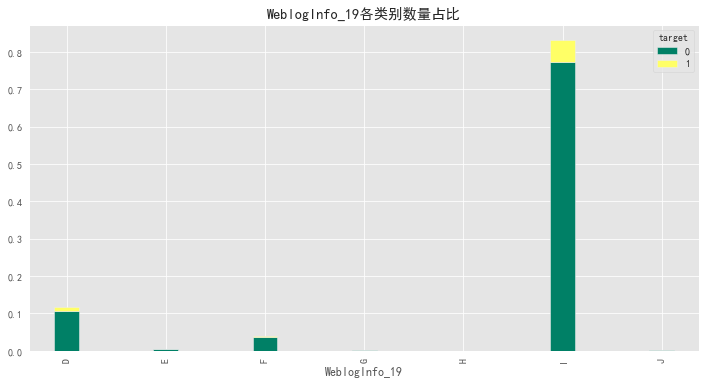

<Figure size 432x288 with 0 Axes>

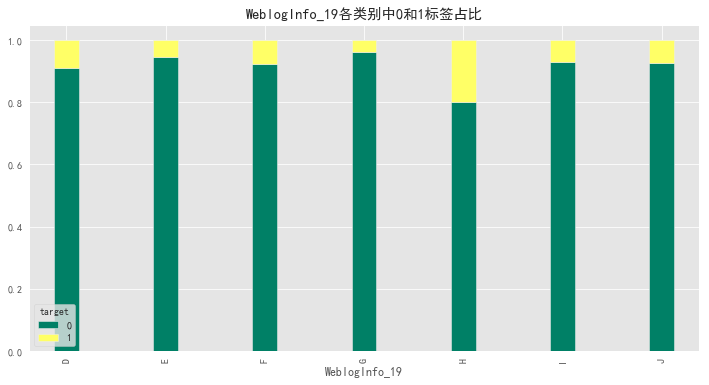

<Figure size 432x288 with 0 Axes>

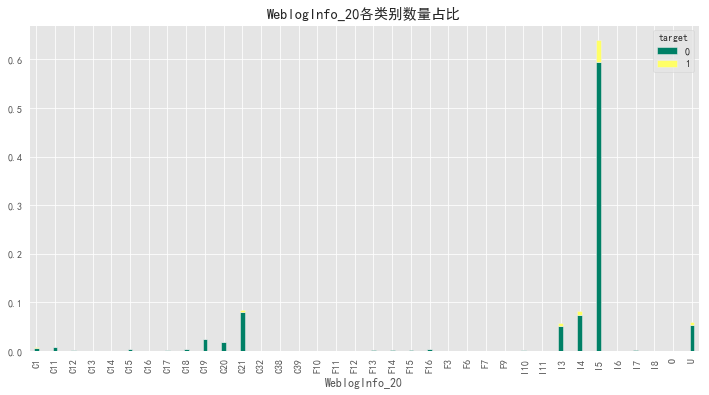

<Figure size 432x288 with 0 Axes>

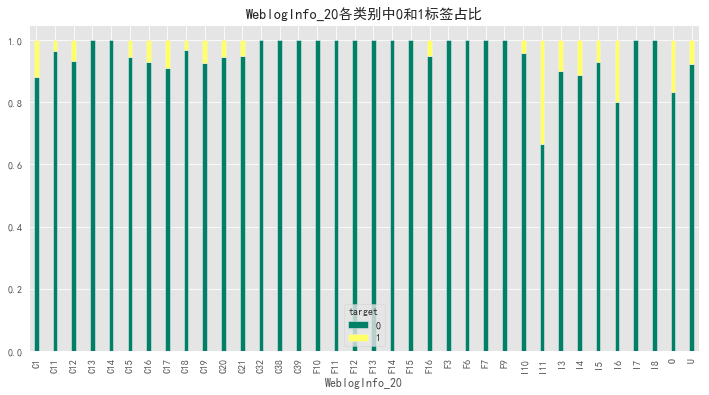

<Figure size 432x288 with 0 Axes>

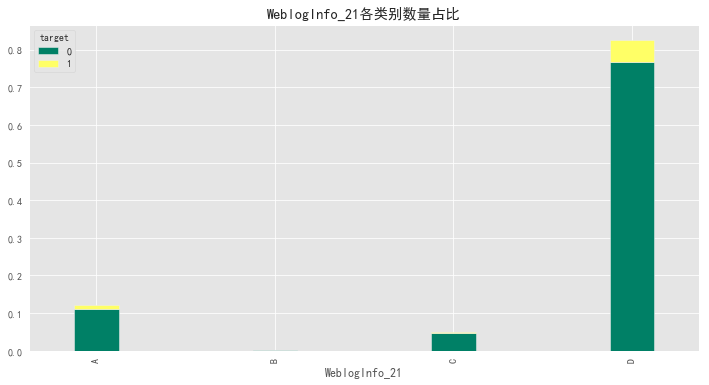

<Figure size 432x288 with 0 Axes>

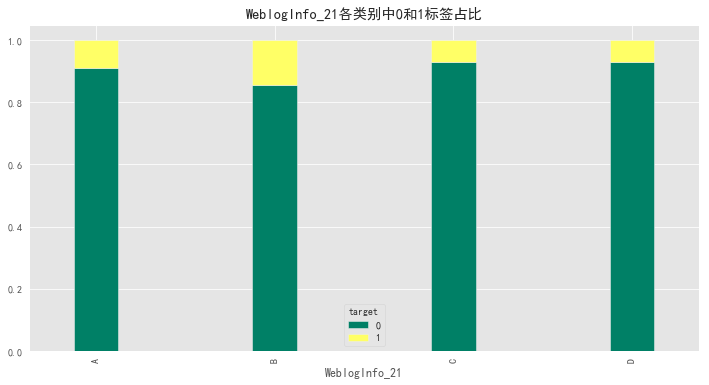

In [35]:
'''
4.3、WeblogInfo特征数据处理：
4.3.1、对于类别型特征:
WeblogInfo_19、20、21特征可视化结果如下:
'''
# 利用figures_in_featurelist函数对webloginfo_category_list内的类别型特征进行可视化展示
figures_in_featurelist(featurelist=webloginfo_category_list, name='WeblogInfo_')


<Figure size 432x288 with 0 Axes>

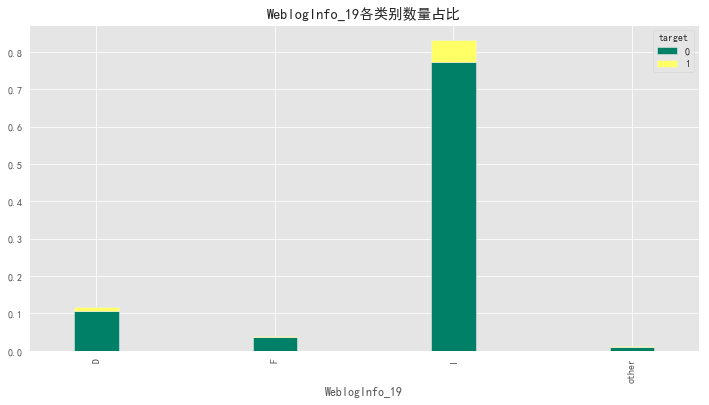

<Figure size 432x288 with 0 Axes>

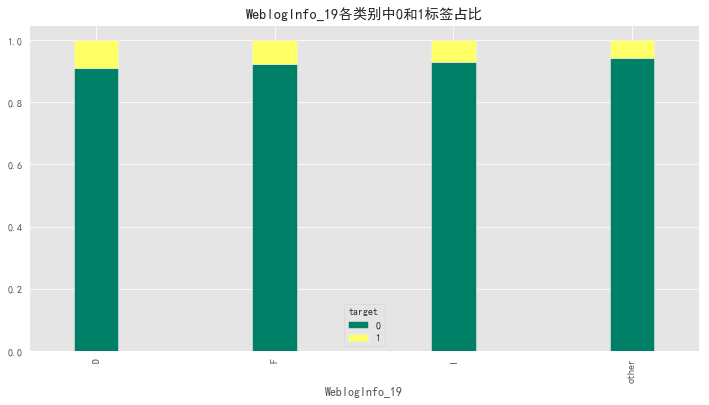

<Figure size 432x288 with 0 Axes>

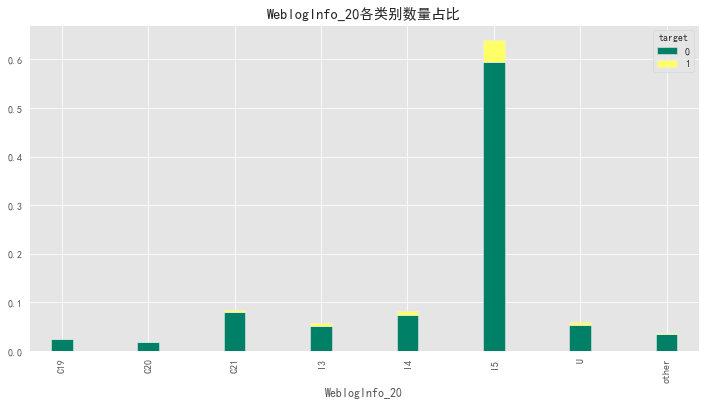

<Figure size 432x288 with 0 Axes>

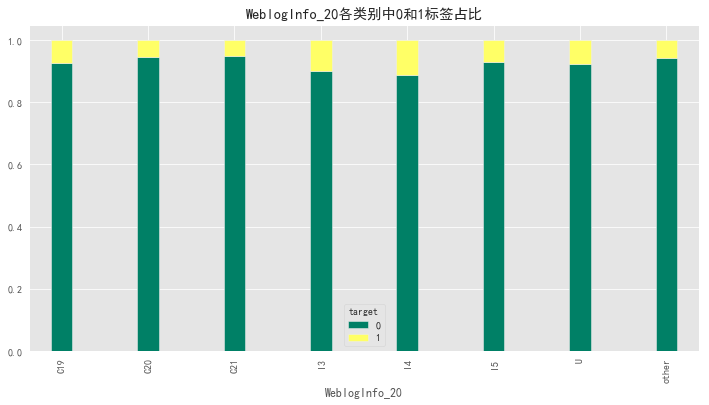

<Figure size 432x288 with 0 Axes>

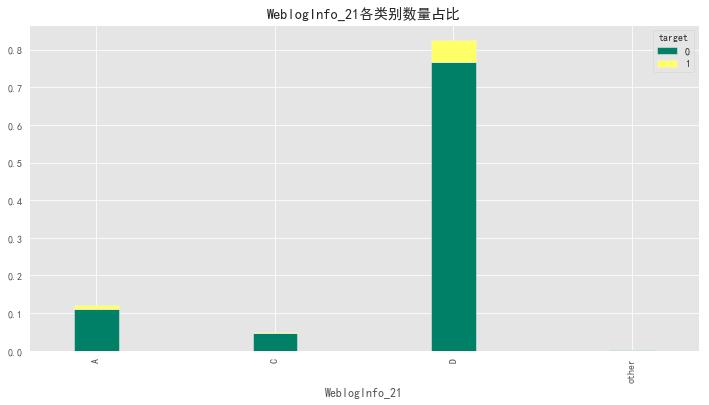

<Figure size 432x288 with 0 Axes>

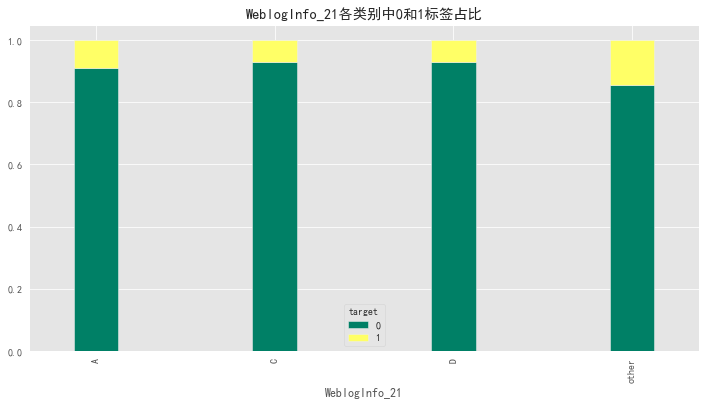

In [36]:
'''
4.3.1、对于类别型特征:
WeblogInfo_19、20、21特征处理:
根据可视化结果可知，这3特征内都存在某几个别类别数量特别少的情况，因此做出如下处理：
分别对这3个特征内比例小于0.01的所有类别合并，成为‘other’类
创建函数category_combine实现以上功能
'''

# 创建函数category_combine，对每个特征内比例低于0.01的类别进行合并
def category_combine(featurelist):
    '''
    该函数功能是对每个特征内比例低于0.01的类别进行合并
    feature_list:代表存储特征的列表    
    '''
    # 遍历feature_list内所有特征
    for i in featurelist:
        # 创建变量名，为webloginfo_+特征名后缀数字(例如webloginfo_19)
        weblog_name = 'webloginfo_' + i.split('_')[1]
        # 使用value_counts()方法对特征i内每个类别进行数量统计
        weblog_name = df_dataset[i].value_counts()
        # 计算每个类别的数量比例，并存入weblog_name内
        weblog_name = weblog_name / len(df_dataset)
        # 创建字典dic_webloginfo，存储类别-比例对应关系信息
        dic_webloginfo = {}
        # 遍历特征i内每个类别
        for j in weblog_name.index:
            # 判定条件：类别所对应的比例高于0.01
            if weblog_name[j] > 0.01:
            # 此时类别名称保持不变，并存入dic_webloginfo内，键和值都为原类别名
                dic_webloginfo[j] = j
            # 判定条件：类别所对应的比例低于0.01       
            else:
            # 此时将类别名称变为‘other’，并存入dic_webloginfo内，键为原类别名，值为变换后的类别名
                dic_webloginfo[j] = 'other'    
        # 使用map方法将特征i内各类别与dic_webloginfo进行匹配
        df_dataset[i] = df_dataset[i].map( dic_webloginfo)
    # 利用figures_in_featurelist函数重新对feature_list内处理后的特征进行可视化展示
    figures_in_featurelist(featurelist=featurelist, name='WeblogInfo_')


# 使用category_combine函数实现对webloginfo_category_list内所有特征进行类别合并
category_combine(featurelist=webloginfo_category_list)

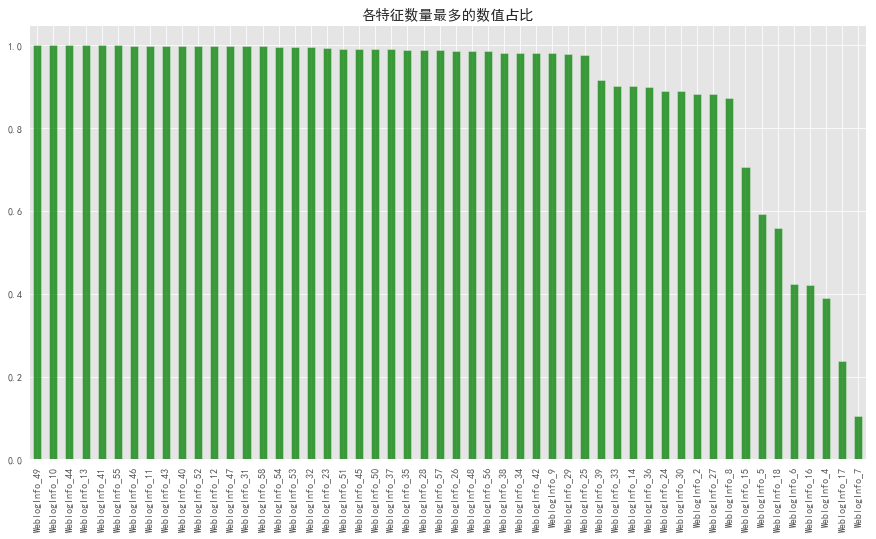

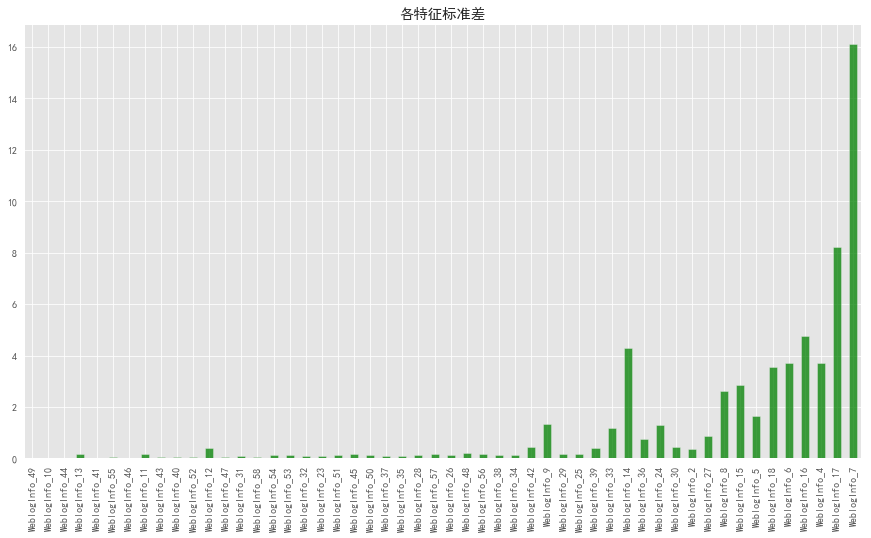

In [37]:
'''
4.3.2、对于数值型特征:
查看所有数值型特征的最多数量占比、均值、方差信息，并可视化结果
'''
# 创建空字典，用于存储数据
dic = {}
# 创建空列表value_counts_info_list，存储webloginfo_numerical_list内每个特征中数量最多的数值比例
value_counts_info_list = []
# 创建空列表std_info_list，存储webloginfo_numerical_list内每个特征的标准差
std_info_list = []
# 创建空列表mean_info_list，存储webloginfo_numerical_list内每个特征的均值
mean_info_list = []
# 遍历webloginfo_numerical_list内每个特征名称
for i in webloginfo_numerical_list:
    # 使用value_counts方法统计每个特征中数值的数量，索引[0]提取出最多的数量，并除以样本数得到数量占比，将该数值存入value_counts_info_list
    value_counts_info_list.append(df_dataset[i].value_counts().values[0] / len(df_dataset))
    # 使用std方法计算每个特征的标准差，并将结果存入std_info_list
    std_info_list.append(df_dataset[i].std())
    # 使用mean()方法计算每个特征的均值，并将结果存入mean_info_list
    mean_info_list.append(df_dataset[i].mean())
# 将value_counts_info_list列表存入dic，对应的键为‘数量最多的数值占比’
dic['数量最多的数值占比'] = value_counts_info_list
# 将std_info_list列表存入dic，对应的键为‘标准差’
dic['标准差'] = std_info_list
# 将mean_info_list列表存入dic，对应的键为‘均值’
dic['均值'] = mean_info_list
# 创建DataFrame，data为dic内的数据，index为webloginfo_numerical_list内每个特征名称
df_webloginfo_numerical = pd.DataFrame(data=dic, index=webloginfo_numerical_list)
# 对df_webloginfo_numerical的‘数量最多的数值占比’列进行降序排序
df_webloginfo_numerical.sort_values(by='数量最多的数值占比', axis=0, ascending=False, inplace=True)
# 通过bar_figure函数对df_webloginfo_numerical的‘数量最多的数值占比’进行可视化
bar_figure(plot_data=df_webloginfo_numerical['数量最多的数值占比'], title='各特征数量最多的数值占比', figsize=(15,8))
# 通过bar_figure函数对df_webloginfo_numerical的‘标准差’进行可视化,并与‘数量最多的数值占比’结果比较
bar_figure(plot_data=df_webloginfo_numerical['标准差'], title='各特征标准差', figsize=(15,8))


In [38]:
'''
4.3.2、对于数值型特征:
通过上面可视化结果可知，webloginfo的数值型特征内:
1、大多数特征里单一数值的占比过大(都是数值0的占比过大)，有35个特征最为明显，0的比例已经超过或接近98%，分别为:
WeblogInfo_9-13、WeblogInfo_23、WeblogInfo_25、WeblogInfo_26、WeblogInfo_28、WeblogInfo_29、
WeblogInfo_31、WeblogInfo_32、WeblogInfo_34、WeblogInfo_35、WeblogInfo_37、WeblogInfo_38、
WeblogInfo_40-58
2、这35个特征，除去0外，每个特征内的其他数值占比非常少，并且每个特征内数值的类别多，数量零星、分散
3、并且对比标准差可知，以上这些特征的标准差都接近于0
4、结合1、2、3，对这35个特征做删除处理
'''
# 创建列表drop_feature_list，存储需要删除的特征名称
drop_feature_list = ['WeblogInfo_23', 'WeblogInfo_25', 'WeblogInfo_26', 'WeblogInfo_28', 
                     'WeblogInfo_29', 'WeblogInfo_31', 'WeblogInfo_32', 'WeblogInfo_34', 
                     'WeblogInfo_35', 'WeblogInfo_37', 'WeblogInfo_38']
# 使用feature_list函数生成WeblogInfo_9-13这5个特征名，并加入drop_feature_list内
drop_feature_list.extend(feature_list('WeblogInfo_', 9, 13))
# 使用feature_list函数生成WeblogInfo_40-58这19个特征名，并加入drop_feature_list内
drop_feature_list.extend(feature_list('WeblogInfo_', 40, 58))
# 使用drop方法将drop_feature_list内的所有特征删除
df_dataset.drop(drop_feature_list, axis=1, inplace=True)


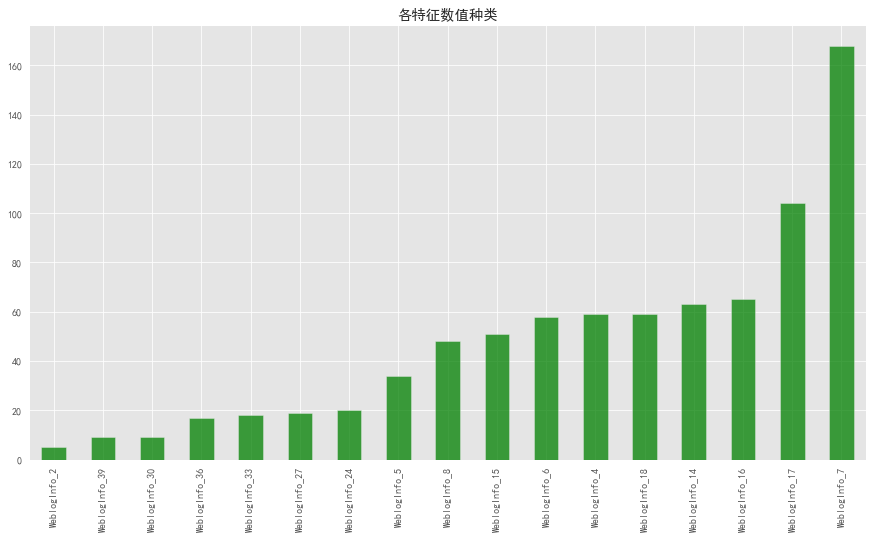

In [39]:
'''
4.3.2、对于数值型特征:
删除以上35个特征后，剩下数值型特征为:
WeblogInfo_2、WeblogInfo_4、WeblogInfo_5-8、WeblogInfo_14-18、WeblogInfo_24、WeblogInfo_27、
WeblogInfo_30、WeblogInfo_33、WeblogInfo_36、WeblogInfo_39，共17个特征

1、首先统计各个特征中数值种类数量:
'''
# 创建新列表webloginfo_numerical_list_new，存储保留下来的webloginfo特征的名称
webloginfo_numerical_list_new = ['WeblogInfo_2', 'WeblogInfo_4', 'WeblogInfo_24', 'WeblogInfo_27', 
                                 'WeblogInfo_30', 'WeblogInfo_33', 'WeblogInfo_36', 'WeblogInfo_39']
# 使用feather_list函数创建WeblogInfo_5-8，共4个特征名称，并加入webloginfo_numerical_list_new内
webloginfo_numerical_list_new.extend(feature_list('WeblogInfo_', 5, 8))
# 使用feather_list函数创建WeblogInfo_14-18，共5个特征名称，并加入webloginfo_numerical_list_new内 
webloginfo_numerical_list_new.extend(feature_list('WeblogInfo_', 14, 18))
# 创建字典dic_webloginfo_numerical，存储每个特征中数值的数量
dic_webloginfo_numerical = {}
# 遍历webloginfo_numerical_list_new内每个特征名称
for feature in webloginfo_numerical_list_new:
    # 字典键为特征名，值为该特征内数值种类的数量
    dic_webloginfo_numerical[feature] = len(df_dataset[feature].unique())
# 创建Series，数据为dic_webloginfo_numerical的值，index为特征名称   
df_webloginfo_numerical = pd.Series(data=dic_webloginfo_numerical, index=webloginfo_numerical_list_new)
# 对df_webloginfo_numerical的值进行升序排列
df_webloginfo_numerical.sort_values()
# 可视化结果
bar_figure(plot_data=df_webloginfo_numerical.sort_values(),title='各特征数值种类', figsize=(15,8))

<Figure size 432x288 with 0 Axes>

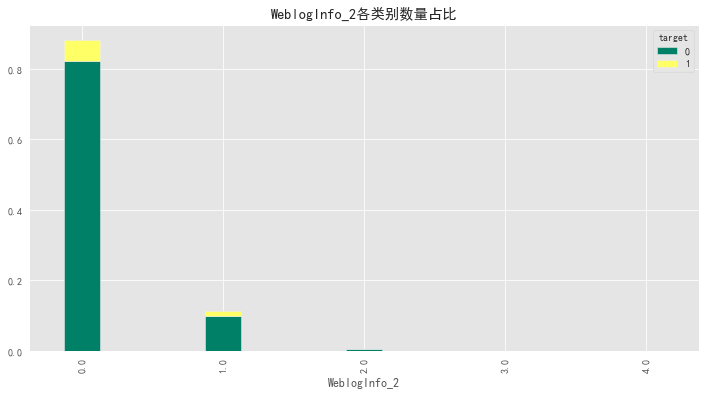

<Figure size 432x288 with 0 Axes>

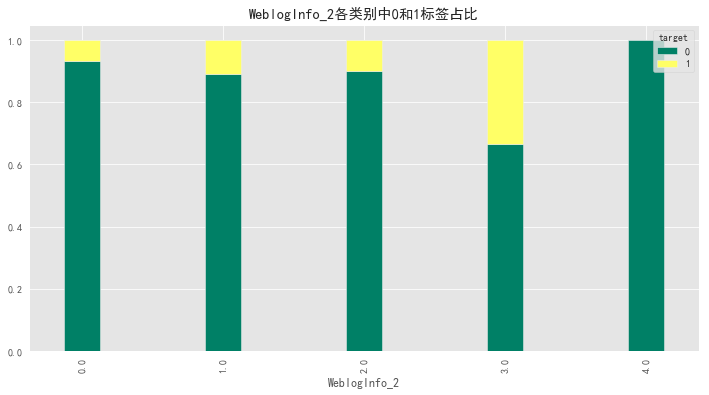

<Figure size 432x288 with 0 Axes>

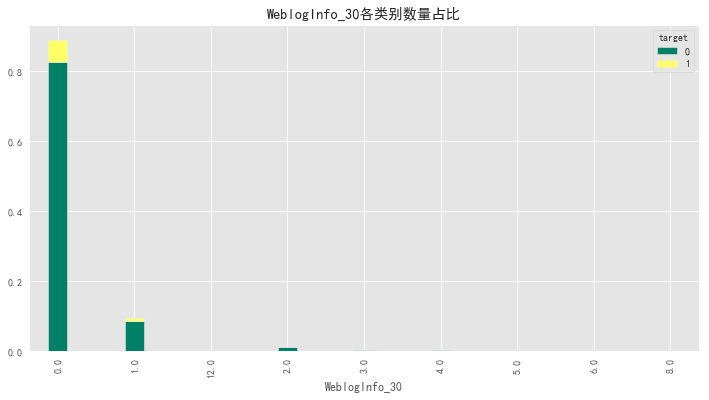

<Figure size 432x288 with 0 Axes>

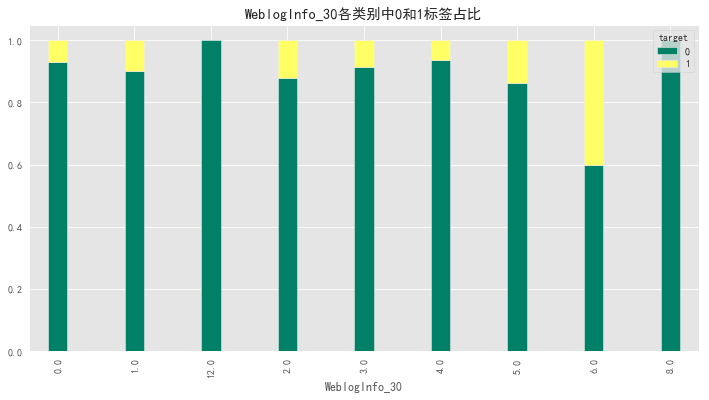

<Figure size 432x288 with 0 Axes>

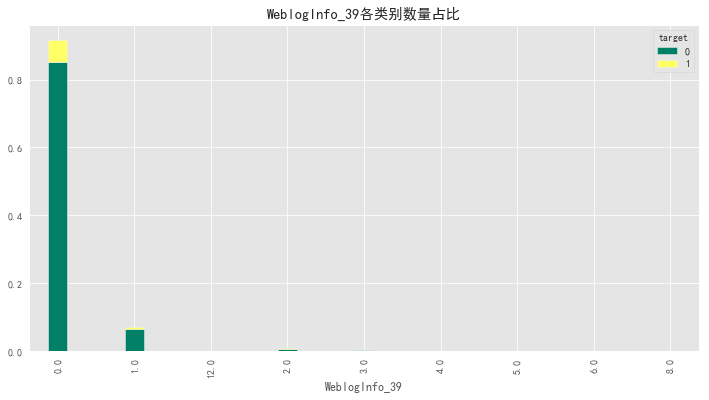

<Figure size 432x288 with 0 Axes>

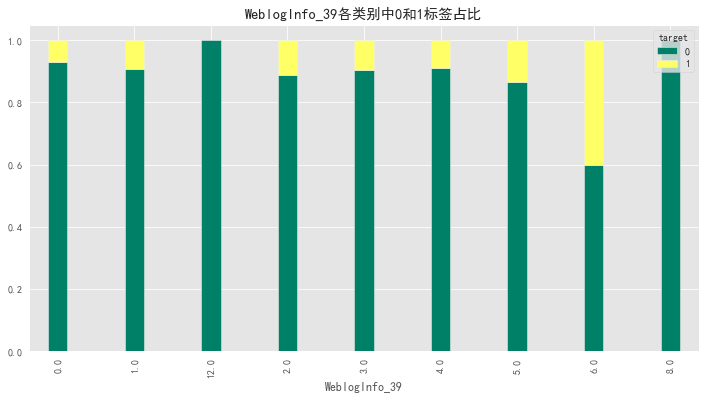

In [40]:
'''
4.3.2、对于数值型特征:
WeblogInfo_2、WeblogInfo_30、和WeblogInfo_39这3个特征中数值的种类数不超过10个，将这3个特征转换为类别型
'''
# 创建列表，存储需要转换成类别型的特征名称
webloginfo_num2cat = ['WeblogInfo_2', 'WeblogInfo_30', 'WeblogInfo_39']
# 遍历webloginfo_num2cat内每个特征名称
for feature in webloginfo_num2cat:
    # 使用astype方法将特征转换成类别型
    df_dataset[feature] = df_dataset[feature].astype(str)
# 使用figures_in_featurelist函数可视化
figures_in_featurelist(featurelist=webloginfo_num2cat, name='webloginfo_')

<Figure size 432x288 with 0 Axes>

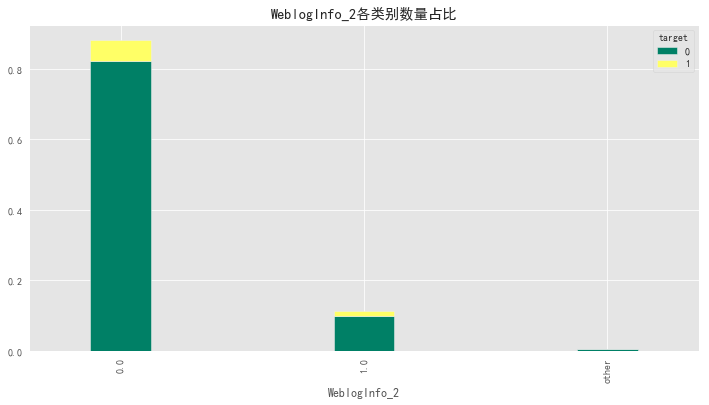

<Figure size 432x288 with 0 Axes>

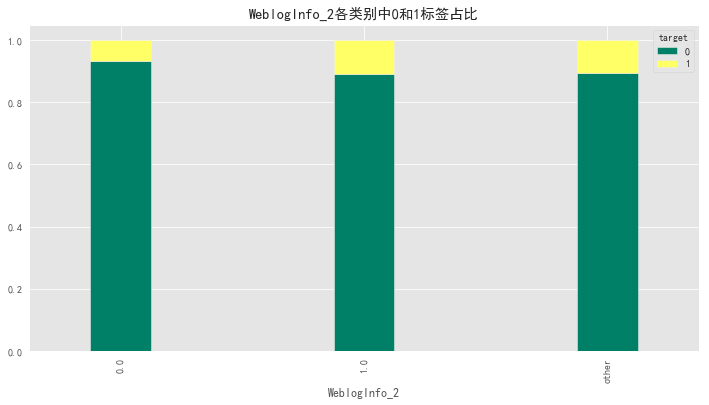

<Figure size 432x288 with 0 Axes>

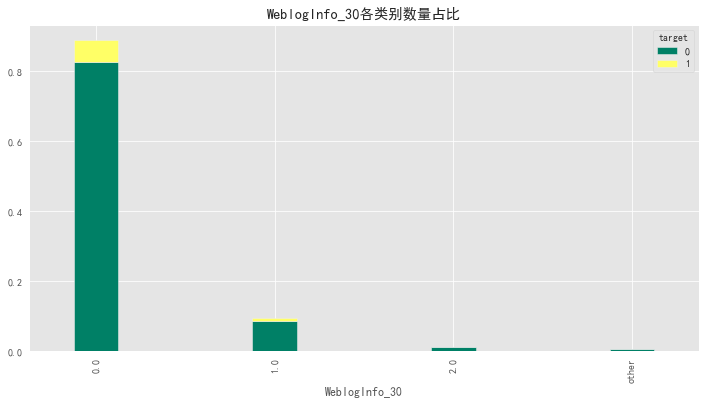

<Figure size 432x288 with 0 Axes>

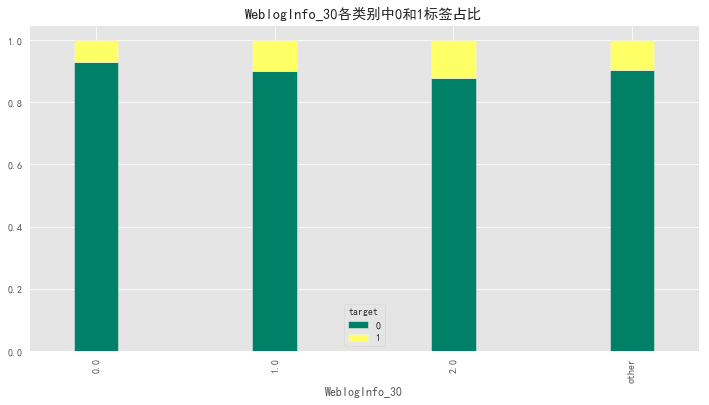

<Figure size 432x288 with 0 Axes>

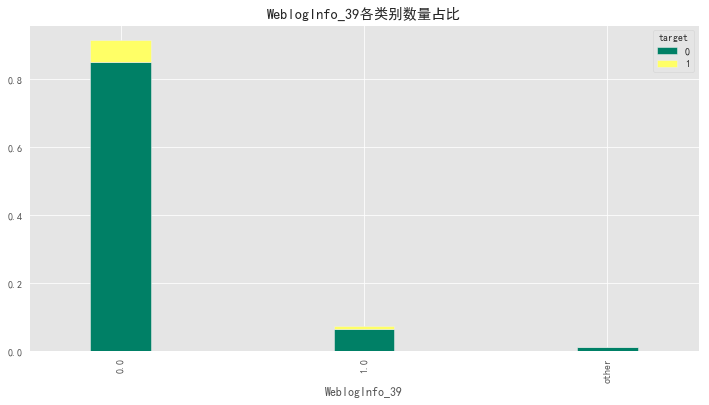

<Figure size 432x288 with 0 Axes>

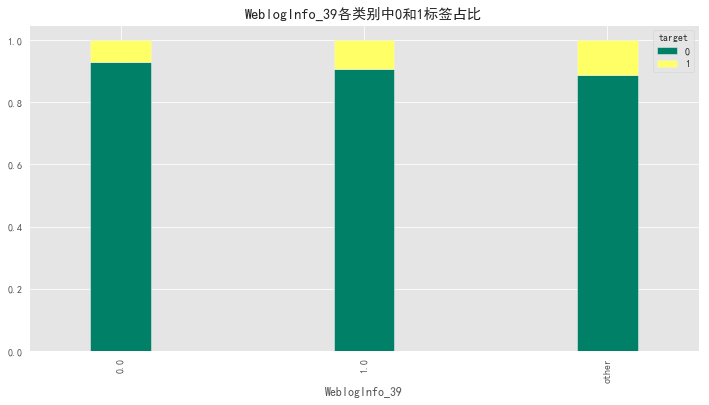

In [41]:
'''
4.3.2、特征处理:
通过可视化可知，这3个特征中类别同样存在某几个类别的比例特别低，同样将低于0.01的类别合并为‘other’
'''
# 使用category_combine函数实现对webloginfo_num2cat内所有特征进行类别合并
category_combine(featurelist=webloginfo_num2cat)

<Figure size 432x288 with 0 Axes>

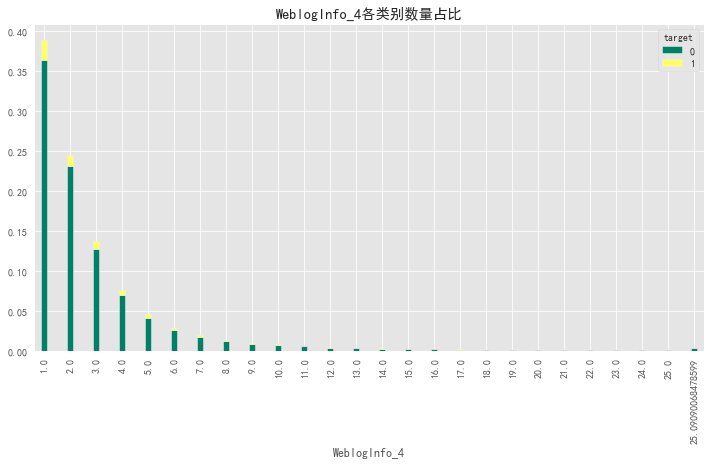

<Figure size 432x288 with 0 Axes>

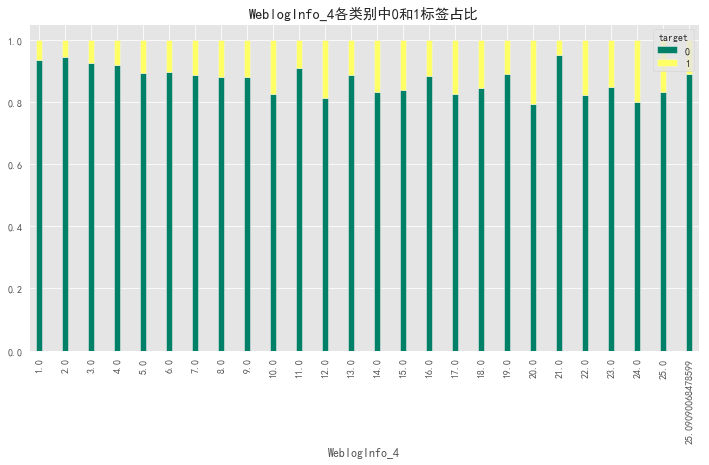

<Figure size 432x288 with 0 Axes>

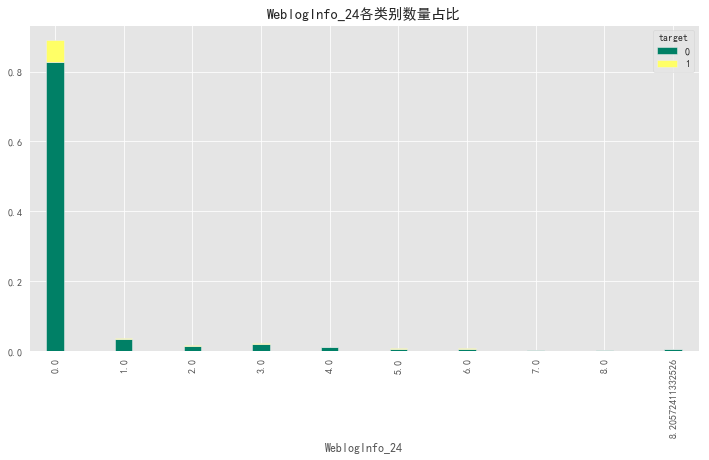

<Figure size 432x288 with 0 Axes>

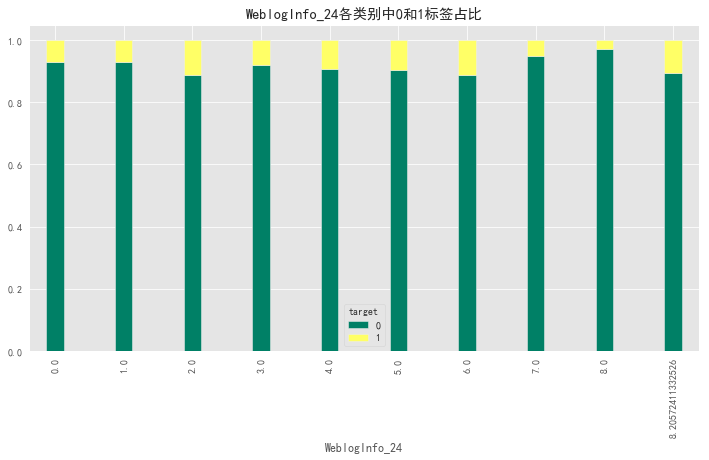

<Figure size 432x288 with 0 Axes>

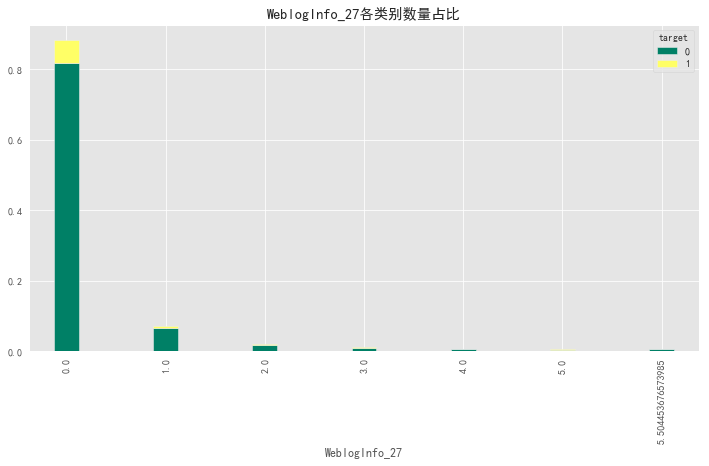

<Figure size 432x288 with 0 Axes>

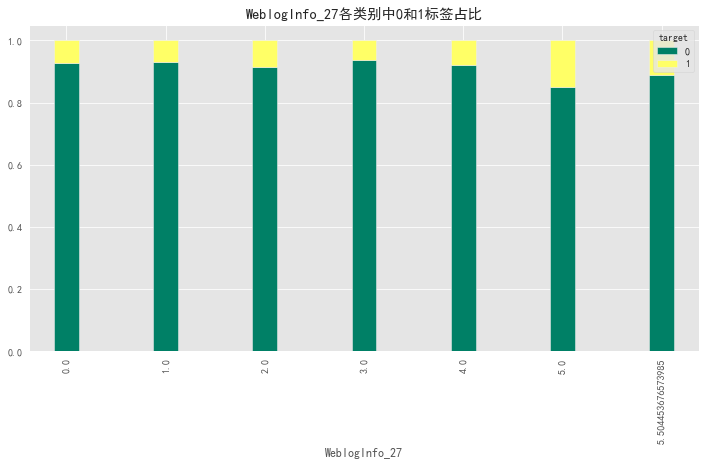

<Figure size 432x288 with 0 Axes>

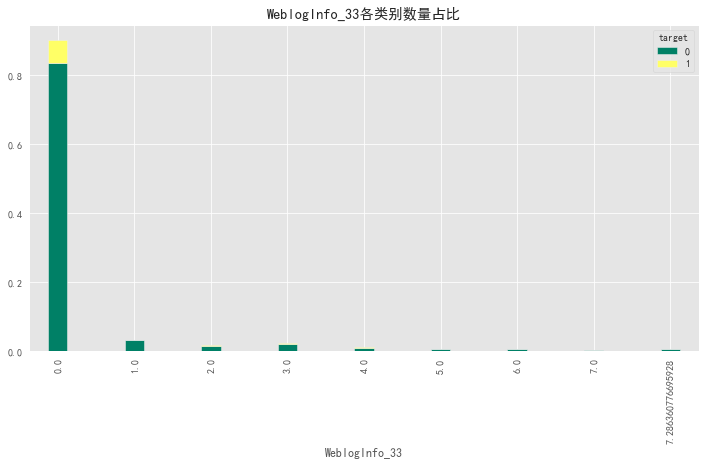

<Figure size 432x288 with 0 Axes>

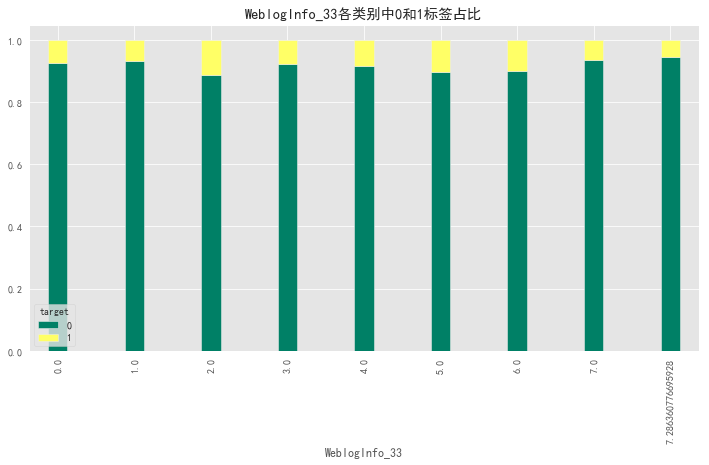

<Figure size 432x288 with 0 Axes>

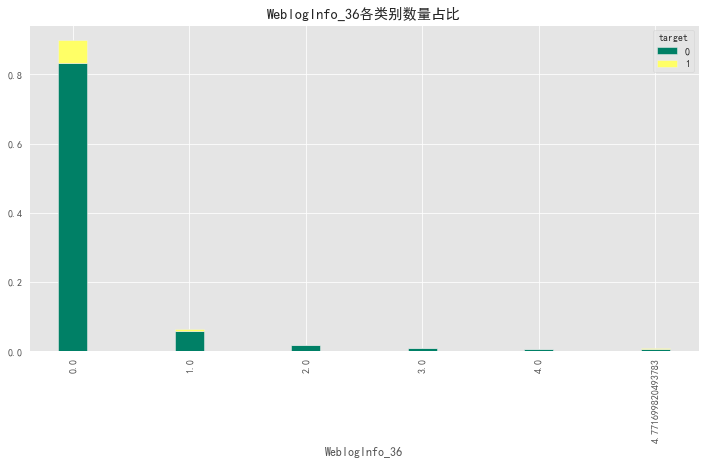

<Figure size 432x288 with 0 Axes>

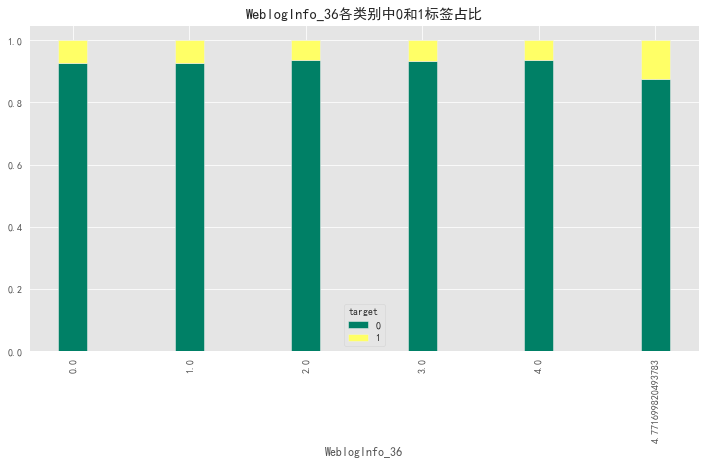

<Figure size 432x288 with 0 Axes>

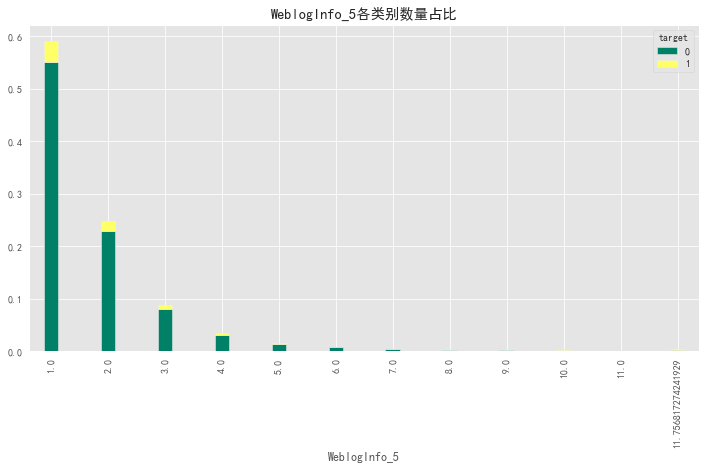

<Figure size 432x288 with 0 Axes>

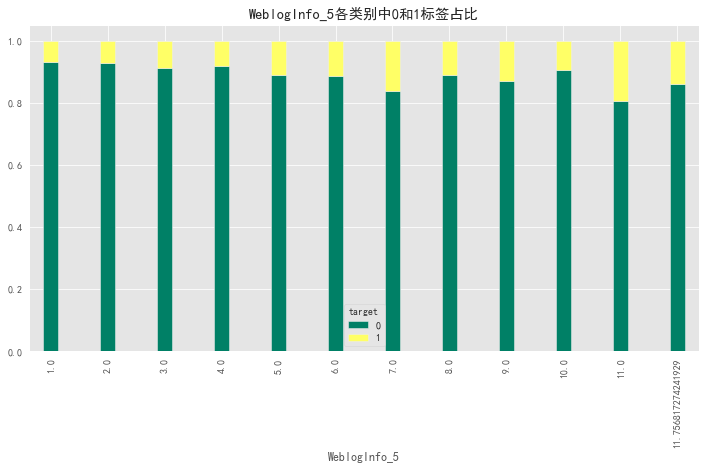

<Figure size 432x288 with 0 Axes>

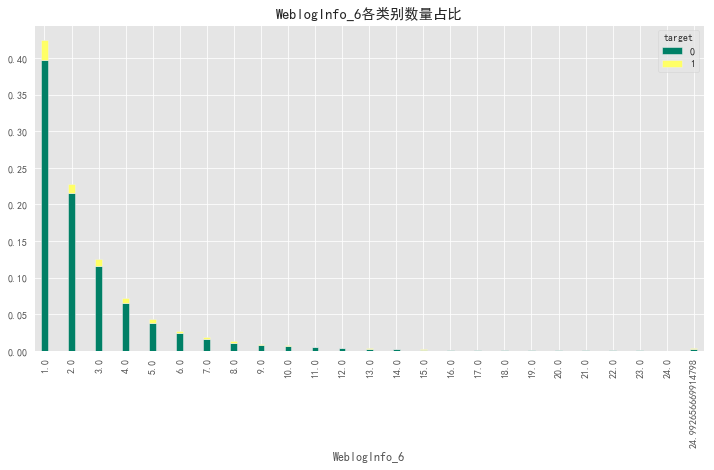

<Figure size 432x288 with 0 Axes>

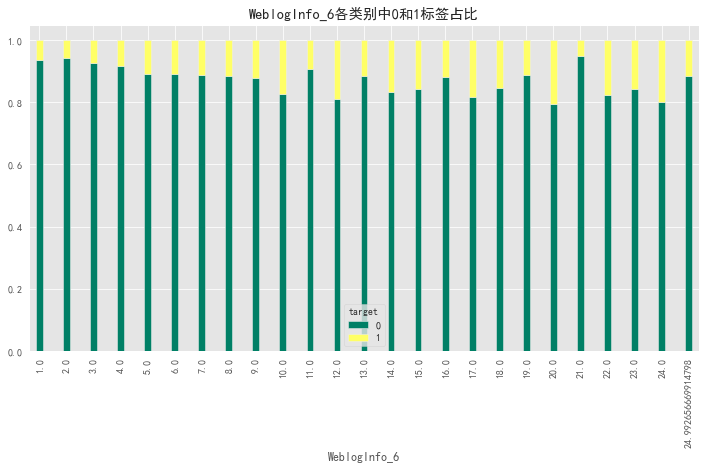

<Figure size 432x288 with 0 Axes>

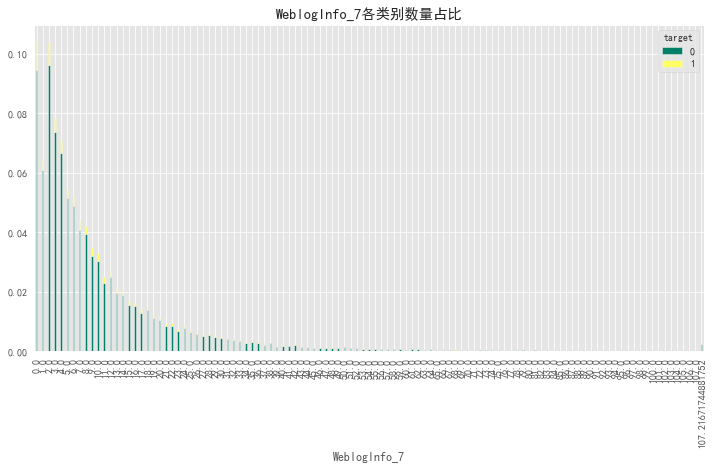

<Figure size 432x288 with 0 Axes>

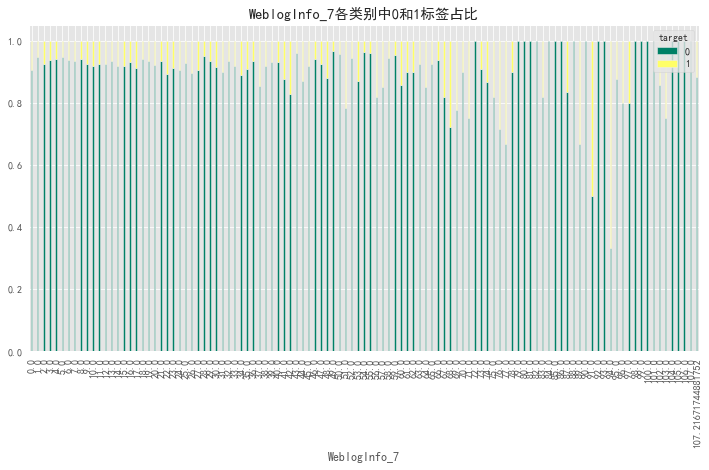

<Figure size 432x288 with 0 Axes>

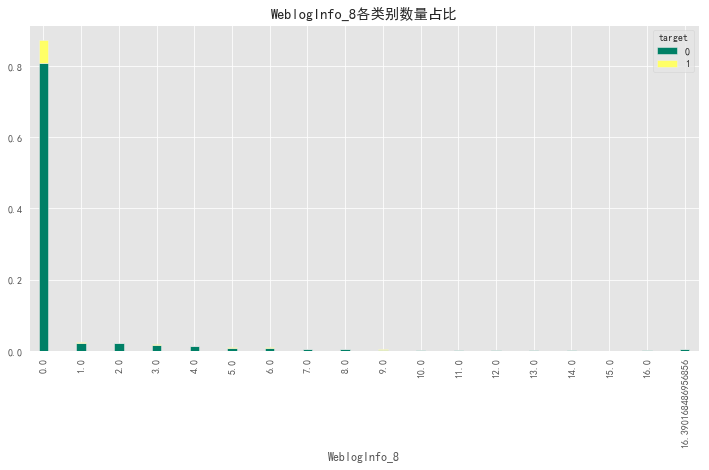

<Figure size 432x288 with 0 Axes>

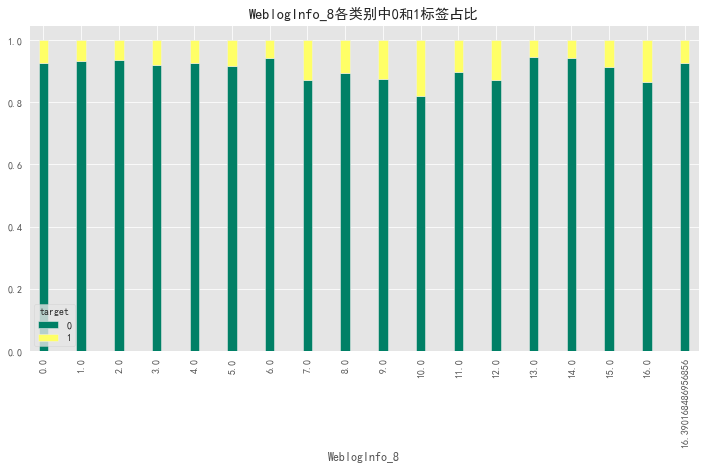

<Figure size 432x288 with 0 Axes>

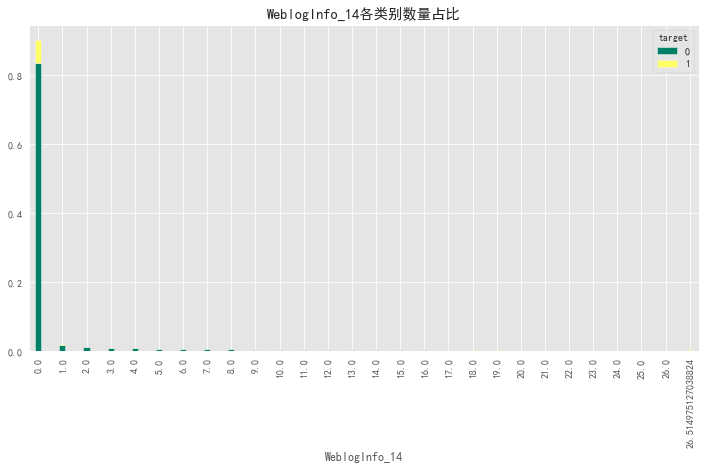

<Figure size 432x288 with 0 Axes>

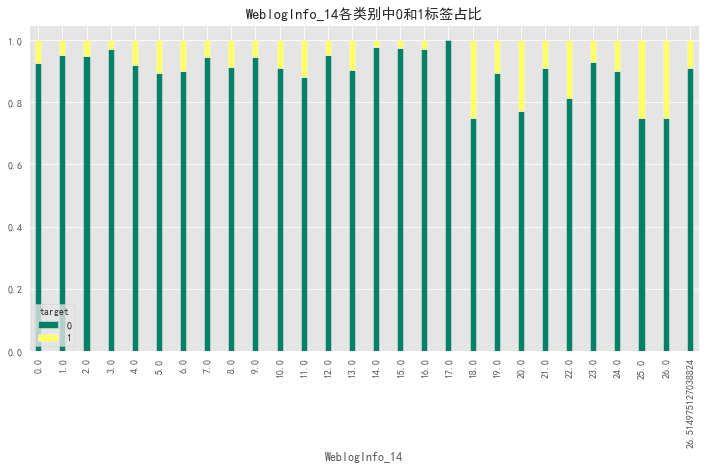

<Figure size 432x288 with 0 Axes>

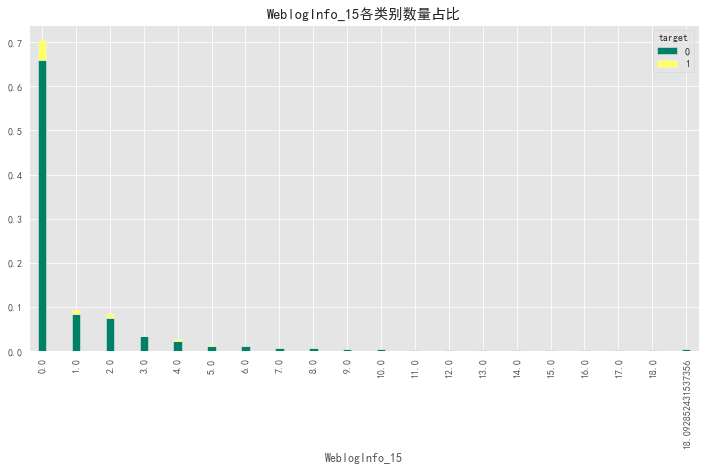

<Figure size 432x288 with 0 Axes>

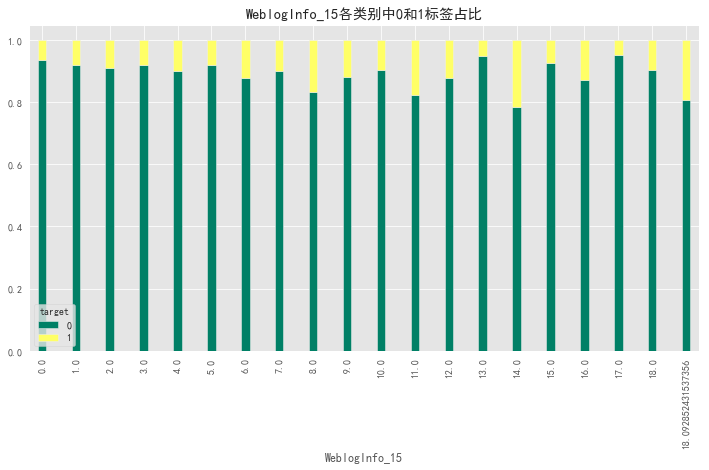

<Figure size 432x288 with 0 Axes>

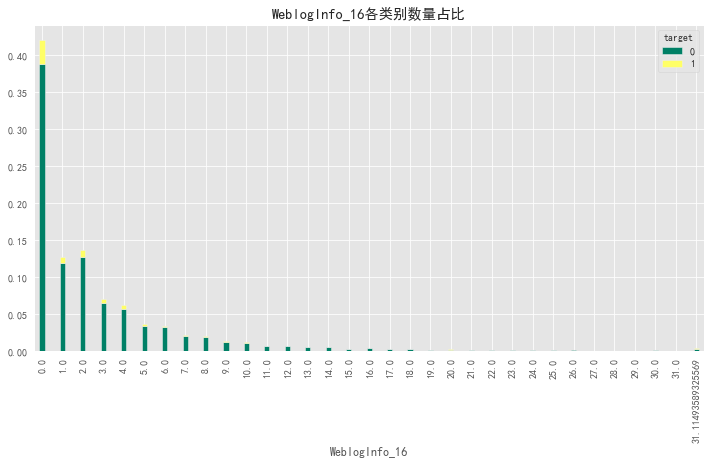

<Figure size 432x288 with 0 Axes>

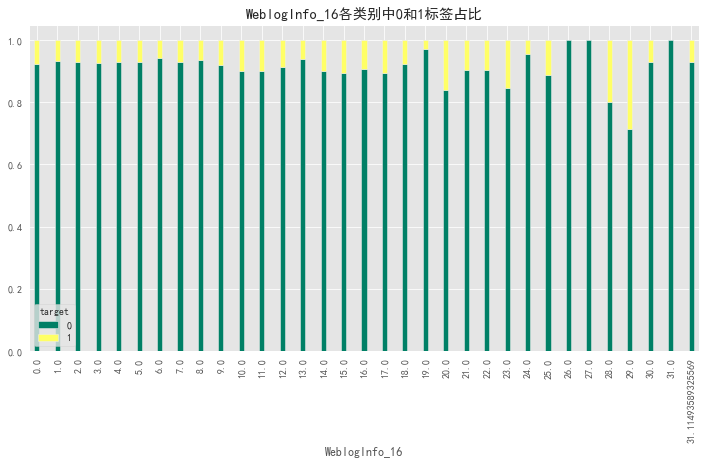

<Figure size 432x288 with 0 Axes>

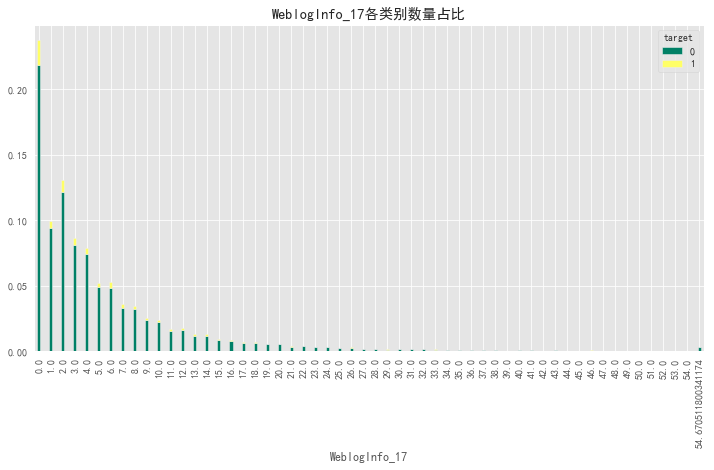

<Figure size 432x288 with 0 Axes>

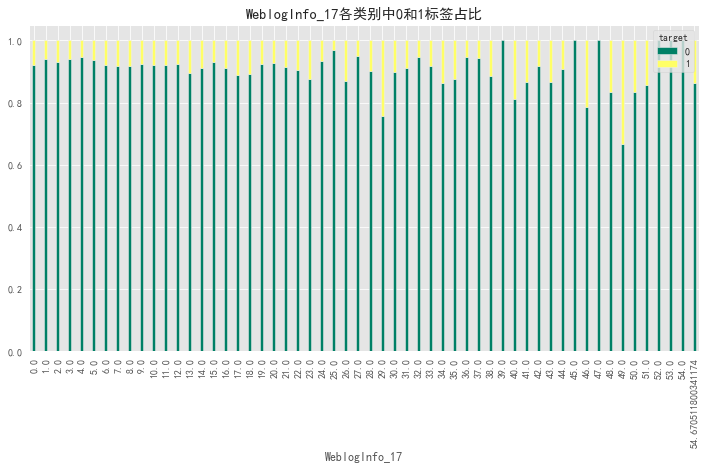

<Figure size 432x288 with 0 Axes>

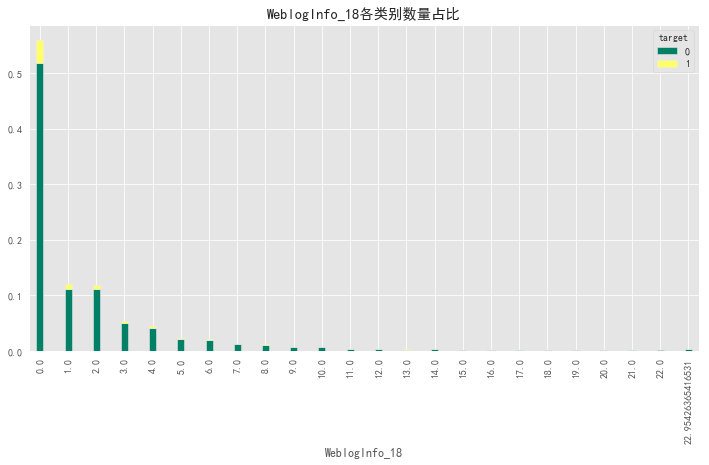

<Figure size 432x288 with 0 Axes>

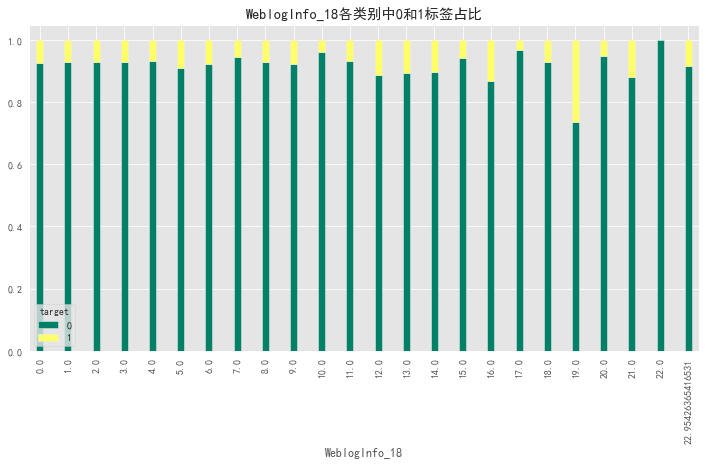

In [42]:
'''
4.3.2、对于数值型特征:

异常值判定标准:
若数据大于该列数据的均值加上6倍标准差，则认为该数据为异常值
'''
# 创建outlier_handle函数
def outlier_handle(handle_data):
    '''
    该函数功能是处理异常值
    handle_data:代表输入的数据
    '''
    # 将输入数据存入data内    
    data = np.array(handle_data)
    # 定义异常值outlier，为该数据的平均值加上4倍标准差
    outlier = np.mean(data) + 6 * np.std(data)
    # 使用numpy的where方法，对输入数据内的异常值进行检验，并替换为中位数
    handle_data = np.where(handle_data>outlier, outlier, handle_data)
    # 函数返回值
    return handle_data

# 1、首先将webloginfo_numerical_list_new内所有类别型特征名移除
# 遍历webloginfo_num2cat内每个特征名称
for feature in webloginfo_num2cat:
    # 移除webloginfo_num2cat内的每个特征名称
    webloginfo_numerical_list_new.remove(feature)
# 2、对webloginfo_numerical_list_new内的每个特征进行异常值检验及处理
# 遍历webloginfo_numerical_list_new内每个特征名称
for feature in webloginfo_numerical_list_new:
    # 使用outlier_handle函数对webloginfo_numerical_list_new内特征进行异常值检验及处理
    df_dataset[feature] = outlier_handle(df_dataset[feature])
# 3、可视化结果
# 使用figures_in_featurelist_clean对处理后的数据可视化
figures_in_featurelist(featurelist=webloginfo_numerical_list_new, name='webloginfo_')

In [43]:
'''
4.3.2、对于数值型特征:
异常值处理后，WeblogInfo_5、WeblogInfo_24、WeblogInfo_27、WeblogInfo_33、WeblogInfo_36这5个特征
的数值种类不超过10个，将这5个特征转换成类别型
'''
# 创建列表webloginfo_num2cat_handle，里面存储的是需要转换的特征名称
webloginfo_num2cat_handle = ['WeblogInfo_5', 'WeblogInfo_24', 'WeblogInfo_27', 
                             'WeblogInfo_33', 'WeblogInfo_36']
# 遍历webloginfo_num2cat_handle内每个特征名称
for feature in webloginfo_num2cat_handle:
    # 使用astype方法将特征转换成类别型
    df_dataset[feature] = df_dataset[feature].astype(str)


In [44]:
'''
4.4、WeblogInfo特征数据处理：
(1) WeblogInfo_2、5、19、20、21、24、27、30、33、36、39，共11个类别型特征
(2) WeblogInfo_4、6、7、8、14、15、16、17、18，共9个数值型特征
需要对(1)的特征进行独热编码转换
'''
# 创建web_dummies_list列表，存储需要做独热编码转换的特征名称
web_dummies_list = ['WeblogInfo_2', 'WeblogInfo_5', 'WeblogInfo_19', 'WeblogInfo_20', 'WeblogInfo_21', 
                   'WeblogInfo_24', 'WeblogInfo_27', 'WeblogInfo_30', 'WeblogInfo_33', 'WeblogInfo_36', 
                   'WeblogInfo_39']
# 使用get_dummies方法转换特征
df_dataset = pd.get_dummies(df_dataset, columns=web_dummies_list)
# 展示结果
df_dataset.head()

target  WeblogInfo_4  WeblogInfo_6  WeblogInfo_7  WeblogInfo_8  \
Idx                                                                     
10001       0         1.000         1.000        14.000         0.000   
10002       0         1.000         1.000        14.000         0.000   
10003       0         2.000         2.000         9.000         3.000   
10006       0         1.000         1.000         2.000         0.000   
10007       0         1.000         1.000         3.000         0.000   

       WeblogInfo_14  WeblogInfo_15  WeblogInfo_16  WeblogInfo_17  \
Idx                                                                 
10001          6.000          6.000          0.000          6.000   
10002          0.000          0.000          7.000          7.000   
10003          0.000          0.000          3.000          4.000   
10006          0.000          0.000          0.000          2.000   
10007          0.000          0.000          0.000          3.000   

       WeblogInfo_18  UserInfo_18  Education_Info1 Education_Info2  \
Idx                                                                  
10001          2.000           29                0               E   
10002          0.000           28                0               E   
10003          2.000           32                0               E   
10006          0.000           33                0               E   
10007          0.000           43                0               E   

      Education_Info3 Education_Info4  Education_Info5 Education_Info6  \
Idx                                                                      
10001               E               E                0               E   
10002               E               E                0               E   
10003               E               E                0               E   
10006               E               E                0               E   
10007               E               E                0               E   

      Education_Info7 Education_Info8  ThirdParty_Info_Period1_1  \
Idx                                                                
10001               E               E                         10   
10002               E               E                          0   
10003               E               E                          1   
10006               E               E                          9   
10007               E               E                          1   

       ThirdParty_Info_Period1_2  ThirdParty_Info_Period1_3  \
Idx                                                           
10001                         47                        167   
10002                          0                         68   
10003                          2                         50   
10006                         54                         56   
10007                          5                         39   

       ThirdParty_Info_Period1_4  ThirdParty_Info_Period1_5  \
Idx                                                           
10001                          0                         25   
10002                        105                         40   
10003                         50                         49   
10006                        125                         38   
10007                         34                         36   

       ThirdParty_Info_Period1_6  ThirdParty_Info_Period1_7  \
Idx                                                           
10001                         65                         68   
10002                          2                        132   
10003                          0                         78   
10006                          0                        136   
10007                         73                          0   

       ThirdParty_Info_Period1_8  ThirdParty_Info_Period1_9  \
Idx                                                           
10001                         34                          2   
10002    

In [45]:
'''
5、Education_Info特征数据处理:

5.1、查看Education_Info数据总体情况
Education_Info共有8个特征，其中Education_Info1、5为数值型特征，其他为类别型特征
'''
# 创建education_numerical_list，存储Education_Info数值型特征名称
education_numerical_list = ['Education_Info1', 'Education_Info5']
# 创建education_category_list，存储Education_Info类别型特征
education_category_list = []
# 使用feature_list函数，创建Education_Info2-4特征名称，并将结果合并入education_category_list内
education_category_list.extend(feature_list('Education_Info', 2, 4))
# 使用feature_list函数，创建Education_Info6-8特征名称，并将结果合并入education_category_list内
education_category_list.extend(feature_list('Education_Info', 6, 8))


<Figure size 432x288 with 0 Axes>

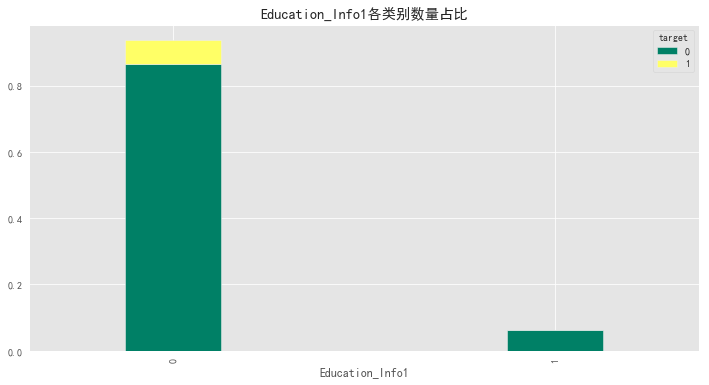

<Figure size 432x288 with 0 Axes>

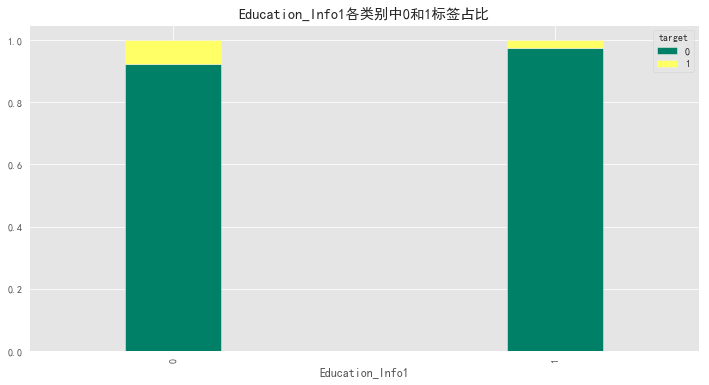

<Figure size 432x288 with 0 Axes>

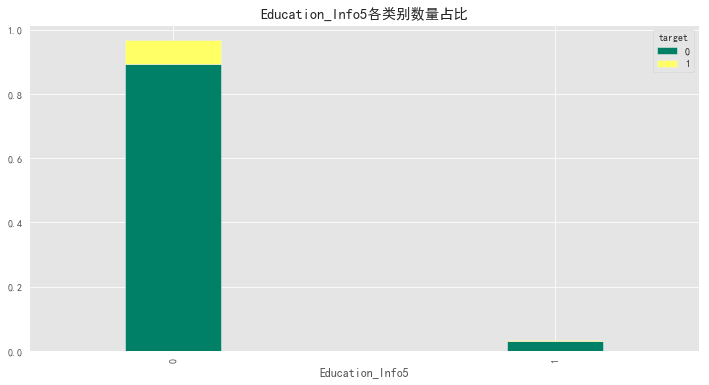

<Figure size 432x288 with 0 Axes>

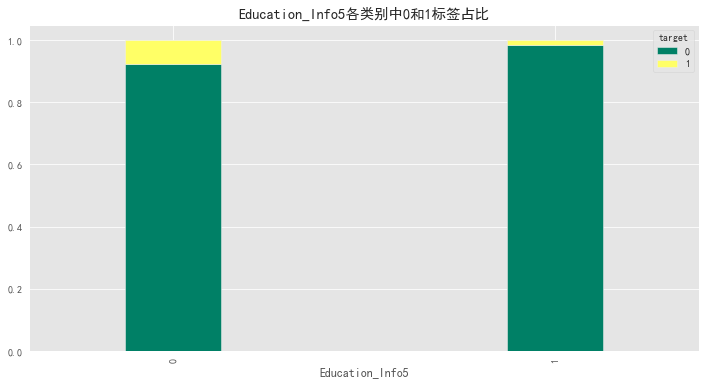

<Figure size 432x288 with 0 Axes>

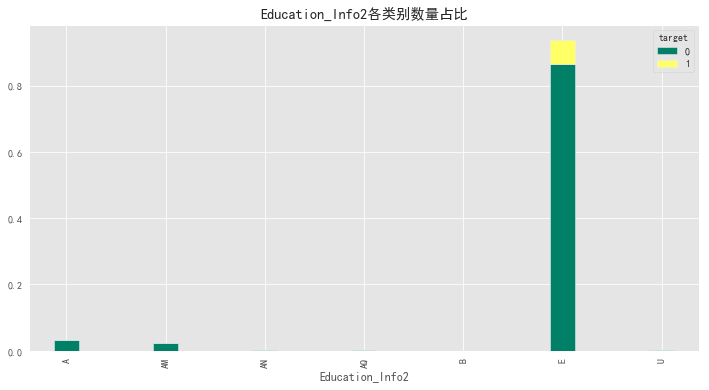

<Figure size 432x288 with 0 Axes>

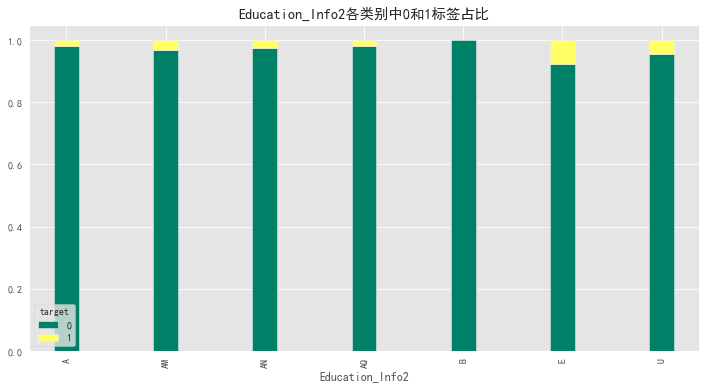

<Figure size 432x288 with 0 Axes>

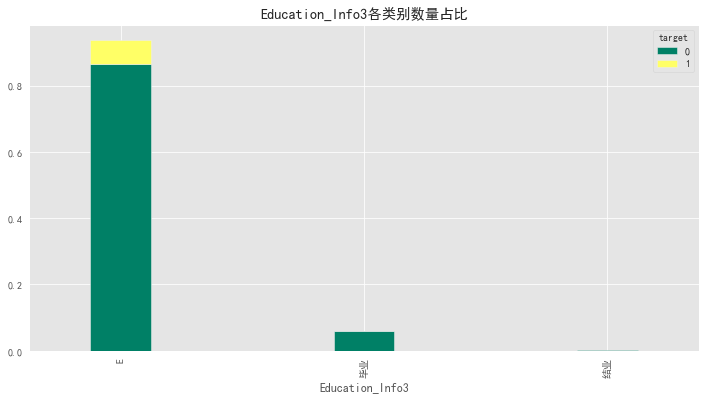

<Figure size 432x288 with 0 Axes>

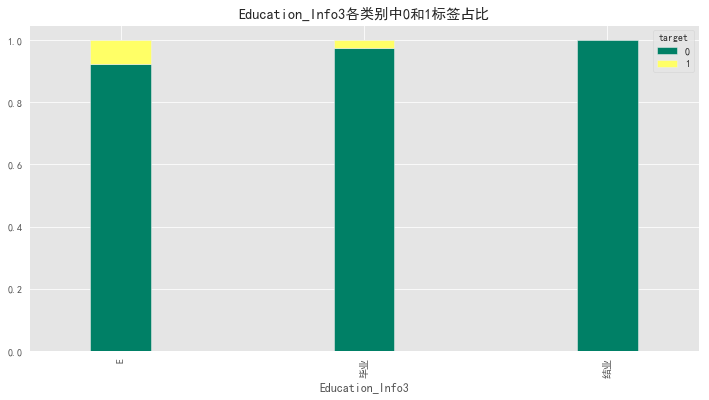

<Figure size 432x288 with 0 Axes>

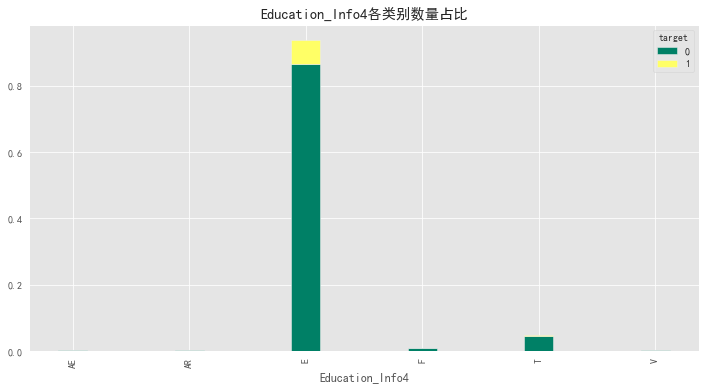

<Figure size 432x288 with 0 Axes>

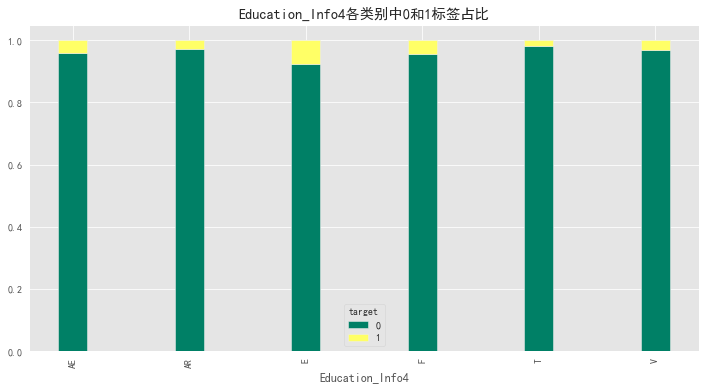

<Figure size 432x288 with 0 Axes>

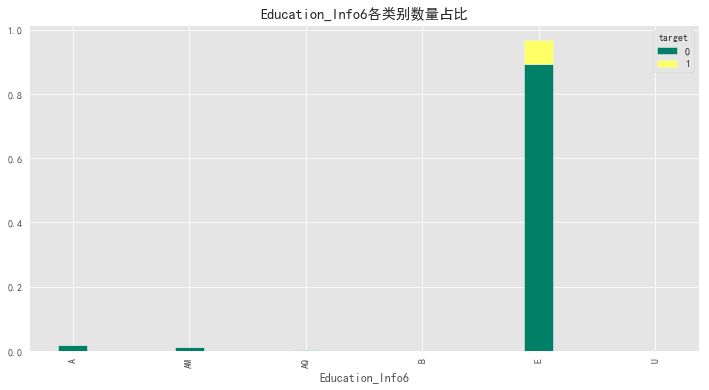

<Figure size 432x288 with 0 Axes>

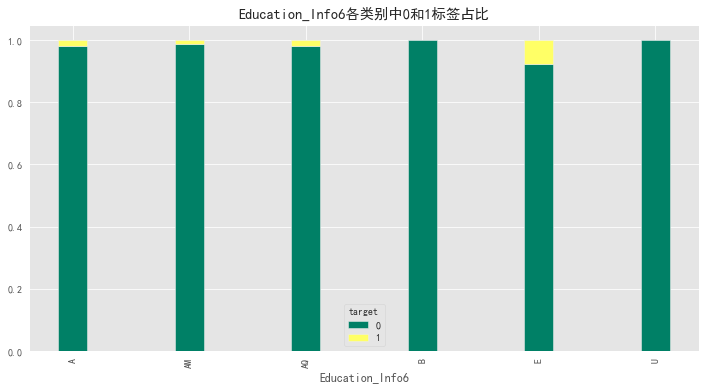

<Figure size 432x288 with 0 Axes>

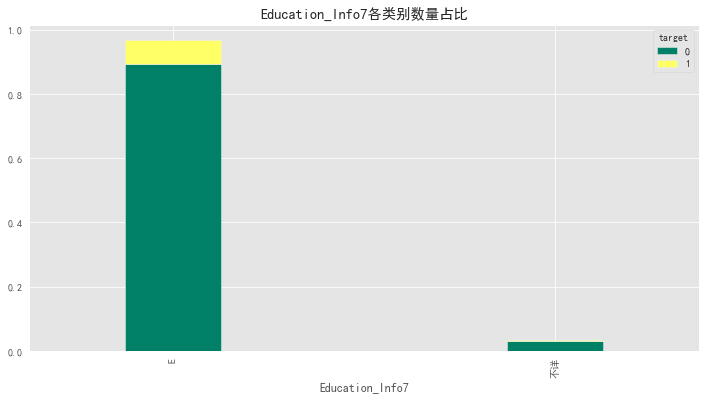

<Figure size 432x288 with 0 Axes>

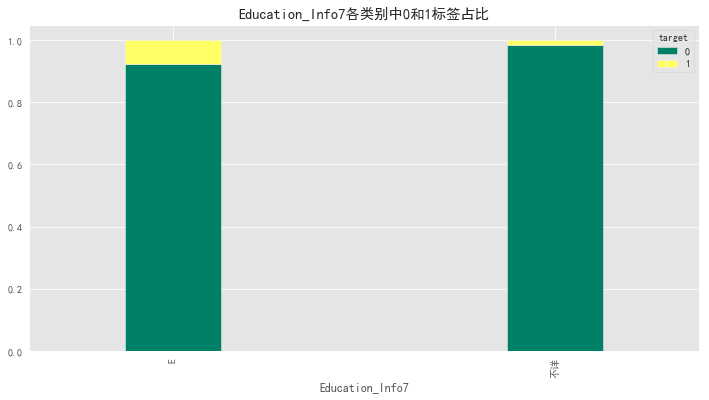

<Figure size 432x288 with 0 Axes>

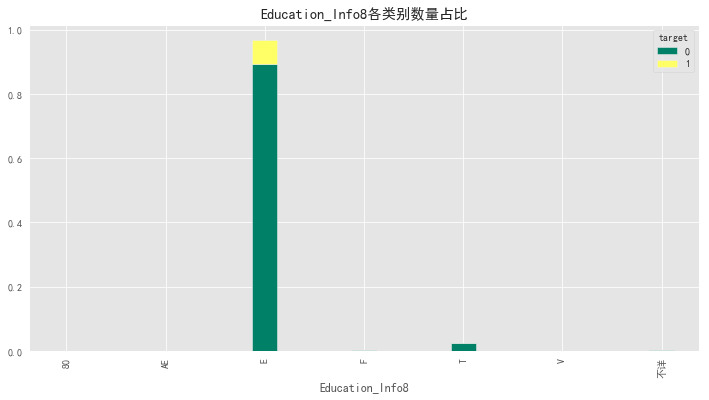

<Figure size 432x288 with 0 Axes>

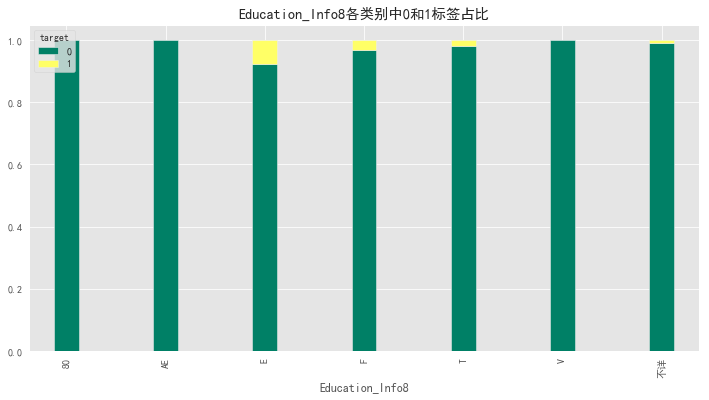

In [46]:
'''
5.2、可视化Education_Info数据总体情况
'''
# 使用figures_in_featurelist函数可视化Education_Info数值型特征分布
figures_in_featurelist(featurelist=education_numerical_list, name='education_')
# 使用figures_in_featurelist函数可视化Education_Info类别型特征分布
figures_in_featurelist(featurelist=education_category_list, name='education_')

In [47]:
'''
5.3、数值型特征处理
通过可视化结果，由于两个数值型特征里都是只有0和1两个数值，将它们转换为类别型
'''
# 遍历education_numerical_list内每个数值型特征名称
for feature in education_numerical_list:
    # 将特征类型转换为类别型
    df_dataset[feature] = df_dataset[feature].astype(str)


<Figure size 432x288 with 0 Axes>

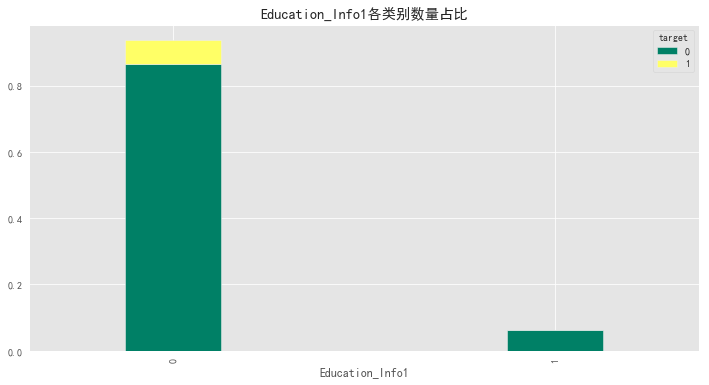

<Figure size 432x288 with 0 Axes>

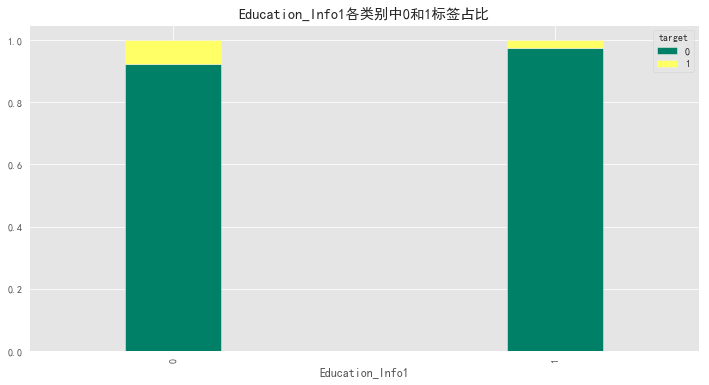

<Figure size 432x288 with 0 Axes>

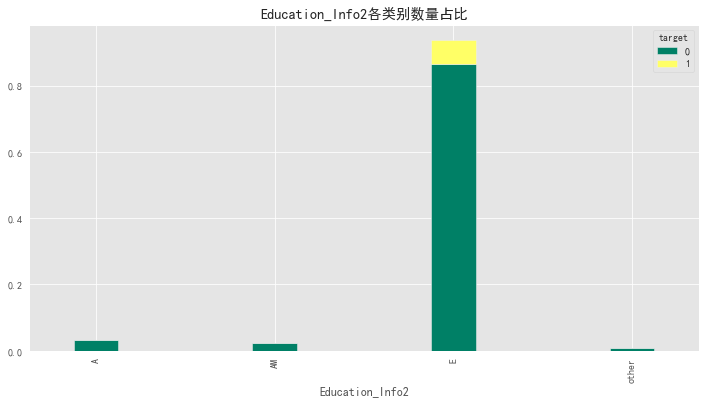

<Figure size 432x288 with 0 Axes>

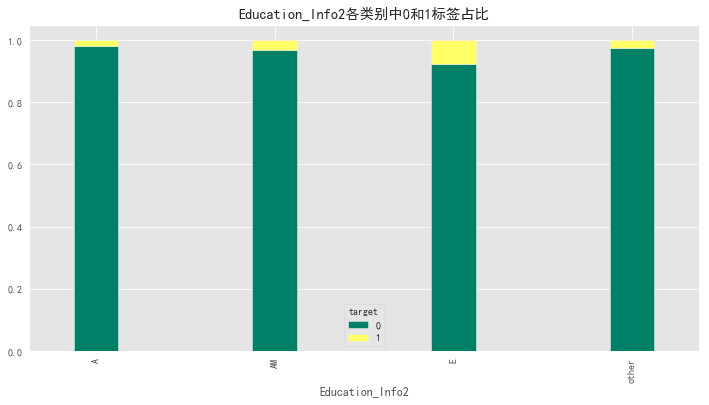

<Figure size 432x288 with 0 Axes>

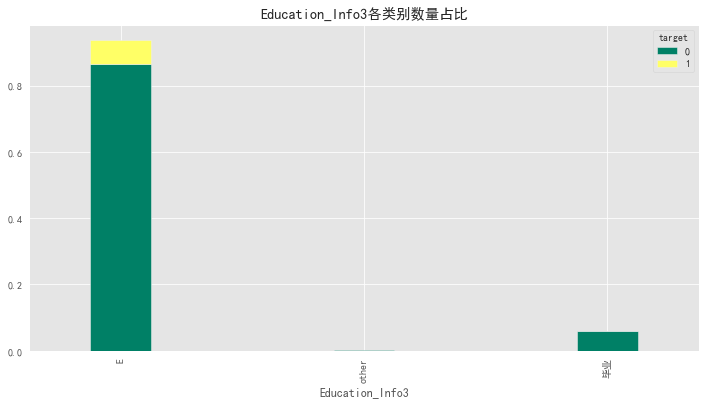

<Figure size 432x288 with 0 Axes>

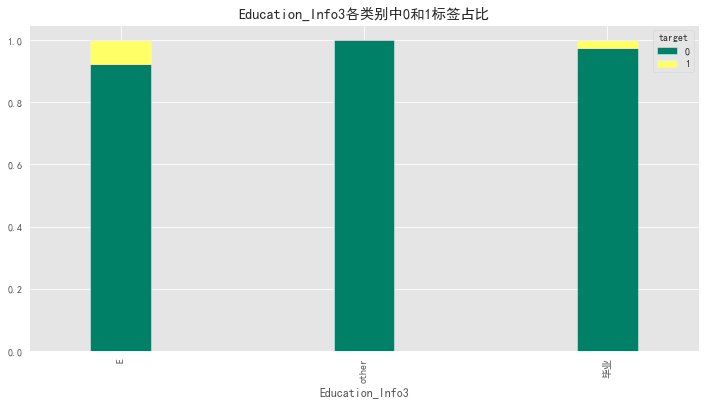

<Figure size 432x288 with 0 Axes>

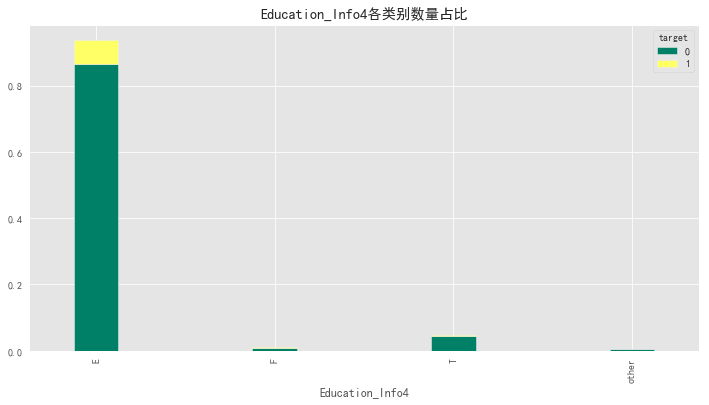

<Figure size 432x288 with 0 Axes>

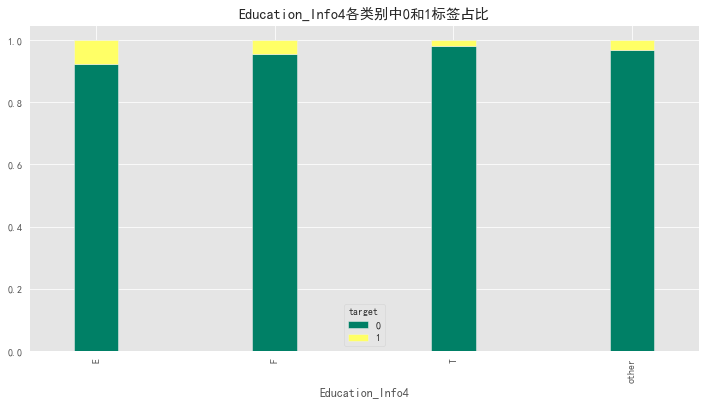

<Figure size 432x288 with 0 Axes>

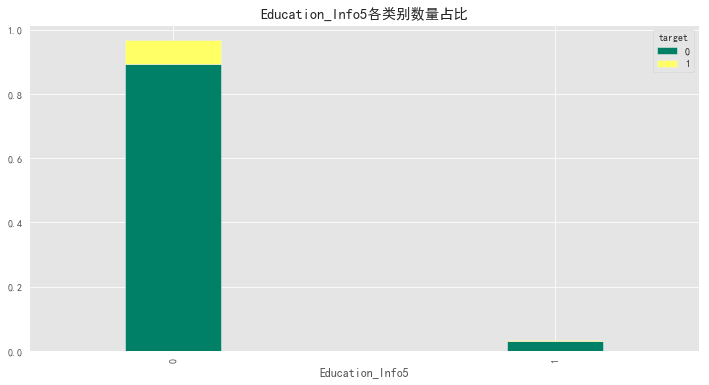

<Figure size 432x288 with 0 Axes>

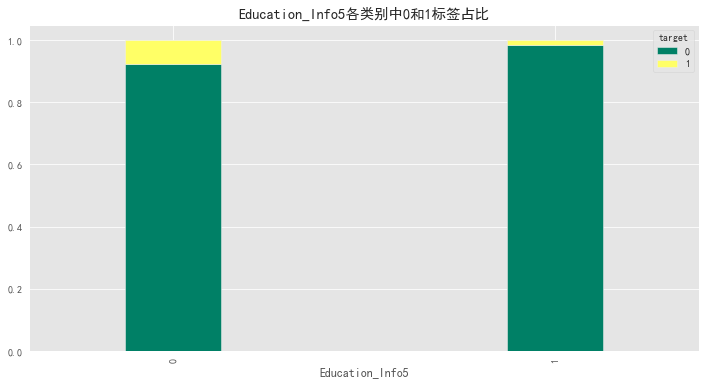

<Figure size 432x288 with 0 Axes>

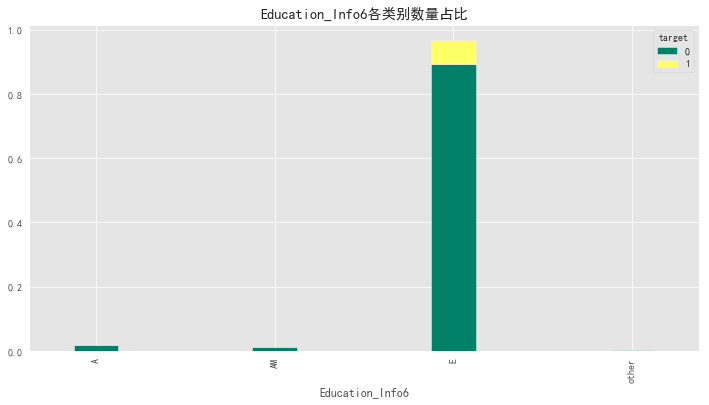

<Figure size 432x288 with 0 Axes>

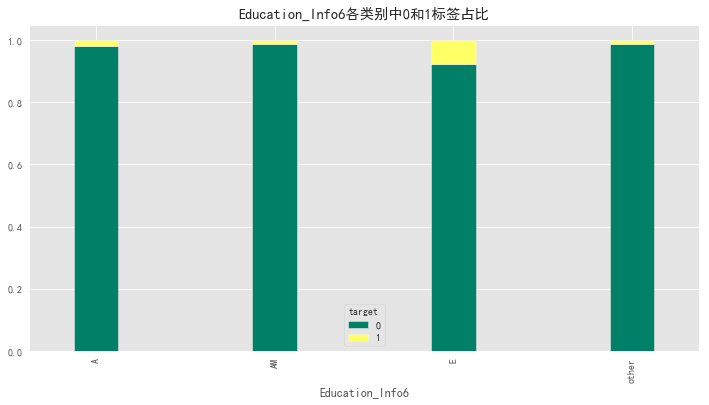

<Figure size 432x288 with 0 Axes>

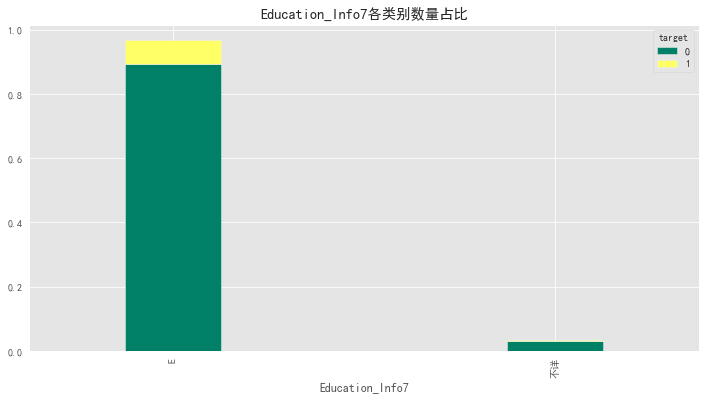

<Figure size 432x288 with 0 Axes>

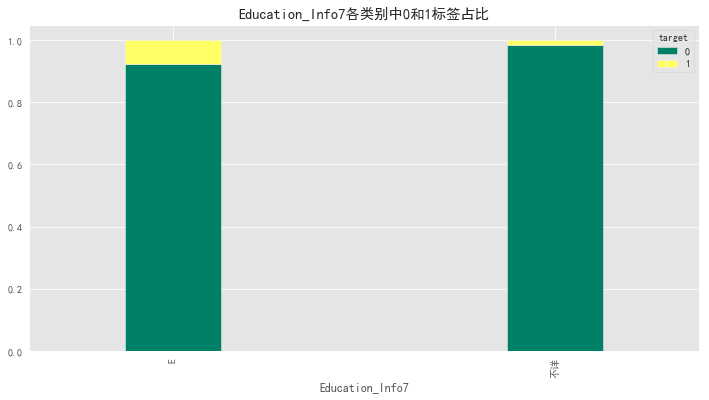

<Figure size 432x288 with 0 Axes>

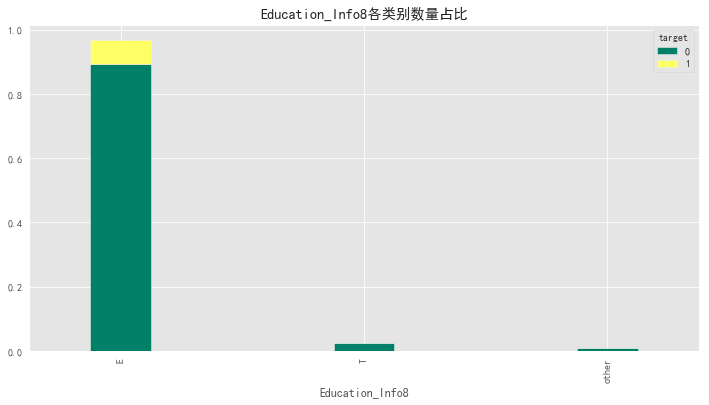

<Figure size 432x288 with 0 Axes>

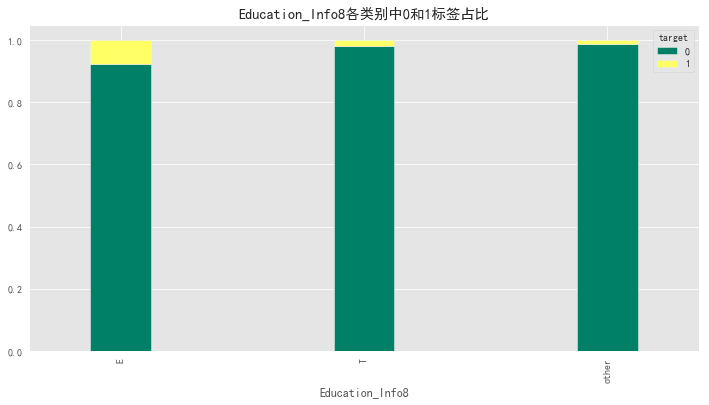

In [48]:
'''
5.4、特征处理
通过可视化结果，特征内存在某几个类别比例过低的情况，将比例低于0.01的类别合并
'''
# 使用feature_list函数创建Education_Info1-8这8个特征名称，并存入edu_list
edu_list = feature_list('Education_Info', 1, 8)
# 使用category_combine函数实现特征内比例低的类别合并
category_combine(featurelist=edu_list)

In [49]:
'''
5.5、数值型特征处理
通过数据处理，Education_Info1-8全部为类别型特征
将Education_Info所有特征进行独热编码转换
'''

# 使用get_dummies方法转换特征
df_dataset = pd.get_dummies(df_dataset, columns=edu_list)
# 展示结果
df_dataset.head()

target  WeblogInfo_4  WeblogInfo_6  WeblogInfo_7  WeblogInfo_8  \
Idx                                                                     
10001       0         1.000         1.000        14.000         0.000   
10002       0         1.000         1.000        14.000         0.000   
10003       0         2.000         2.000         9.000         3.000   
10006       0         1.000         1.000         2.000         0.000   
10007       0         1.000         1.000         3.000         0.000   

       WeblogInfo_14  WeblogInfo_15  WeblogInfo_16  WeblogInfo_17  \
Idx                                                                 
10001          6.000          6.000          0.000          6.000   
10002          0.000          0.000          7.000          7.000   
10003          0.000          0.000          3.000          4.000   
10006          0.000          0.000          0.000          2.000   
10007          0.000          0.000          0.000          3.000   

       WeblogInfo_18  UserInfo_18  ThirdParty_Info_Period1_1  \
Idx                                                            
10001          2.000           29                         10   
10002          0.000           28                          0   
10003          2.000           32                          1   
10006          0.000           33                          9   
10007          0.000           43                          1   

       ThirdParty_Info_Period1_2  ThirdParty_Info_Period1_3  \
Idx                                                           
10001                         47                        167   
10002                          0                         68   
10003                          2                         50   
10006                         54                         56   
10007                          5                         39   

       ThirdParty_Info_Period1_4  ThirdParty_Info_Period1_5  \
Idx                                                           
10001                          0                         25   
10002                        105                         40   
10003                         50                         49   
10006                        125                         38   
10007                         34                         36   

       ThirdParty_Info_Period1_6  ThirdParty_Info_Period1_7  \
Idx                                                           
10001                         65                         68   
10002                          2                        132   
10003                          0                         78   
10006                          0                        136   
10007                         73                          0   

       ThirdParty_Info_Period1_8  ThirdParty_Info_Period1_9  \
Idx                                                           
10001                         34                          2   
10002                         39                          2   
10003                         22                          0   
10006                         45                          2   
10007                          0                          1   

       ThirdParty_Info_Period1_10  ThirdParty_Info_Period1_11  \
Idx                                                             
10001                           1                          10   
10002                           1                           8   
10003                           0                           7   
10006                           1                           9   
10007                           1                           5   

       ThirdParty_Info_Period1_12  ThirdParty_Info_Period1_13  \
Idx                                                             
10001                          63                       27489   
10002                           0                        3839   
10003                           0                        3578   
10006        

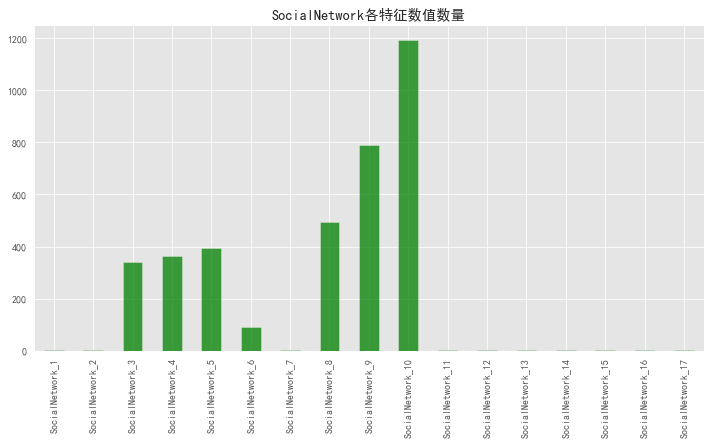

In [50]:
'''
6、SocialNetwork特征数据处理:

6.1、查看SocialNetwork数据总体情况
SocialNetwork共17个特征，全部为数值型

通过可视化结果可知，SocialNetwork1、2、7，SocialNetwork11-17这10个特征内数值类别不超过10个，将这10个特征转换为类别型特征
其他特征数值较多,类型保持不变
'''
# 创建列表social_list，存储SocialNetwork特征名称
social_list = []
# 使用feature_list函数生成SocialNetwork_1-17这17个特征名称，合并入social_list内
social_list.extend(feature_list('SocialNetwork_', 1, 17))
# 创建空字典social_dic，存储每个特征内数值类别数量信息
social_dic = {}
# 遍历social_list内每个特征名称
for i in social_list:
    # 将每个特征内数值类别数存入social_dic，键为特征名，值为类别数量
    social_dic[i] = len(df_dataset[i].unique())
# 创建series，数据为social_dic内的值
social_info = pd.Series(social_dic)
# 通过bar_figure函数可视化每个特征内不同数值类别数量
bar_figure(plot_data=social_info, title='SocialNetwork各特征数值数量', figsize=(12,6))

<Figure size 432x288 with 0 Axes>

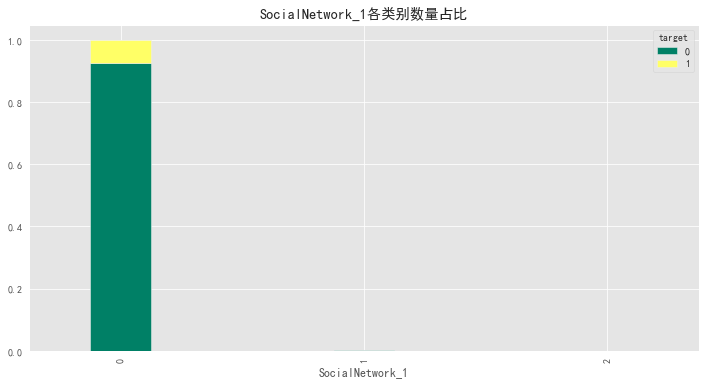

<Figure size 432x288 with 0 Axes>

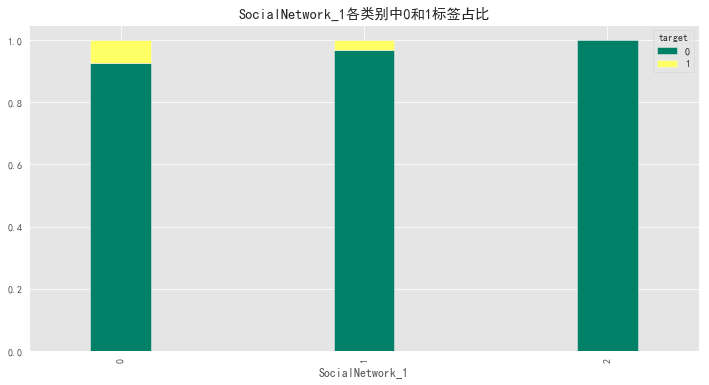

<Figure size 432x288 with 0 Axes>

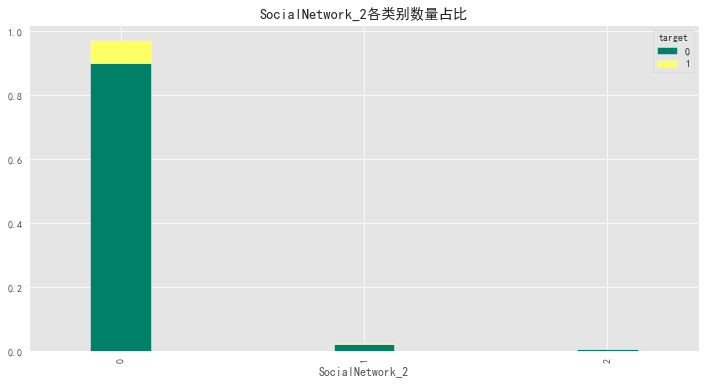

<Figure size 432x288 with 0 Axes>

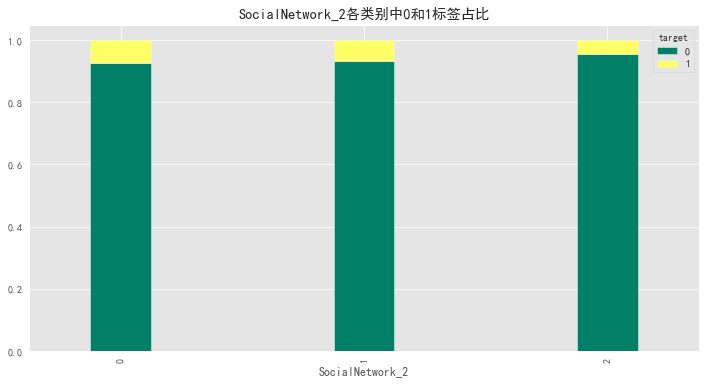

<Figure size 432x288 with 0 Axes>

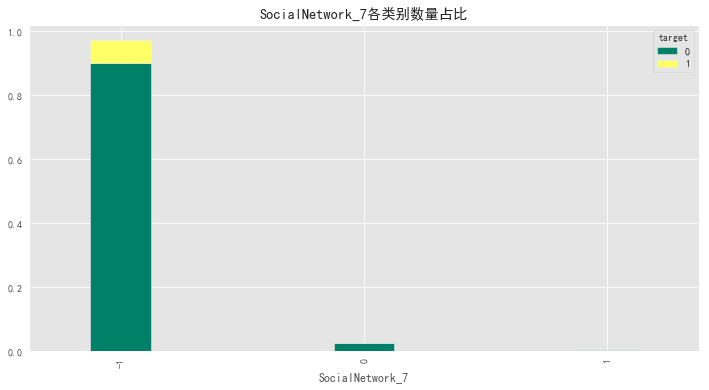

<Figure size 432x288 with 0 Axes>

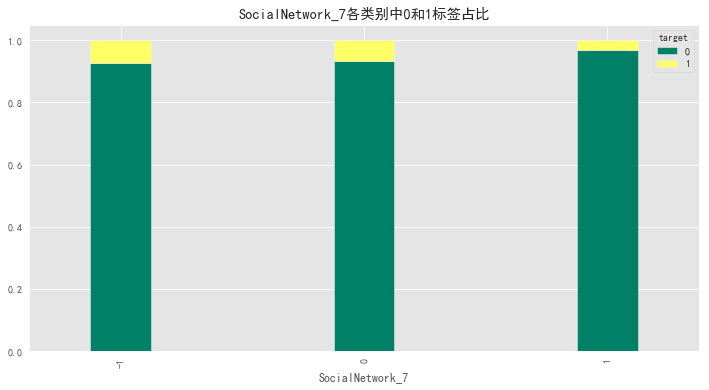

<Figure size 432x288 with 0 Axes>

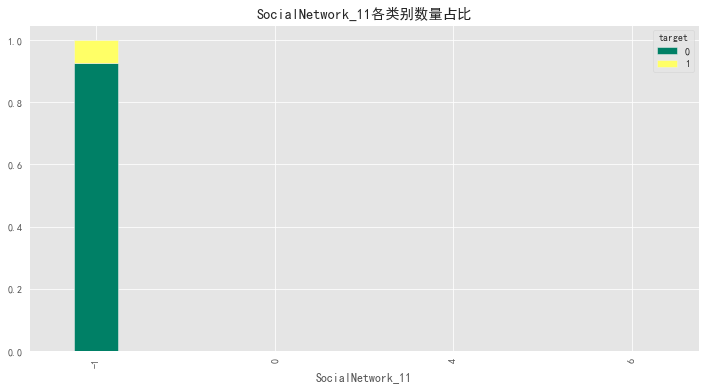

<Figure size 432x288 with 0 Axes>

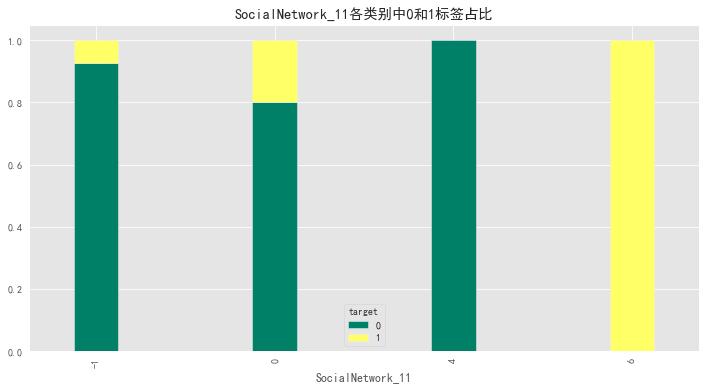

<Figure size 432x288 with 0 Axes>

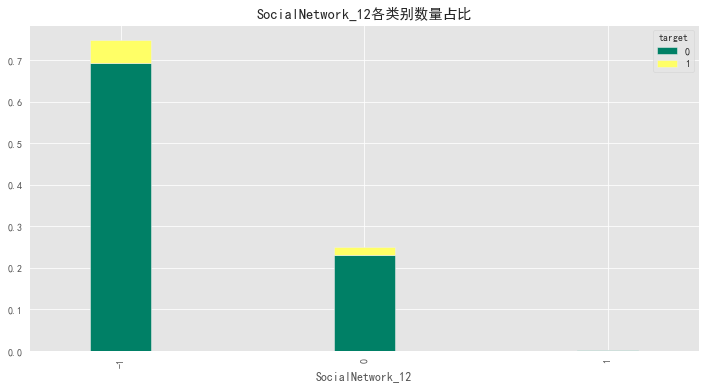

<Figure size 432x288 with 0 Axes>

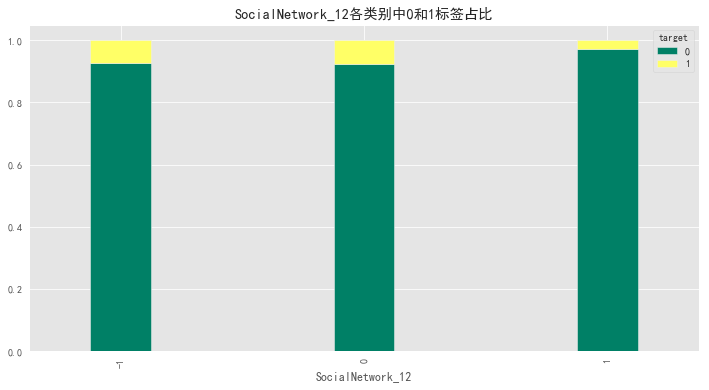

<Figure size 432x288 with 0 Axes>

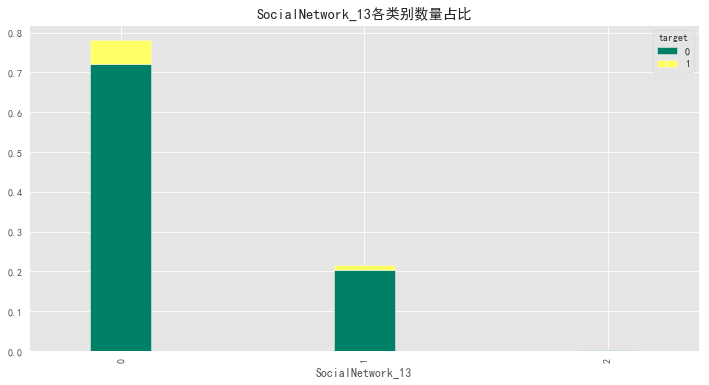

<Figure size 432x288 with 0 Axes>

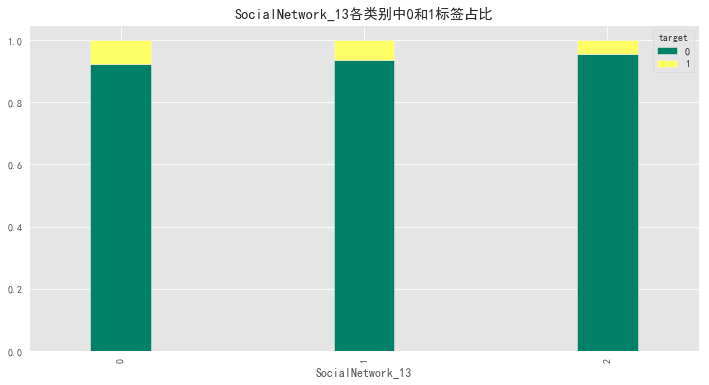

<Figure size 432x288 with 0 Axes>

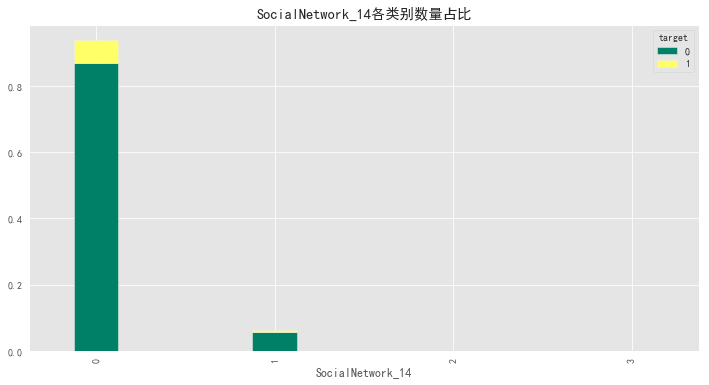

<Figure size 432x288 with 0 Axes>

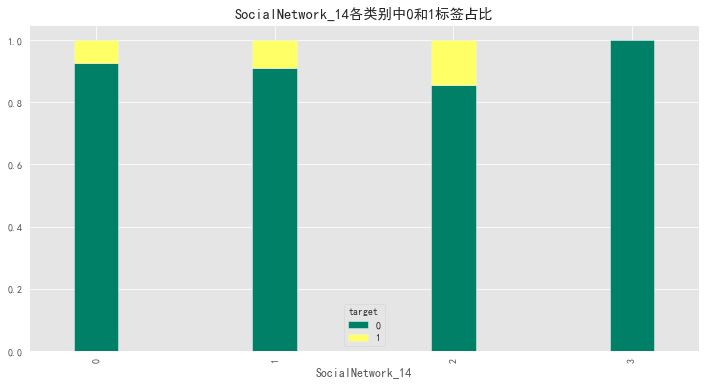

<Figure size 432x288 with 0 Axes>

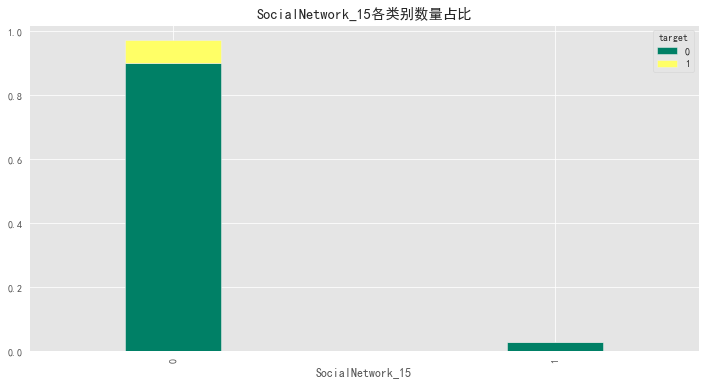

<Figure size 432x288 with 0 Axes>

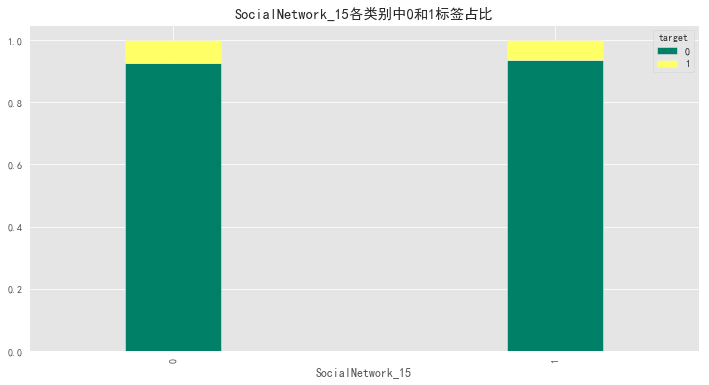

<Figure size 432x288 with 0 Axes>

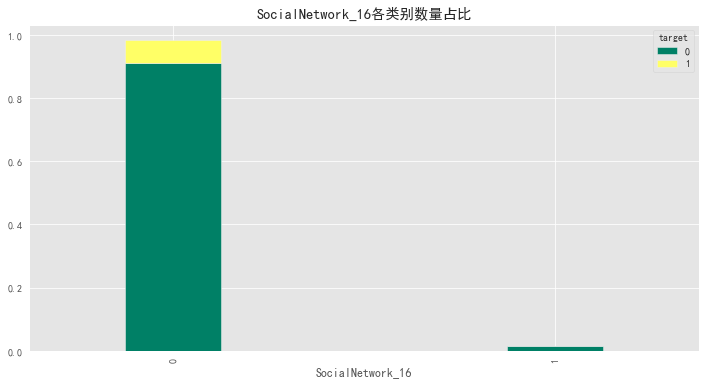

<Figure size 432x288 with 0 Axes>

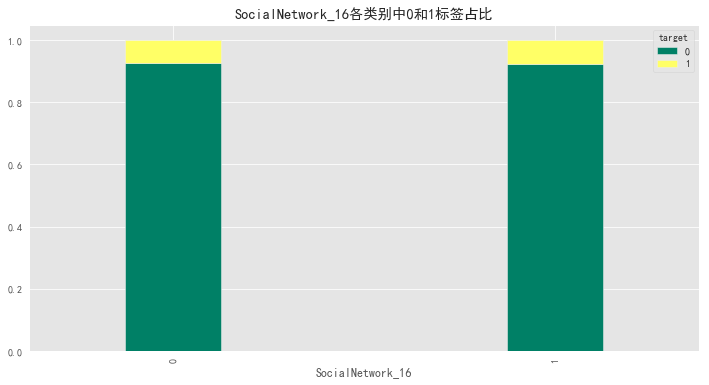

<Figure size 432x288 with 0 Axes>

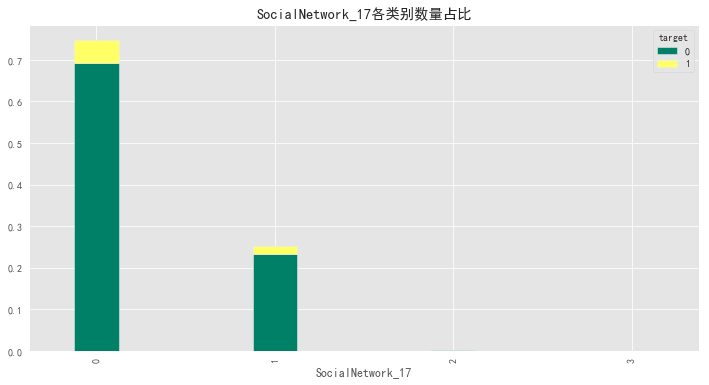

<Figure size 432x288 with 0 Axes>

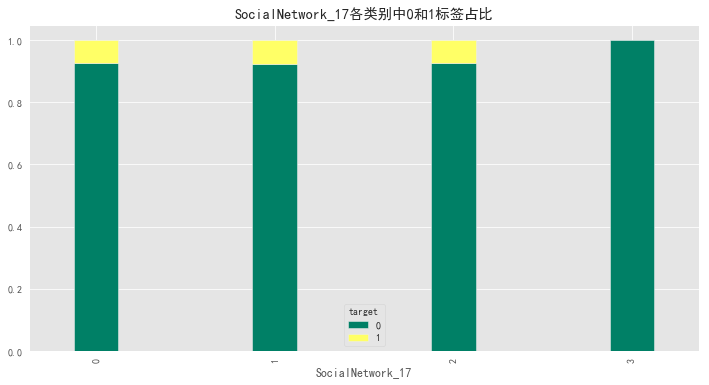

In [51]:
'''
6.2、SocialNetwork特征转换
将数值种类少的特征转换为类别型特征
'''
# 创建social_category_list列表，里面存储需要转换为类别型特征的特征名称
social_category_list = ['SocialNetwork_1', 'SocialNetwork_2', 'SocialNetwork_7']
# 利用feature_list函数生成SocialNetwork_11-17这7个特征名称，并添加到social_category_list内
social_category_list.extend(feature_list('SocialNetwork_', 11, 17))
# 遍历social_category_list内每个特征名称
for feature in social_category_list:
    # 将特征类型转换为类别型
    df_dataset[feature] = df_dataset[feature].astype(str) 
# 使用figures_in_featurelist函数可视化结果
figures_in_featurelist(featurelist=social_category_list, name='socialnetwork')


<Figure size 432x288 with 0 Axes>

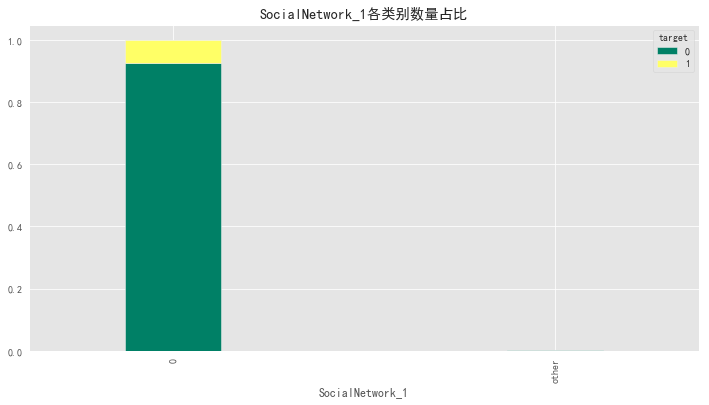

<Figure size 432x288 with 0 Axes>

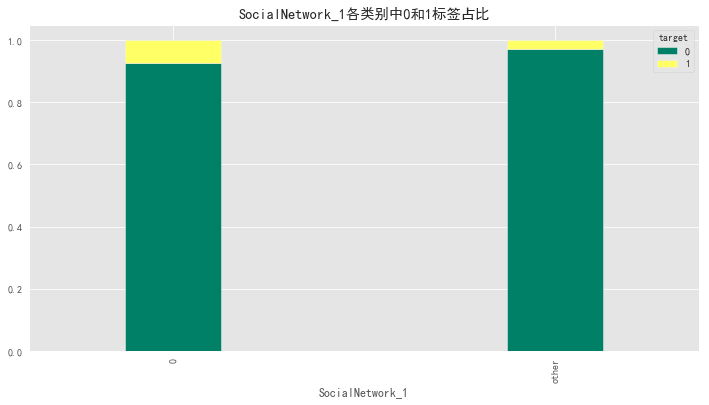

<Figure size 432x288 with 0 Axes>

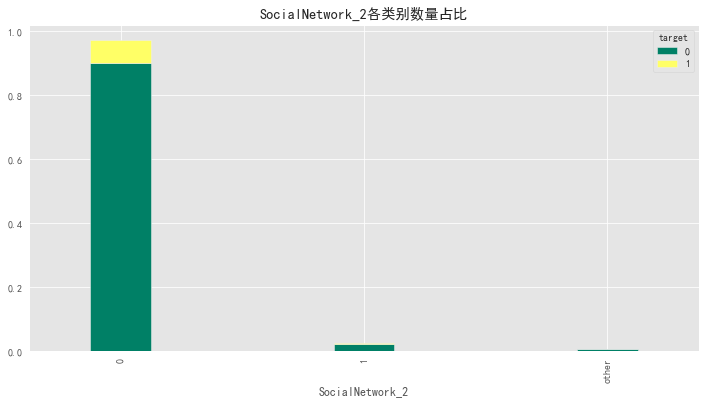

<Figure size 432x288 with 0 Axes>

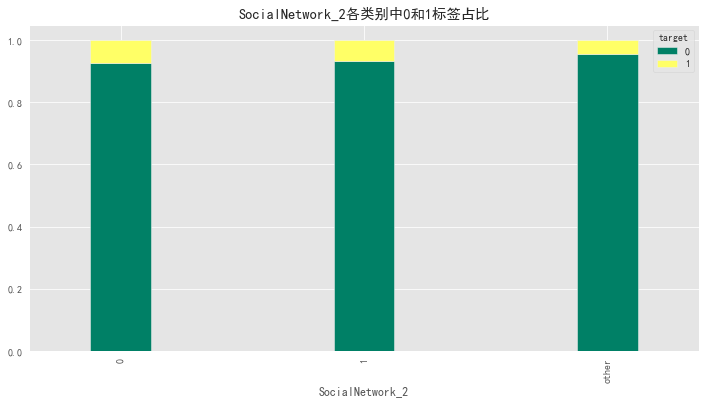

<Figure size 432x288 with 0 Axes>

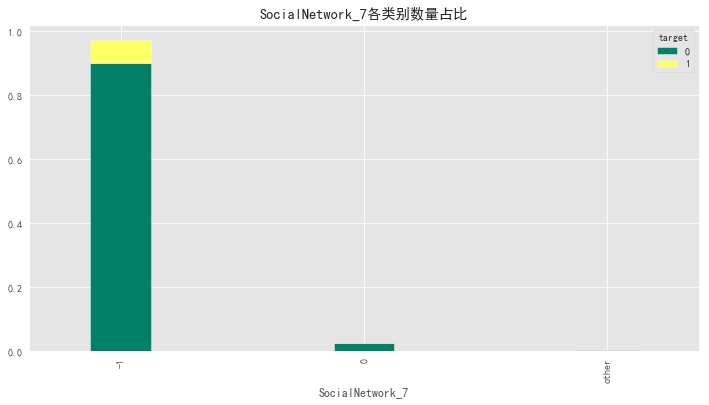

<Figure size 432x288 with 0 Axes>

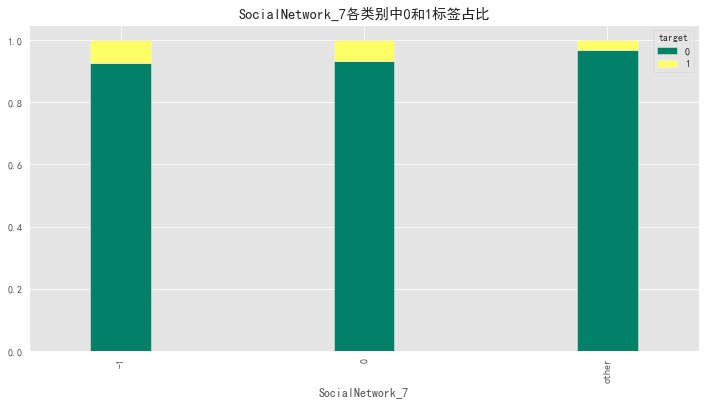

<Figure size 432x288 with 0 Axes>

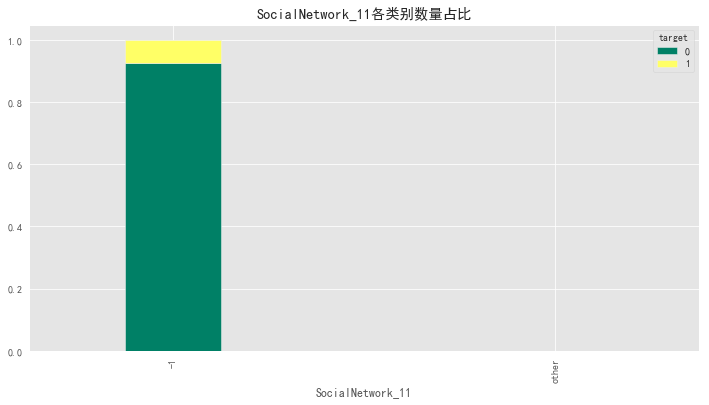

<Figure size 432x288 with 0 Axes>

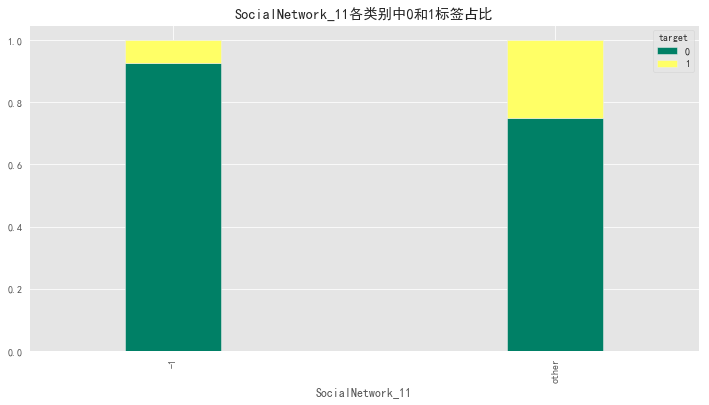

<Figure size 432x288 with 0 Axes>

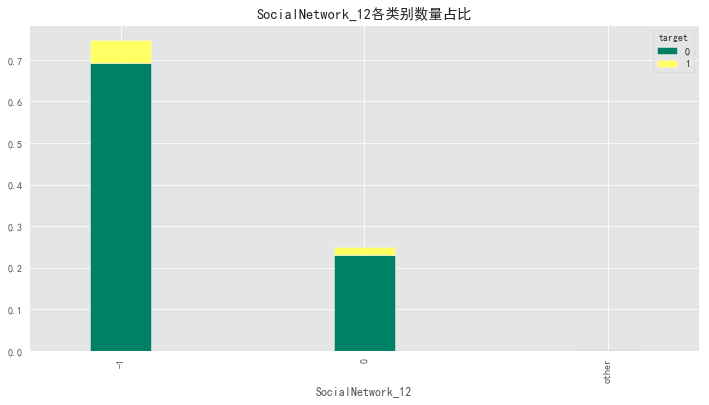

<Figure size 432x288 with 0 Axes>

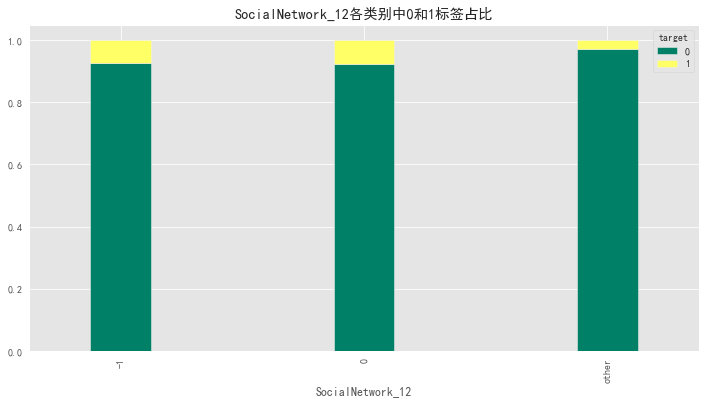

<Figure size 432x288 with 0 Axes>

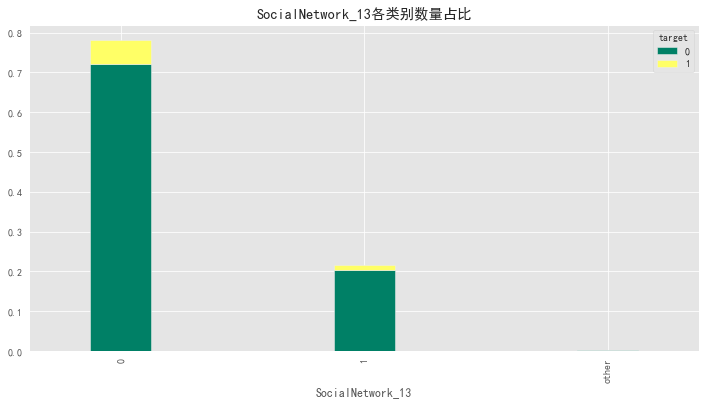

<Figure size 432x288 with 0 Axes>

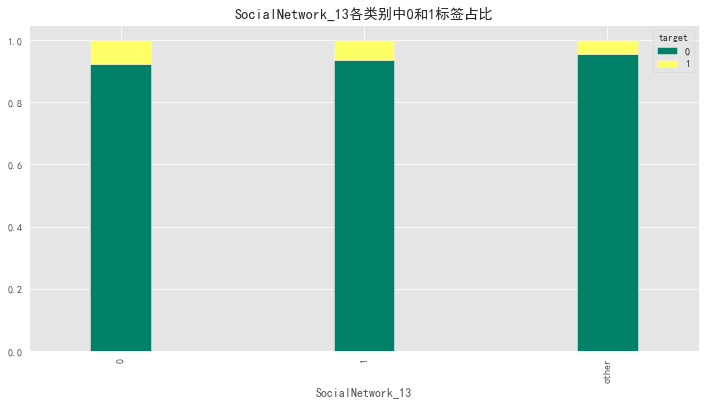

<Figure size 432x288 with 0 Axes>

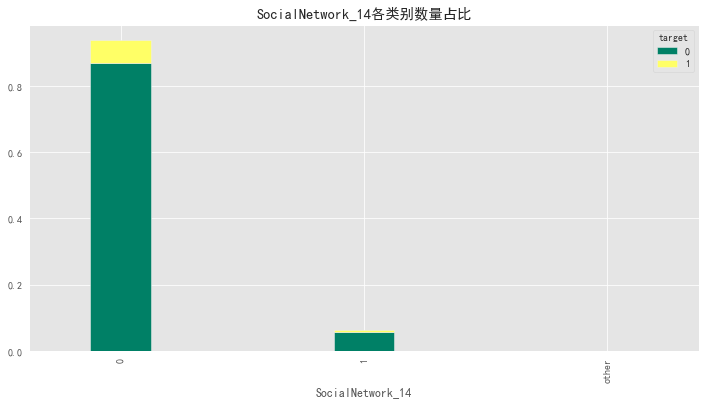

<Figure size 432x288 with 0 Axes>

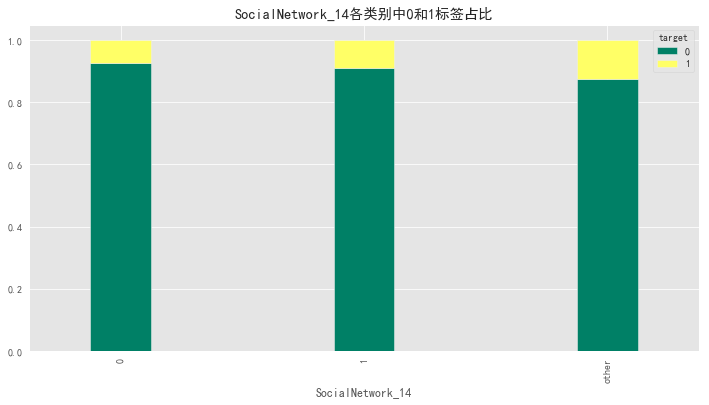

<Figure size 432x288 with 0 Axes>

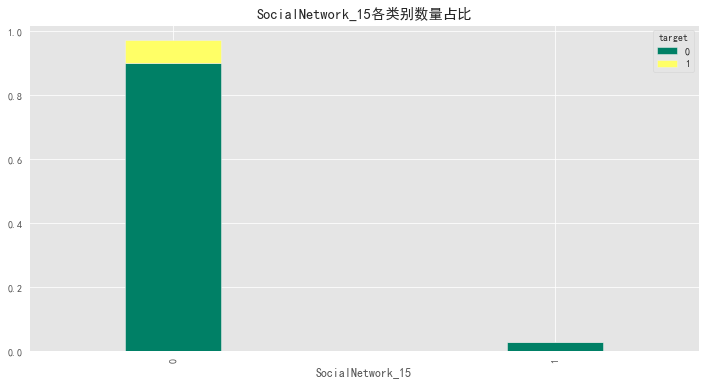

<Figure size 432x288 with 0 Axes>

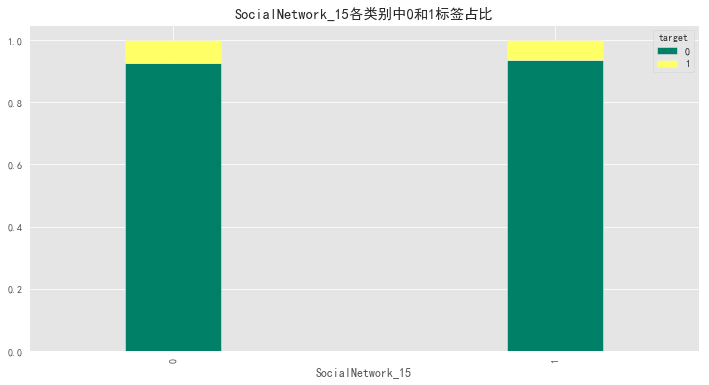

<Figure size 432x288 with 0 Axes>

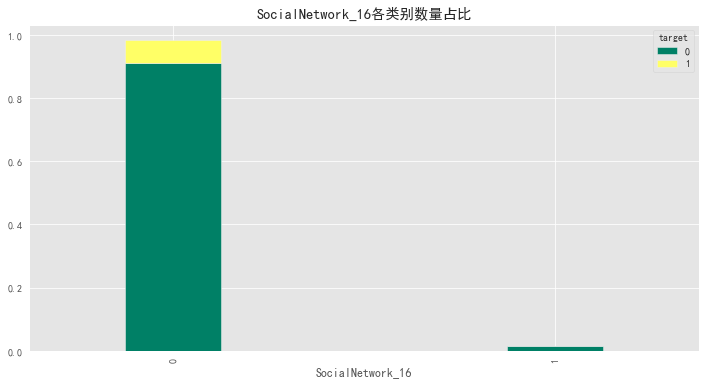

<Figure size 432x288 with 0 Axes>

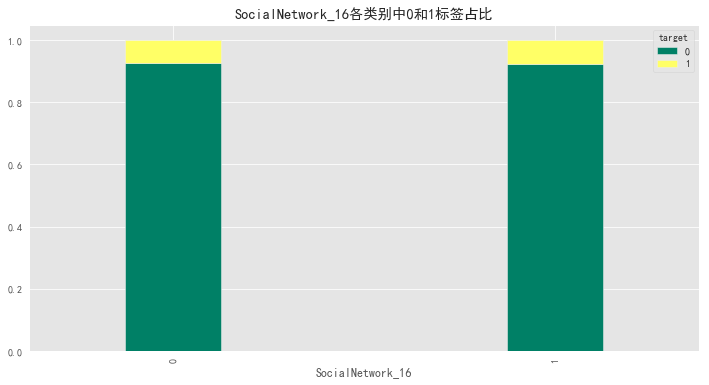

<Figure size 432x288 with 0 Axes>

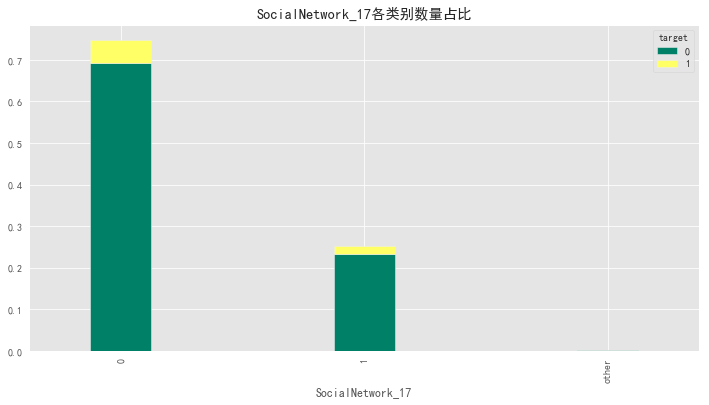

<Figure size 432x288 with 0 Axes>

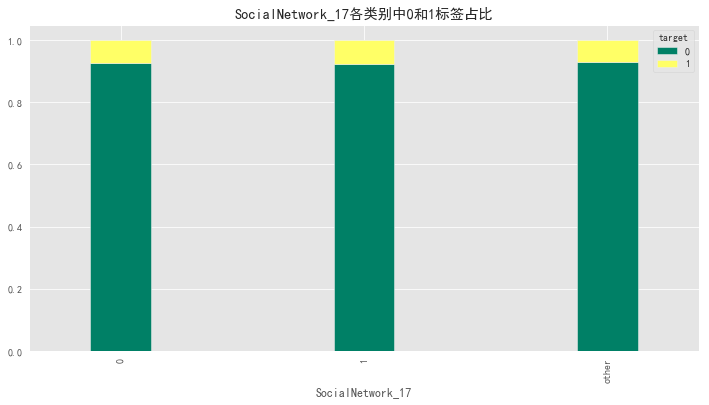

In [52]:
'''
6.2、SocialNetwork特征转换
通过可视化结果可知，SocialNetwork特征内同样存在特征内类别比例过低的情况，进行类别合并处理
'''
# 使用category_combine函数实现比例过低的类别合并
category_combine(featurelist=social_category_list)

In [53]:
'''
6.2、SocialNetwork特征转换
通过可视化结果可知，SocialNetwork_7、11、12这三个特征内‘-1’(缺失值)占比都在80%以上，缺失值过多
删除这3个特征，其余特征保留
'''
df_dataset.drop(['SocialNetwork_7', 'SocialNetwork_11', 'SocialNetwork_12'], axis=1, inplace=True)

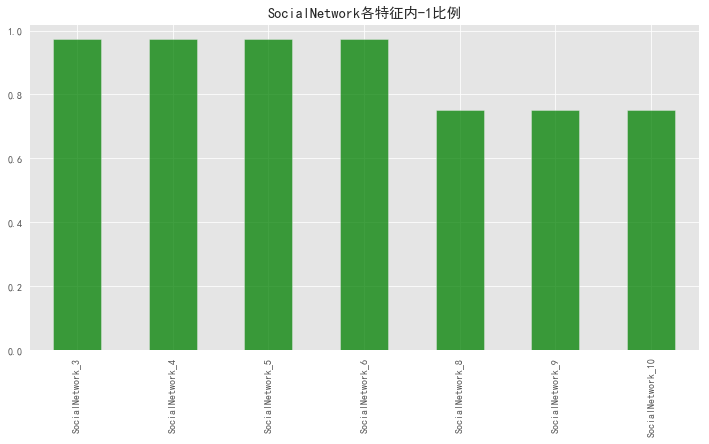

In [54]:
'''
6.3、SocialNetwork数值型特征处理
SocialNetwork_3-6、SocialNetwork_8-10这7个特征内数值种类较多，并且在这7个特征内‘-1’(缺失值)的占比都最多
'''
# 创建social_numerical_list列表，存储SocialNetwork数值型特征名称
social_numerical_list = []
# 使用feature_list函数生成SocialNetwork_3-6这4个特征名称，并将结果添加入social_numerical_list内
social_numerical_list.extend(feature_list('SocialNetwork_', 3, 6))
# 使用feature_list函数生成SocialNetwork_8-10这3个特征名称，并将结果添加入social_numerical_list内
social_numerical_list.extend(feature_list('SocialNetwork_', 8, 10))
# 创建social_numerical_counts列表，存储每个数值型特征内'-1'的比例
social_numerical_counts = []
# 遍历social_numerical_list内每个特征名称
for feature in social_numerical_list:
    # 计算每个特征内‘-1’的比例
    proportion = df_dataset[feature].value_counts().values[0] / len(df_dataset)
    # 使用append函数将比例值添加到social_numerical_counts内
    social_numerical_counts.append(proportion)
# 创建series，数据为social_numerical_counts内的每个特征中‘-1’的值，索引为每个特征名称
count_proportion = pd.Series(data=social_numerical_counts, index=social_numerical_list)
# 使用bar_figure函数可视化结果
bar_figure(plot_data=count_proportion, title='SocialNetwork各特征内-1比例', figsize=(12,6)) 

In [55]:
'''
6.4、SocialNetwork特征处理
通过可视化结果可知，这7个特征中，有4个特征‘-1’(缺失值)比例在90%以上，3个在75%以上，缺失值比例过高
因此这些特征做删除处理
'''
df_dataset.drop(social_numerical_list, axis=1, inplace=True)


In [56]:
'''
6.5、SocialNetwork特征处理
通过处理，保留的SocialNetwork1、2、13-17全部为类别型特征
对以上特征进行独热编码转换
'''
# 创建social_dummies_list列表，存储需要独热编码转换的特征名称
social_dummies_list = ['SocialNetwork_1', 'SocialNetwork_2']
# 使用feature_list函数生成SocialNetwork_13-17这5个特征名称，并添加到social_dummies_list内
social_dummies_list.extend(feature_list('SocialNetwork_', 13, 17))
# 使用get_dummies方法转换特征
df_dataset = pd.get_dummies(df_dataset, columns=social_dummies_list)
# 展示结果
df_dataset.head()

target  WeblogInfo_4  WeblogInfo_6  WeblogInfo_7  WeblogInfo_8  \
Idx                                                                     
10001       0         1.000         1.000        14.000         0.000   
10002       0         1.000         1.000        14.000         0.000   
10003       0         2.000         2.000         9.000         3.000   
10006       0         1.000         1.000         2.000         0.000   
10007       0         1.000         1.000         3.000         0.000   

       WeblogInfo_14  WeblogInfo_15  WeblogInfo_16  WeblogInfo_17  \
Idx                                                                 
10001          6.000          6.000          0.000          6.000   
10002          0.000          0.000          7.000          7.000   
10003          0.000          0.000          3.000          4.000   
10006          0.000          0.000          0.000          2.000   
10007          0.000          0.000          0.000          3.000   

       WeblogInfo_18  UserInfo_18  ThirdParty_Info_Period1_1  \
Idx                                                            
10001          2.000           29                         10   
10002          0.000           28                          0   
10003          2.000           32                          1   
10006          0.000           33                          9   
10007          0.000           43                          1   

       ThirdParty_Info_Period1_2  ThirdParty_Info_Period1_3  \
Idx                                                           
10001                         47                        167   
10002                          0                         68   
10003                          2                         50   
10006                         54                         56   
10007                          5                         39   

       ThirdParty_Info_Period1_4  ThirdParty_Info_Period1_5  \
Idx                                                           
10001                          0                         25   
10002                        105                         40   
10003                         50                         49   
10006                        125                         38   
10007                         34                         36   

       ThirdParty_Info_Period1_6  ThirdParty_Info_Period1_7  \
Idx                                                           
10001                         65                         68   
10002                          2                        132   
10003                          0                         78   
10006                          0                        136   
10007                         73                          0   

       ThirdParty_Info_Period1_8  ThirdParty_Info_Period1_9  \
Idx                                                           
10001                         34                          2   
10002                         39                          2   
10003                         22                          0   
10006                         45                          2   
10007                          0                          1   

       ThirdParty_Info_Period1_10  ThirdParty_Info_Period1_11  \
Idx                                                             
10001                           1                          10   
10002                           1                           8   
10003                           0                           7   
10006                           1                           9   
10007                           1                           5   

       ThirdParty_Info_Period1_12  ThirdParty_Info_Period1_13  \
Idx                                                             
10001                          63                       27489   
10002                           0                        3839   
10003                           0                        3578   
10006        

<Figure size 432x288 with 0 Axes>

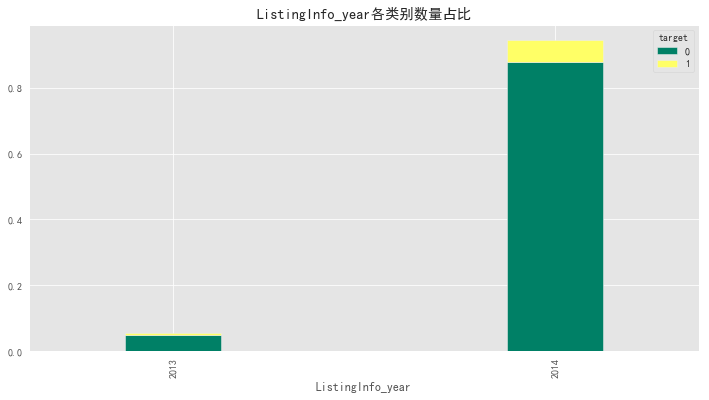

<Figure size 432x288 with 0 Axes>

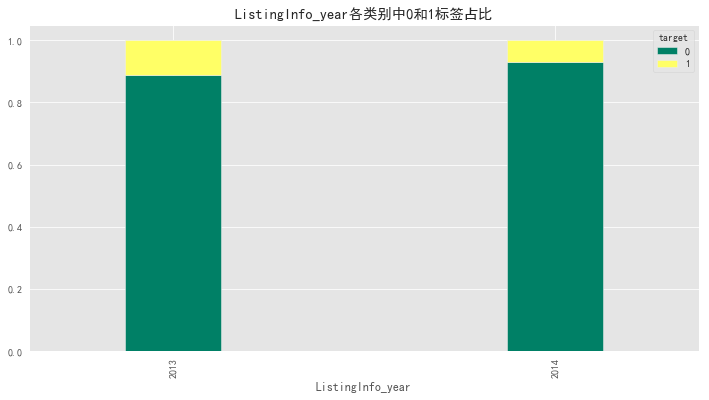

<Figure size 432x288 with 0 Axes>

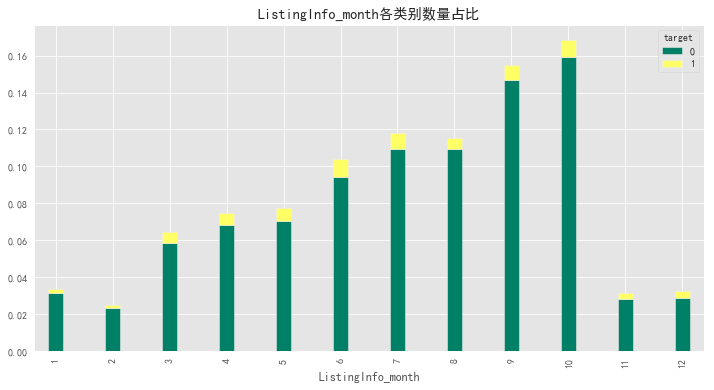

<Figure size 432x288 with 0 Axes>

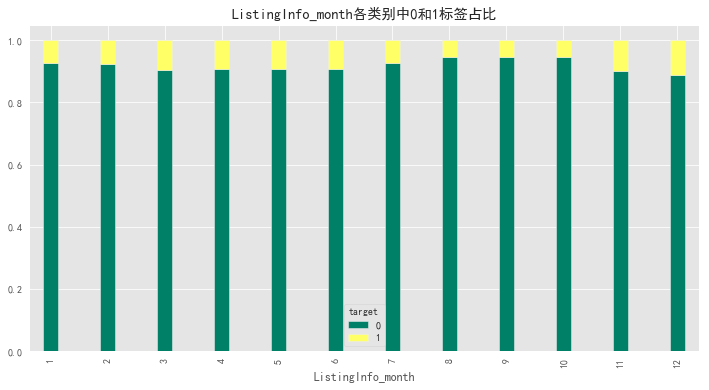

<Figure size 432x288 with 0 Axes>

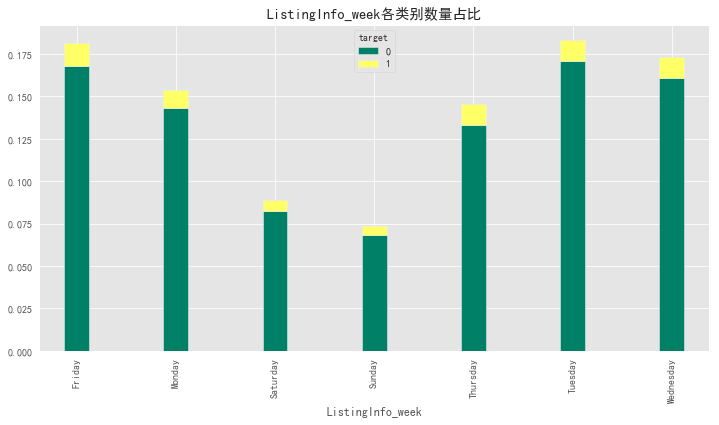

<Figure size 432x288 with 0 Axes>

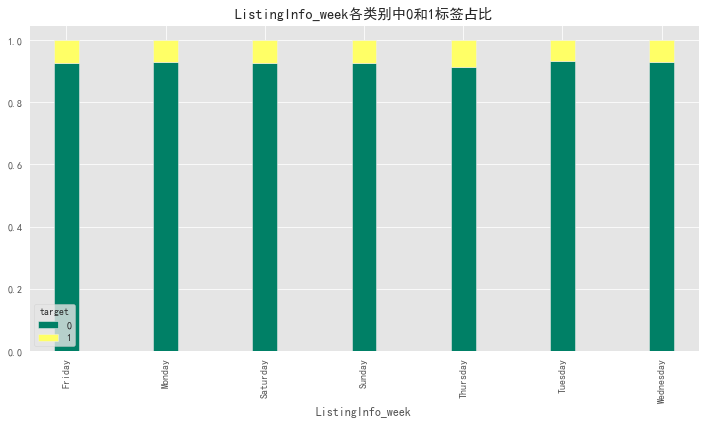

In [57]:
'''
7、ListingInfo数据处理:
7.1 ListingInfo为日期数据，做出如下处理:
(1) 新增加ListingInfo_year特征，数据为日期的年份
(2) 新增加ListingInfo_month特征，数据为日期的月份
(3) 新增加ListingInfo_week特征，数据为日期的星期
以上全部为类别型特征

通过可视化结果可知如下信息:
(1) 年份:2014年数量占比远高于2013年，2013年标签0的占比低于2014年
(2) 月份:3-10月数量占比呈现出明显上升趋势，10月份数量最多
(3) 星期:周3、4、5数量占比最多，周1和周2略低，周6和周日最少

'''
# 使用pd.to_datetime方法将ListingInfo数据转换为时间序列数据
df_dataset['ListingInfo'] = pd.to_datetime(df_dataset['ListingInfo'])
# 使用dt.year方法生成ListingInfo的年份信息，并存入df_dataset['ListingInfo_year']
df_dataset['ListingInfo_year'] = df_dataset['ListingInfo'].dt.year
# 使用dt.month方法生成ListingInfo的月份信息，并存入df_dataset['ListingInfo_month']
df_dataset['ListingInfo_month'] = df_dataset['ListingInfo'].dt.month
# 使用dt.weekday_name方法生成ListingInfo中日期所对应的星期数，并存入df_dataset['ListingInfo_week']
df_dataset['ListingInfo_week'] = df_dataset['ListingInfo'].dt.weekday_name
# 创建列表listing_list,存储ListingInfo_year、ListingInfo_month和ListingInfo_week特征名称
listing_list = ['ListingInfo_year', 'ListingInfo_month', 'ListingInfo_week']
# 可视化这新增的三个特征的分布结果
figures_in_featurelist(featurelist=listing_list, name='ListingInfo_')


In [58]:
'''
7.2 将ListingInfo_year和ListingInfo_month特征转换为类别型，并删除原始ListingInfo特征
'''
# 使用astype方法将ListingInfo_year特征转换为类别型
df_dataset['ListingInfo_year'] = df_dataset['ListingInfo_year'].astype(str)
# 使用astype方法将ListingInfo_month特征转换为类别型
df_dataset['ListingInfo_month'] = df_dataset['ListingInfo_month'].astype(str)
# 删除原始ListingInfo特征
df_dataset.drop('ListingInfo', axis=1, inplace=True)


In [59]:
'''
7.3 特征处理
对ListingInfo数据处理新生成3个特征：
ListingInfo_year、ListingInfo_month和ListingInfo_week，这3个特征均为类别型特征
'''
# 创建列表listing_dummies_list，用来存储独热编码转换的特征名称
listing_dummies_list = ['ListingInfo_year', 'ListingInfo_month', 'ListingInfo_week']
# 使用get_dummies方法转换特征
df_dataset = pd.get_dummies(df_dataset, columns=listing_dummies_list)
# 展示结果
df_dataset.head()

target  WeblogInfo_4  WeblogInfo_6  WeblogInfo_7  WeblogInfo_8  \
Idx                                                                     
10001       0         1.000         1.000        14.000         0.000   
10002       0         1.000         1.000        14.000         0.000   
10003       0         2.000         2.000         9.000         3.000   
10006       0         1.000         1.000         2.000         0.000   
10007       0         1.000         1.000         3.000         0.000   

       WeblogInfo_14  WeblogInfo_15  WeblogInfo_16  WeblogInfo_17  \
Idx                                                                 
10001          6.000          6.000          0.000          6.000   
10002          0.000          0.000          7.000          7.000   
10003          0.000          0.000          3.000          4.000   
10006          0.000          0.000          0.000          2.000   
10007          0.000          0.000          0.000          3.000   

       WeblogInfo_18  UserInfo_18  ThirdParty_Info_Period1_1  \
Idx                                                            
10001          2.000           29                         10   
10002          0.000           28                          0   
10003          2.000           32                          1   
10006          0.000           33                          9   
10007          0.000           43                          1   

       ThirdParty_Info_Period1_2  ThirdParty_Info_Period1_3  \
Idx                                                           
10001                         47                        167   
10002                          0                         68   
10003                          2                         50   
10006                         54                         56   
10007                          5                         39   

       ThirdParty_Info_Period1_4  ThirdParty_Info_Period1_5  \
Idx                                                           
10001                          0                         25   
10002                        105                         40   
10003                         50                         49   
10006                        125                         38   
10007                         34                         36   

       ThirdParty_Info_Period1_6  ThirdParty_Info_Period1_7  \
Idx                                                           
10001                         65                         68   
10002                          2                        132   
10003                          0                         78   
10006                          0                        136   
10007                         73                          0   

       ThirdParty_Info_Period1_8  ThirdParty_Info_Period1_9  \
Idx                                                           
10001                         34                          2   
10002                         39                          2   
10003                         22                          0   
10006                         45                          2   
10007                          0                          1   

       ThirdParty_Info_Period1_10  ThirdParty_Info_Period1_11  \
Idx                                                             
10001                           1                          10   
10002                           1                           8   
10003                           0                           7   
10006                           1                           9   
10007                           1                           5   

       ThirdParty_Info_Period1_12  ThirdParty_Info_Period1_13  \
Idx                                                             
10001                          63                       27489   
10002                           0                        3839   
10003                           0                        3578   
10006        

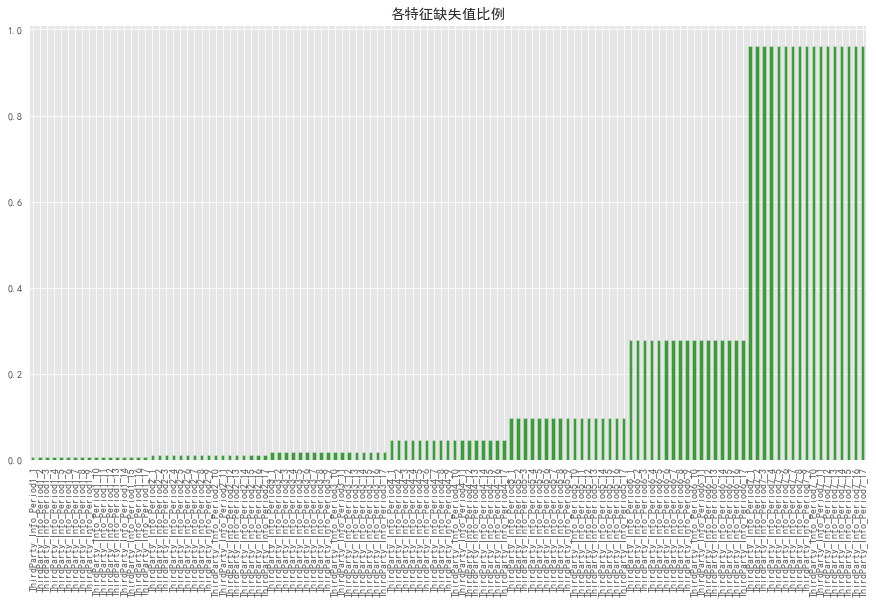

In [60]:
'''
8、ThirdParty_Info_Period特征处理:
8.1:查看ThirdParty_Info_Period每个特征(共7*17=119个特征)缺失值(-1)数量

'''
# 创建ThirdParty_nan_dic，存储每个特征缺失值信息，键为特征名，值为缺失值占比
ThirdParty_nan_dic = {}
# 创建ThirdParty_list，存储特征名称
ThirdParty_list = []
# 生成119个特征名
for i in range(1,8):
    # 构建特征名，ThirdParty_Info_Period+‘i’+‘_’
    name = 'ThirdParty_Info_Period'+str(i)+'_'
    # 继续构建特征名
    for j in range(1,18):
        # 特征名ThirdParty_Info_Period+‘i’+‘_’+‘j’     
        feature_name = name + str(j)
        # 将特征名称加入ThirdParty_list内
        ThirdParty_list.append(feature_name)
# 遍历ThirdParty_list内每个特征名称       
for feature in ThirdParty_list:
    # 计算每个特征内‘-1’ 的占比，将结果存入proportion_nan
    proportion_nan = df_dataset[feature].value_counts().loc[-1]/len(df_dataset)
    # 将proportion_nan存入ThirdParty_nan_dic内，键为特征名称
    ThirdParty_nan_dic[feature] = proportion_nan
# 创建series，数据为每个特征中-1的占比
nan_series = pd.Series(ThirdParty_nan_dic)
# 使用bar_figure函数可视化结果
bar_figure(nan_series, '各特征缺失值比例',  (15,8))

In [61]:
'''
8.2:删除-1(缺失值)过多的特征
通过可视化可知，ThirdParty_Info_Period7_1-17这17个特征内-1的值都超过90%，缺失值过多，删除这17个特征
'''
# 使用feature_list函数生成ThirdParty_Info_Period7_1-17共17个特征名称，存入third_nan_list内
third_drop_list = feature_list('ThirdParty_Info_Period7_', 1, 17)
# 使用drop方法删除third_nan_list内存储的这17个特征
df_dataset.drop(third_drop_list, axis=1, inplace=True)

In [62]:
'''
8.3:相同Period特征求和，并比较各个Period
ThirdParty_Info_Period特征共有6个(已经删除掉Period7的所有特征)Period，每个Period内分别有17个特征
首先对每个Period内所有特征值求和，并比较各个Period
'''
# 使用feature_list函数创建third_period_sum1-6这6个新特征名称，并将结果存入third_period_sum
third_period_sum = feature_list('third_period_sum', 1, 6)
# 创建Third_Period_list，存储ThirdParty_Info_Period的6个period特征
Third_Period_list = ['ThirdParty_Info_Period1_', 'ThirdParty_Info_Period2_', 'ThirdParty_Info_Period3_', 
                     'ThirdParty_Info_Period4_', 'ThirdParty_Info_Period5_', 'ThirdParty_Info_Period6_']
# 遍历Third_Period_list内每个period特征
for i in Third_Period_list:
    # 使用feature_list函数创建每个period内的17个特征
    lst = feature_list(i, 1, 17)
    # 提取Third_Period_list内i元素所在的索引
    index = Third_Period_list.index(i)
    # 将i对应的索引对应到third_period_sum内，提取third_period_sum内的特征名作为新特征
    # 将每个period内的17个特征求和，存入third_period_sum新特征内
    df_dataset[third_period_sum[index]] = df_dataset[lst].sum(axis=1)
# 展示结果
df_dataset[third_period_sum].head()

third_period_sum1  third_period_sum2  third_period_sum3  \
Idx                                                              
10001              55470              67745             107860   
10002              27191              65020             102982   
10003              18135              21358              17539   
10006              27615              43190              35988   
10007               2901               7239               6866   

       third_period_sum4  third_period_sum5  third_period_sum6  
Idx                                                             
10001              27223              47741              20593  
10002             138520             112180                -17  
10003              15039              22734              41193  
10006              26970              38884              35509  
10007               4488               5921                -17

In [63]:
'''
8.3:相同Period特征求和，并比较各个Period
其次，比较各个求和的Period，third_period_sum特征两两比较(相除)
'''
# 创建函数calculate_gradient，用于对df_dataset内两个Third_Period_Info特征之间相除比较
def calculate_gradient(feature1, feature2, new_feature):
    '''
    该函数功能是对df_dataset内两个Third_Period_Info特征之间相除比较
    由于特征内存在0和-1，因此在做除法时列举出几种特殊情况，进行特殊处理
    feature1:代表df_dataset内的Third_Period_Info特征名称
    feature2:代表df_dataset内的Third_Period_Info特征名称
    new_feature:代表两个特征相除后得到的新特征
    '''
    # 两个特征相除，并将结果存入新特征new_feature内
    df_dataset[new_feature] = df_dataset[feature2]/df_dataset[feature1]
    # 两个特征同时为-1的情况，将所有满足条件的索引存入index1
    index1 = df_dataset[(df_dataset[feature1]<0)&(df_dataset[feature2]<0)].index
    # 在新特征内，对index1的索引位置的值全部设为-8
    df_dataset[new_feature][index1] = -8
    # 两个特征中，前一个为-1，后一个为0的情况，将所有满足条件的索引存入index2
    index2 = df_dataset[(df_dataset[feature1]<0)&(df_dataset[feature2]==0)].index
    # 在新特征内，对index2的索引位置的值全部设为-7
    df_dataset[new_feature][index2] = -7
    # 两个特征中，前一个为0，后一个为-1的情况，将所有满足条件的索引存入index3
    index3 = df_dataset[(df_dataset[feature1]==0)&(df_dataset[feature2]<0)].index
    # 在新特征内，对index3的索引位置的值全部设为-6
    df_dataset[new_feature][index3] = -6
    # 两个特征同时为0的情况，将所有满足条件的索引存入index4
    index4 = df_dataset[(df_dataset[feature1]==0)&(df_dataset[feature2]==0)].index
    # 在新特征内，对index4的索引位置的值全部设为-5
    df_dataset[new_feature][index4] = -5
    # 两个特征中，前一个为正，后一个为-1的情况，将所有满足条件的索引存入index5
    index5 = df_dataset[(df_dataset[feature1]>0)&(df_dataset[feature2]<0)].index
    # 在新特征内，对index5的索引位置的值全部设为-4
    df_dataset[new_feature][index5] = -4
    # 两个特征中，前一个为正，后一个为0的情况，将所有满足条件的索引存入index6
    index6 = df_dataset[(df_dataset[feature1]>0)&(df_dataset[feature2]==0)].index
    # 在新特征内，对index6的索引位置的值全部设为-3
    df_dataset[new_feature][index6] = -3
    # 两个特征中，前一个为-1，后一个为正的情况，将所有满足条件的索引存入index7
    index7 = df_dataset[(df_dataset[feature1]<0)&(df_dataset[feature2]>0)].index
    # 在新特征内，对index7的索引位置的值全部设为-2
    df_dataset[new_feature][index7] = -2
    # 两个特征同时为正的情况，将所有满足条件的索引存入index8
    index8 = df_dataset[(df_dataset[feature1]==0)&(df_dataset[feature2]>0)].index
    # 在新特征内，对index8的索引位置的值全部设为-1
    df_dataset[new_feature][index8] = -1

# 创建period_compare_list，存储新生成的两两比较的特征名称  
period_compare_list = []
# 创建period_list，便于构成新特征名
period_list = ['1', '2', '3', '4', '5', '6']
# 遍历period_list每个元素
for j in period_list:
    # 生成新特征名称
    for k in range(period_list.index(j)+1, len(period_list)):
        # third_period_sum1和third_period_sum2比较，则新特征名称是'third_period_sum1to2'
        new_feature = 'third_period_sum' + j + 'to' + period_list[k]
        # 将新特征名称添加入period_compare_list
        period_compare_list.append(new_feature)            
# 打印结果
print(period_compare_list)
# 遍历period_compare_list内每个特征
for feature in period_compare_list:
    # 将period_compare_list内每个特征拆分，例如third_period_sum1to2拆分的前半部分是third_period_sum1，存入feature1内
    feature1 = feature.split('to')[0]
    # 拆分的后半部分，加上‘third_period_sum’，即还原为third_period_sum2
    feature2 = 'third_period_sum' + feature.split('to')[1]
    # 使用calculate_gradient函数计算third_period_sum1和third_period_sum2的比值，结果存入新特征third_period_sum1to2内
    calculate_gradient(feature1, feature2, feature)

# 计算好两个period的求和比值后，删除所有third_period_sum特征(相当于是中间的计算变量)
df_dataset.drop(third_period_sum, axis=1, inplace=True)
# 展示结果
df_dataset[period_compare_list].head(20)

['third_period_sum1to2', 'third_period_sum1to3', 'third_period_sum1to4', 'third_period_sum1to5', 'third_period_sum1to6', 'third_period_sum2to3', 'third_period_sum2to4', 'third_period_sum2to5', 'third_period_sum2to6', 'third_period_sum3to4', 'third_period_sum3to5', 'third_period_sum3to6', 'third_period_sum4to5', 'third_period_sum4to6', 'third_period_sum5to6']


third_period_sum1to2  third_period_sum1to3  third_period_sum1to4  \
Idx                                                                       
10001                 1.221                 1.944                 0.491   
10002                 2.391                 3.787                 5.094   
10003                 1.178                 0.967                 0.829   
10006                 1.564                 1.303                 0.977   
10007                 2.495                 2.367                 1.547   
10008                 2.395                 1.973                 2.192   
10011                 1.694                 1.760                 0.259   
10015                -8.000                -8.000                -8.000   
10019                 1.077                 0.577                 0.594   
10021                 2.027                 2.138                 1.917   
10022                 1.145                 1.096                 0.671   
10024                 0.366                 0.384                 0.297   
10026                 3.945                 5.383                 4.537   
10027                 0.428                 0.218                 0.311   
10031                 0.730                 0.768                 1.289   
10032                 1.535                 2.636                 2.101   
10036                 1.153                 0.722                 1.104   
10039                 2.014                 1.896                 1.398   
10040                 1.455                 1.249                 0.699   
10044                 2.059                 2.089                 2.168   

       third_period_sum1to5  third_period_sum1to6  third_period_sum2to3  \
Idx                                                                       
10001                 0.861                 0.371                 1.592   
10002                 4.126                -4.000                 1.584   
10003                 1.254                 2.271                 0.821   
10006                 1.408                 1.286                 0.833   
10007                 2.041                -4.000                 0.948   
10008                 4.712                 4.137                 0.824   
10011                 1.687                 2.419                 1.039   
10015                -8.000                -8.000                -8.000   
10019                 0.799                 0.867                 0.536   
10021                 2.375                -4.000                 1.055   
10022                 0.779                 0.714                 0.957   
10024                 0.543                -4.000                 1.050   
10026                 3.178                -4.000                 1.365   
10027                 0.152                -4.000                 0.509   
10031                 0.058                -4.000                 1.052   
10032                 2.388                 2.543                 1.718   
10036                 1.294                 2.583                 0.626   
10039                 1.295                 1.443                 0.942   
10040                 2.551                 1.388                 0.859   
10044                 1.438                 1.862                 1.014   

       third_period_sum2to4  third_period_sum2to5  third_period_sum2to6  \
Idx                                                                       
10001                 0.402                 0.705                 0.304   
10002                 2.130                 1.725                -4.000   
10003                 0.704                 1.064                 1.929   
10006                 0.624                 0.900                 0.822   
10007                 0.620                 0.818                -4.000   
10008                 0.915                 1.968                 1.727   
10011                 0.153                 0.996                 1.428   
10015                -8.000   

In [64]:
'''
8.4:相同Period特征求和，并比较各个Period
由于一共有6个period，每个period内分别有17个特征，对每个period的相对应的特征进行比较
(ThirdParty_Info_Period2_1与ThirdParty_Info_Period3_1、ThirdParty_Info_Period4_3与ThirdParty_Info_Period5_3等)
'''

'''
首先创建新特征名称:
ThirdParty_Info_Period2_1与ThirdParty_Info_Period3_1比较，新特征名为third_period2_1to3_1，以此类推
'''
# 创建period_compare，存储新生成的特征名称
period_compare = []
# 创建period_list，便于构成新特征名
period_list = ['1', '2', '3', '4', '5', '6']
# 遍历period_list内每个元素，便于构建新特征
for j in period_list:
    # 生成新特征名称
    for k in range(period_list.index(j)+1, len(period_list)):
        # 生成新特征名称
        for l in range(1,18):
            # 新特征名为'third_period2_1to3_1'
            new_feature = 'third_period' + j + '_' + str(l) + 'to' + period_list[k] + '_' + str(l)
            # 将特征添加入period_compare内
            period_compare.append(new_feature)            

# 遍历period_compare内每个特征
for feature in period_compare:
    # 将period_compare内每个特征拆分，例如third_period2_1to3_1拆分的前半部分是third_period2_1，存入feature1内
    feature1 = feature.split('to')[0]
    # 继续对feature1拆分，将2_1提取出来，与'ThirdParty_Info_Period'合并为原始特征'ThirdParty_Info_Period2_1'
    feature1 = 'ThirdParty_Info_Period' + feature1.split('third_period')[1]
    # 拆分的后半部分，加上‘ThirdParty_Info_Period’，即原始特征ThirdParty_Info_Period3_1
    feature2 = 'ThirdParty_Info_Period' + feature.split('to')[1]
    # 使用calculate_gradient函数计算third_period_sum1和third_period_sum2的比值，结果存入新特征third_period_sum1to2内
    calculate_gradient(feature1, feature2, feature)
# 展示结果
df_dataset[period_compare].head(10)

third_period1_1to2_1  third_period1_2to2_2  third_period1_3to2_3  \
Idx                                                                       
10001                 2.500                 1.660                 1.868   
10002                -1.000                -1.000                 1.735   
10003                -3.000                -3.000                 1.360   
10006                 0.667                 1.074                 1.732   
10007                 8.000                 4.200                 3.205   
10008                 1.194                 1.140                 2.476   
10011                 3.333                 1.333                 1.797   
10015                -8.000                -8.000                -8.000   
10019                 1.006                -3.000                 1.104   
10021                 2.214                 0.214                 2.242   

       third_period1_4to2_4  third_period1_5to2_5  third_period1_6to2_6  \
Idx                                                                       
10001                -5.000                 1.840                 0.215   
10002                 1.448                 1.400                 2.000   
10003                 0.580                 0.714                -5.000   
10006                 1.368                 1.474                -1.000   
10007                 1.912                 1.583                 2.603   
10008                 2.522                 1.413                 3.000   
10011                 1.759                 1.424                 1.785   
10015                -8.000                -8.000                -8.000   
10019                 1.570                 1.165                -5.000   
10021                 2.407                 1.753                -3.000   

       third_period1_7to2_7  third_period1_8to2_8  third_period1_9to2_9  \
Idx                                                                       
10001                 2.735                 3.294                 0.500   
10002                 1.659                 1.205                 4.000   
10003                 1.090                 0.545                -5.000   
10006                 1.478                 1.467                -3.000   
10007                -5.000                -5.000                 2.000   
10008                 2.717                 1.777                -5.000   
10011                -5.000                -5.000                -5.000   
10015                -8.000                -8.000                -8.000   
10019                 1.290                 1.546                -5.000   
10021                 2.510                 1.625                -1.000   

       third_period1_10to2_10  third_period1_11to2_11  third_period1_12to2_12  \
Idx                                                                             
10001                   1.000                   1.600                  -3.000   
10002                   5.000                   1.625                  -5.000   
10003                  -5.000                   0.857                  -1.000   
10006                  -3.000                   1.667                  -1.000   
10007                   1.000                   2.400                  -5.000   
10008                  -5.000                   1.818                  -5.000   
10011                  -5.000                   1.143                  -5.000   
10015                  -8.000                  -8.000                  -8.000   
10019                  -5.000                   1.300                  -5.000   
10021                  -1.000                   2.333                  -5.000   

       third_period1_13to2_13  third_period1_14to2_14  third_period1_15to2_15  \
Idx                                                                             
10001                   1.218                  -5.000                   0.034   
10002                   4.134                   1.708                   3.796   
10003  

In [65]:
# # 遍历third_drop_list内每个特征
# for feature in third_drop_list:
#     # 将third_drop_list内特征在ThirdParty_list内移除
#     ThirdParty_list.remove(feature)
# # 删除所有ThirdParty内的原始特征，只保留做处理后(third_period1_2to2_2等)的特征
# df_dataset.drop(ThirdParty_list, axis=1, inplace=True)
# # 展示结果
# df_dataset.head()

1.0.1 2构造训练及测试数据


In [66]:
'''
由于测试数据集没有标签，无法评估模型，因此，在原训练数据内继续划分训练/测试数据集
'''
# 构造训练数据和测试数据
feature_names = np.array(df_dataset.columns[df_dataset.columns != 'target'].tolist())
#构造样本数据
X_sample = df_dataset[feature_names].values
y_sample = df_dataset['target'].values
#将样本数据分为训练及测试数据集，将stratify参数设置为y_sample，按照y_sample中的0、1比例分配 
X_train, X_test, y_train, y_test = train_test_split(X_sample,y_sample, test_size=0.25,
                                                    random_state=2019, stratify=y_sample)

# 创建过采样实例smote
# smote = SMOTE(random_state=0)
# 由于数据集0和1比例失衡，采用过采样技术生成'平衡'的数据
# smote_X, smote_y = smote.fit_sample(X_train, y_train)
# smote_X = pd.DataFrame(smote_X, columns=feature_names)
# smote_y = pd.DataFrame(smote_y, columns=['y'])
#打印训练及测试数据形状
print('训练数据:')
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)
# print('过采样后数据:')
# print (smote_X.shape, smote_y.shape)

训练数据:
(22500, 648) (7500, 648) (22500,) (7500,)


> #### 2. 特征选择
200多个特征里可能有效的特征不会很多。在这里做特征选择相关的工作。 在特征选择这一块请使用```树```模型。 比如sklearn自带的特征选择模块（https://scikit-learn.org/stable/modules/feature_selection.html）， 或者直接使用XGBoost等模型来直接选择。 这些模型训练好之后你可以直接通过```feature_importance_values```属性来获取。

In [67]:
#创建决策树模型
dt_clf = DecisionTreeClassifier(class_weight='balanced')
#树模型需要做交叉验证的参数：
#拆分内部节点所需的最小样本数
params_min_samples_split = [5, 10, 15, 20]
#叶子节点所需的最小样本数
params_min_samples_leaf = [2, 4, 6, 8, 10]
#树的最大深度
params_max_depth = [4, 6, 8, 10]
#创建参数网格
param_grid_dt = {'min_samples_split' : params_min_samples_split,
                 'min_samples_leaf' : params_min_samples_leaf,
                 'max_depth' : params_max_depth}
#通过GridSearchCV进行5折交叉验证,scoring取roc_auc
grid_dt = GridSearchCV(estimator=dt_clf, param_grid=param_grid_dt, cv=5, scoring='roc_auc')
#进行网格搜索
grid_dt.fit(X_train, y_train)
#用grid.best_params_方法得到最佳参数，并打印展示
print('最佳参数是:{}'.format(grid_dt.best_params_))
#用grid.best_score_方法得到最佳得分，并打印展示
print('最佳得分是:{}'.format(grid_dt.best_score_))
#用grid.best_estimator_方法得到最佳模型，并打印展示
print('最佳模型是:{}'.format(grid_dt.best_estimator_))

最佳参数是:{'max_depth': 4, 'min_samples_leaf': 8, 'min_samples_split': 15}
最佳得分是:0.6367531483340227
最佳模型是:DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=15,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')


In [68]:
#创建最佳模型
model = grid_dt.best_estimator_
#训练模型
model.fit(X_train,y_train)
# 被选出来的特征
select_model = SelectFromModel(model, prefit=True)
selected_features = select_model.get_support()
# 重新构造feature_names
feature_names = feature_names[selected_features]
# 重新构造训练数据和测试数据
X_train1 = X_train[:, selected_features]
y_train1 = y_train
X_test1 = X_test[:, selected_features]
y_test1 = y_test
#打印新数据特征数量
print(X_train1.shape, X_test1.shape)

(22500, 14) (7500, 14)


> #### 3. XGBoost来训练风控模型，结果以AUC为准
https://github.com/dmlc/xgboost   这是XGBoost library具体的地址, 具有详细的文档。 https://pypi.org/project/xgboost/ 里有安装的步骤。 试着去调一下它的超参数，使得得到最好的效果。 一定要注意不需要使用测试数据来训练。 最终的结果以测试数据上的AUC为标准。 

In [72]:
#创建xgboost模型，booster为gbtree，由于样本中0和1的占比接近于15比1，将scale_pos_weight设为15
xgb_clf = XGBClassifier(booster='gbtree', scale_pos_weight=15, eval_metric='auc')
#树的深度
params_max_depth = [4, 6, 8, 10]
#树的个数
params_n_estimators = [100, 200, 300, 400, 500]
#训练每棵树时，使用的特征占全部特征的比例
params_colsample_bytree = [0.3, 0.5, 0.7, 0.9]
#训练每棵树时，使用的样本占全部特征的比例
params_subsample = [0.3, 0.5, 0.7, 0.9]
#创建参数网格
param_grid_xgb = {'max_depth' : params_max_depth,
                  'n_estimators' : params_n_estimators,
                  'colsample_bytree' : params_colsample_bytree,
                  'subsample' : params_subsample}
#通过GridSearchCV进行5折交叉验证，评价标准为roc_auc
grid_xgb = GridSearchCV(estimator=xgb_clf, param_grid=param_grid_xgb, cv=5, scoring='roc_auc')
#进行网格搜索
grid_xgb.fit(X_train1,y_train1)
#用grid.best_params_方法得到最佳参数，并打印展示
print('最佳参数是:{}'.format(grid_xgb.best_params_))
#用grid.best_score_方法得到最佳得分，并打印展示
print('最佳得分是:{}'.format(grid_xgb.best_score_))
#用grid.best_estimator_方法得到最佳模型，并打印展示
print('最佳模型是:{}'.format(grid_xgb.best_estimator_))


最佳参数是:{'colsample_bytree': 0.3, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.9}
最佳得分是:0.7021673826083877
最佳模型是:XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=15, seed=None,
              silent=None, subsample=0.9, verbosity=1)


In [73]:
#建立最佳模型
model_xgb = grid_xgb.best_estimator_
#通过测试数据进行预测
predictions_xgb = model_xgb.predict(X_test1)
# 得到auc结果
rf_roc_auc = roc_auc_score(y_test1, predictions_xgb)
# 打印结果
print ("AUC = %2.2f" % rf_roc_auc)
#得出测试结果，生成报告
print('"\n\n ---测试报告---"')
print(classification_report(y_test1, predictions_xgb))

AUC = 0.65
"

 ---测试报告---"
              precision    recall  f1-score   support

           0       0.96      0.63      0.76      6951
           1       0.13      0.68      0.21       549

    accuracy                           0.63      7500
   macro avg       0.54      0.65      0.49      7500
weighted avg       0.90      0.63      0.72      7500



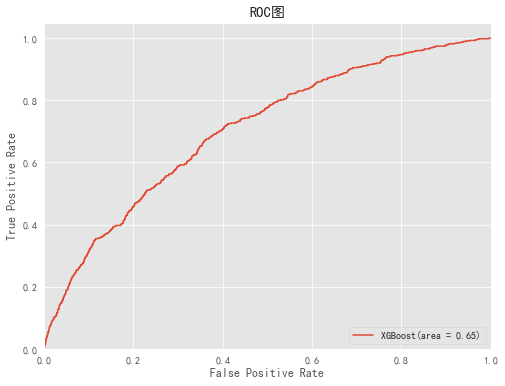

In [74]:
# 使用roc_curve方法计算roc曲线面积
xgb_fpr, xgb_tpr, xgb_thresholds = roc_curve(y_test1, model_xgb.predict_proba(X_test1)[:,1])
# 设置图片大小
plt.figure(figsize=(8,6))
# 使用plot方法画图
plt.plot(xgb_fpr, xgb_tpr, label='XGBoost(area = %0.2f)' % rf_roc_auc)
# 设置x轴参数范围
plt.xlim([0.0, 1.0])
# 设置y轴参数范围
plt.ylim([0.0, 1.05])
# 设置x轴标签
plt.xlabel('False Positive Rate')
# 设置y轴标签
plt.ylabel('True Positive Rate')
# 设置图的标题
plt.title('ROC图')
# 设置图例位置
plt.legend(loc="lower right")
# 展示结果
plt.show()

满满的用心